In [ ]:
eta = 0.1
optimizer_lr = 1e-5 # try 1e-5 from dim=2

dim = 6
n_center = 7
l = 5

num_layers = 30
width = 256

n_max_mirror_iterations= 10       # num mirror steps (for the frist and second)
n_max_iterations=6000        # max inner steps

num_samples = 10000         # number of theta generated for training
num_samples_test =  8192 # samples to estimate KL
import math
verbose = True
set_seed = 114540 # seed not used.
exp_number = 0 # [0, 1, 2, 3, 4]
pretrain_factor = 100

outer_lr_final_factor = 1e0
outer_eta_final_factor = 1e0
import math
outer_lr_factor = pow(math.e, math.log(outer_lr_final_factor)/n_max_mirror_iterations)
outer_eta_factor = pow(math.e, math.log(outer_eta_final_factor)/n_max_mirror_iterations)

In [ ]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87245 sha256=0a2ba9e6e50d68d48965f1c74e9eb9c0848ae4f67b75d607da822a0afbc3256e
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


In [ ]:
import numpy as np
import zlib
from multipledispatch import dispatch
import torch
import random

class RandomManager:
    '''
    Manage random using crc32 checksum for seeds generating
    '''

    @staticmethod
    def _get_crc32_seed(_str):
        _bstr = str.encode(_str)
        return zlib.crc32(_bstr)

    def _make_str(self, *args):
        return '@'.join(map(str, args))

    def __init__(self, *args):
        self._str = self._make_str(*args)

    def get_seed(self, *postfixes):
        _str = self._str + self._make_str(*postfixes)
        return self._get_crc32_seed(_str)

    def seed_random(self, *postfixes):
        rnd_postfixes = ('random',) + postfixes
        random.seed(self.get_seed(*rnd_postfixes))
        return self

    def seed_torch(self, *postfixes):
        torch_postfixes = ('pytorch',) + postfixes
        torch.manual_seed(self.get_seed(*torch_postfixes))
        return self

    def seed_numpy(self, *postfixes):
        np_postfixes = ('numpy',) + postfixes
        np.random.seed(self.get_seed(*np_postfixes))
        return self

    def seed(self, *postfixes):
        return self.seed_random(*postfixes).seed_numpy(*postfixes).seed_torch(*postfixes)

def get_random_manager(*args):
    return RandomManager(*args)

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch.nn.functional as F
import torch.distributions as TD
import pandas as pd
import seaborn as sb
import torch.nn as nn
import shutil
import gc
import copy
import time
from scipy.optimize import linear_sum_assignment

In [ ]:
torch.manual_seed(114514)
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [ ]:
def random_centers_distrib_generator(n, n_rand, target_span, std, device='cpu', dtype=torch.float32):
    centers_sample_distrib = TD.Uniform(-target_span, target_span)
    centers = centers_sample_distrib.sample((n_rand, n)).to(device, dtype)
    comp = TD.Independent(TD.Normal(centers, torch.tensor([std,]).to(device, dtype)), 1)
    mix = TD.Categorical(torch.ones(n_rand,).to(device, dtype))
    target = TD.MixtureSameFamily(mix, comp)
    return target

def random_project(input_data, p = 2, random_seed = 114514):
  import torch
# input_data n by m
# random_matrix m by p
# random_projected = 1/sqrt(p) * input_data %*% random_matrix
  torch.manual_seed(random_seed)
  m = input_data.shape[1]
  random_mx = torch.randn((m, p))
  projected = (1/torch.sqrt(torch.tensor(p)))*torch.matmul(input_data, random_mx)
  return projected

def plot_two_data(target_dist, model_transform):
  import matplotlib.pyplot as plt
  import pandas as pd
  import seaborn as sb

  df_1 = pd.DataFrame(random_project(target_dist)).astype("float")
  df_2 =  pd.DataFrame(random_project(model_transform)).astype("float")

  df_1["type"] = "target dist"
  df_2["type"] = "model transform"
  df_all = pd.concat([df_1, df_2], ignore_index=True)
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)
  sns_plot = sb.jointplot(data=df_all, x="dim_0", y="dim_1", hue="type", kind="kde")
  return sns_plot

<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


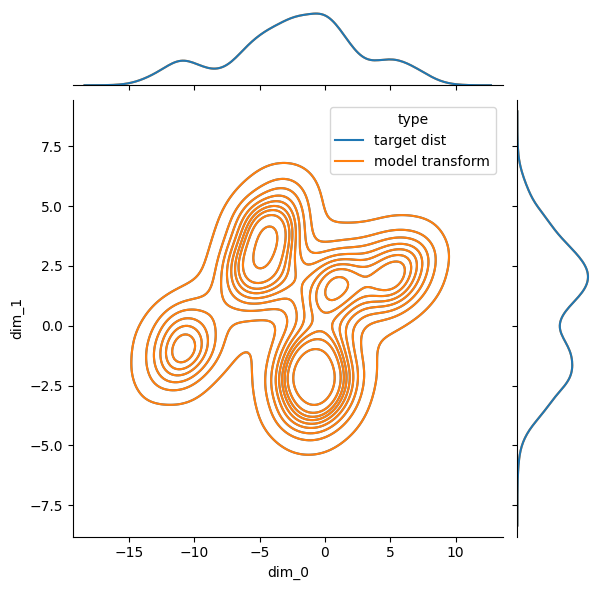

In [ ]:
r_m = get_random_manager('uran', dim, exp_number)
r_m.seed()

stationary_dist = random_centers_distrib_generator(n = dim, n_rand = n_center, target_span = l, std = 1, device=device, dtype=torch.float32)
target_samples = stationary_dist.sample((5000,))
plot_two_data(target_samples.cpu().detach(), target_samples.cpu().detach())

In [ ]:
kld1_hist = np.array([])
kld2_hist = np.array([])



trail_num = exp_number
torch.manual_seed(527)

# target_pretrain = TD.MultivariateNormal(
#     torch.zeros(dim).to(device), pretrain_factor * torch.eye(dim).to(device))
target_pretrain = TD.Uniform(-10, 10)
# Define 2D Gaussian base distribution
base = nf.distributions.DiagGaussian(dim, trainable=False)
# Define list of flows
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(dim, mode='swap'))

# for i in range(num_layers):
#     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
#     flows += [nf.flows.LULinearPermute(dim)]

# Construct flow model
model = nf.NormalizingFlow(base, flows).to(device)
optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

for it in tqdm(range(100)):
    optimizer1.zero_grad()

    # Get training samples
    # x = target_pretrain.sample((num_samples,)).to(device)
    x = target_pretrain.sample((num_samples, dim)).to(device)

    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer1.step()

    if it % 100 == 99:
      clear_output(wait=True)
      print('Loss:', loss.item())


100%|██████████| 100/100 [00:10<00:00,  9.87it/s]

Loss: 18.787796020507812


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


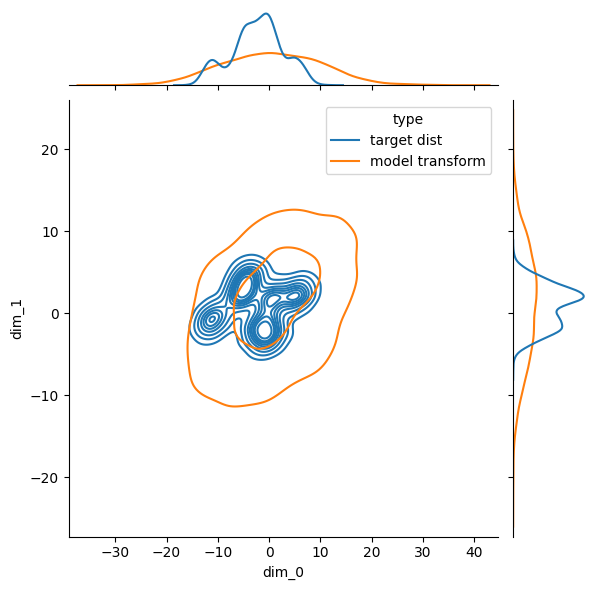

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

  2%|▏         | 100/6000 [00:29<31:29,  3.12it/s]

trail: 0 m step: 0 Loss: 38.27333450317383  L_n: 26.30901336669922  kld: 1.196432113647461 KLD1: 26.302892684936523 KLD2: 5.447177410125732


  3%|▎         | 200/6000 [00:58<31:52,  3.03it/s]

trail: 0 m step: 0 Loss: 35.95590782165527  L_n: 23.119985580444336  kld: 1.2835922241210938 KLD1: 23.175004959106445 KLD2: 5.189520359039307


  5%|▌         | 300/6000 [01:28<32:19,  2.94it/s]

trail: 0 m step: 0 Loss: 34.969234466552734  L_n: 21.183452606201172  kld: 1.3785781860351562 KLD1: 21.25946617126465 KLD2: 4.980250835418701


  7%|▋         | 400/6000 [01:59<31:59,  2.92it/s]

trail: 0 m step: 0 Loss: 34.70797348022461  L_n: 20.217350006103516  kld: 1.4490623474121094 KLD1: 19.97480010986328 KLD2: 4.862421989440918


  8%|▊         | 500/6000 [02:30<31:03,  2.95it/s]

trail: 0 m step: 0 Loss: 34.64828681945801  L_n: 19.995939254760742  kld: 1.4652347564697266 KLD1: 19.602365493774414 KLD2: 4.763834476470947


 10%|█         | 600/6000 [03:01<30:47,  2.92it/s]

trail: 0 m step: 0 Loss: 34.25207328796387  L_n: 19.593908309936523  kld: 1.4658164978027344 KLD1: 19.543630599975586 KLD2: 4.692056655883789


 12%|█▏        | 700/6000 [03:32<30:10,  2.93it/s]

trail: 0 m step: 0 Loss: 33.88199424743652  L_n: 19.20551872253418  kld: 1.4676475524902344 KLD1: 19.364585876464844 KLD2: 4.639221668243408


 13%|█▎        | 800/6000 [04:03<29:36,  2.93it/s]

trail: 0 m step: 0 Loss: 33.849361419677734  L_n: 19.215534210205078  kld: 1.4633827209472656 KLD1: 19.001970291137695 KLD2: 4.548934459686279


 15%|█▌        | 900/6000 [04:34<28:58,  2.93it/s]

trail: 0 m step: 0 Loss: 33.51460075378418  L_n: 18.97013282775879  kld: 1.454446792602539 KLD1: 18.961456298828125 KLD2: 4.54498291015625


 17%|█▋        | 1000/6000 [05:05<28:26,  2.93it/s]

trail: 0 m step: 0 Loss: 32.888153076171875  L_n: 18.39510726928711  kld: 1.4493045806884766 KLD1: 19.04056739807129 KLD2: 4.513334274291992


 18%|█▊        | 1100/6000 [05:35<27:50,  2.93it/s]

trail: 0 m step: 0 Loss: 33.32524108886719  L_n: 18.59467315673828  kld: 1.4730567932128906 KLD1: 18.629928588867188 KLD2: 4.420665740966797


 20%|██        | 1200/6000 [06:06<27:27,  2.91it/s]

trail: 0 m step: 0 Loss: 33.264509201049805  L_n: 18.361116409301758  kld: 1.4903392791748047 KLD1: 18.331819534301758 KLD2: 4.427255630493164


 22%|██▏       | 1300/6000 [06:37<26:49,  2.92it/s]

trail: 0 m step: 0 Loss: 32.905303955078125  L_n: 17.959396362304688  kld: 1.4945907592773438 KLD1: 18.09889030456543 KLD2: 4.388182163238525


 23%|██▎       | 1400/6000 [07:08<26:16,  2.92it/s]

trail: 0 m step: 0 Loss: 33.33066940307617  L_n: 18.290348052978516  kld: 1.5040321350097656 KLD1: 17.899883270263672 KLD2: 4.312919616699219


 25%|██▌       | 1500/6000 [07:39<25:39,  2.92it/s]

trail: 0 m step: 0 Loss: 32.72780990600586  L_n: 17.727542877197266  kld: 1.5000267028808594 KLD1: 17.79905891418457 KLD2: 4.315682888031006


 27%|██▋       | 1600/6000 [08:10<25:05,  2.92it/s]

trail: 0 m step: 0 Loss: 32.707258224487305  L_n: 17.465768814086914  kld: 1.524148941040039 KLD1: 17.3480281829834 KLD2: 4.237484455108643


 28%|██▊       | 1700/6000 [08:41<24:32,  2.92it/s]

trail: 0 m step: 0 Loss: 32.465030670166016  L_n: 17.54574966430664  kld: 1.4919281005859375 KLD1: 17.550683975219727 KLD2: 4.177263259887695


 30%|███       | 1800/6000 [09:12<24:00,  2.92it/s]

trail: 0 m step: 0 Loss: 32.32674217224121  L_n: 17.33406639099121  kld: 1.499267578125 KLD1: 17.417186737060547 KLD2: 4.152085304260254


 32%|███▏      | 1900/6000 [09:43<23:26,  2.92it/s]

trail: 0 m step: 0 Loss: 32.19981002807617  L_n: 17.256744384765625  kld: 1.4943065643310547 KLD1: 17.42354393005371 KLD2: 4.105187892913818


 33%|███▎      | 2000/6000 [10:14<22:50,  2.92it/s]

trail: 0 m step: 0 Loss: 32.45014762878418  L_n: 17.256494522094727  kld: 1.5193653106689453 KLD1: 17.03038787841797 KLD2: 4.091377258300781


 35%|███▌      | 2100/6000 [10:45<22:19,  2.91it/s]

trail: 0 m step: 0 Loss: 32.031620025634766  L_n: 17.00501251220703  kld: 1.5026607513427734 KLD1: 17.164989471435547 KLD2: 4.096500873565674


 37%|███▋      | 2200/6000 [11:16<21:37,  2.93it/s]

trail: 0 m step: 0 Loss: 31.995588302612305  L_n: 16.7987117767334  kld: 1.5196876525878906 KLD1: 16.928037643432617 KLD2: 4.0848188400268555


 38%|███▊      | 2300/6000 [11:47<21:08,  2.92it/s]

trail: 0 m step: 0 Loss: 32.12193489074707  L_n: 17.14776039123535  kld: 1.4974174499511719 KLD1: 17.184667587280273 KLD2: 4.090459823608398


 40%|████      | 2400/6000 [12:18<20:33,  2.92it/s]

trail: 0 m step: 0 Loss: 32.12558937072754  L_n: 16.936132431030273  kld: 1.5189456939697266 KLD1: 16.88033103942871 KLD2: 4.078877925872803


 42%|████▏     | 2500/6000 [12:49<19:58,  2.92it/s]

trail: 0 m step: 0 Loss: 31.972824096679688  L_n: 16.775432586669922  kld: 1.5197391510009766 KLD1: 16.85614013671875 KLD2: 4.060043811798096


 43%|████▎     | 2600/6000 [13:20<19:22,  2.92it/s]

trail: 0 m step: 0 Loss: 31.715097427368164  L_n: 16.77239418029785  kld: 1.4942703247070312 KLD1: 17.060321807861328 KLD2: 4.070688724517822


 45%|████▌     | 2700/6000 [13:50<18:51,  2.92it/s]

trail: 0 m step: 0 Loss: 31.999357223510742  L_n: 16.713979721069336  kld: 1.5285377502441406 KLD1: 16.751508712768555 KLD2: 4.022958278656006


 47%|████▋     | 2800/6000 [14:21<18:17,  2.92it/s]

trail: 0 m step: 0 Loss: 31.742151260375977  L_n: 16.592557907104492  kld: 1.5149593353271484 KLD1: 16.828859329223633 KLD2: 4.037403106689453


 48%|████▊     | 2900/6000 [14:52<17:41,  2.92it/s]

trail: 0 m step: 0 Loss: 32.072683334350586  L_n: 16.64885139465332  kld: 1.5423831939697266 KLD1: 16.568464279174805 KLD2: 3.9908885955810547


 50%|█████     | 3000/6000 [15:23<17:08,  2.92it/s]

trail: 0 m step: 0 Loss: 31.845664978027344  L_n: 16.667652130126953  kld: 1.517801284790039 KLD1: 16.81936264038086 KLD2: 4.046348571777344


 52%|█████▏    | 3100/6000 [15:54<16:32,  2.92it/s]

trail: 0 m step: 0 Loss: 31.82115936279297  L_n: 16.62920379638672  kld: 1.519195556640625 KLD1: 16.824729919433594 KLD2: 4.0442938804626465


 53%|█████▎    | 3200/6000 [16:25<16:02,  2.91it/s]

trail: 0 m step: 0 Loss: 32.09352493286133  L_n: 16.768264770507812  kld: 1.5325260162353516 KLD1: 16.650724411010742 KLD2: 4.021378040313721


 55%|█████▌    | 3300/6000 [16:56<15:28,  2.91it/s]

trail: 0 m step: 0 Loss: 31.997636795043945  L_n: 16.737321853637695  kld: 1.526031494140625 KLD1: 16.6783504486084 KLD2: 4.011126518249512


 57%|█████▋    | 3400/6000 [17:27<14:52,  2.91it/s]

trail: 0 m step: 0 Loss: 31.91287612915039  L_n: 16.706195831298828  kld: 1.5206680297851562 KLD1: 16.756011962890625 KLD2: 4.014795780181885


 58%|█████▊    | 3500/6000 [17:58<14:18,  2.91it/s]

trail: 0 m step: 0 Loss: 31.93720054626465  L_n: 16.659738540649414  kld: 1.5277462005615234 KLD1: 16.61717414855957 KLD2: 4.00209903717041


 60%|██████    | 3600/6000 [18:29<13:39,  2.93it/s]

trail: 0 m step: 0 Loss: 31.939664840698242  L_n: 16.62159538269043  kld: 1.5318069458007812 KLD1: 16.57022476196289 KLD2: 4.016714572906494


 62%|██████▏   | 3700/6000 [19:01<13:07,  2.92it/s]

trail: 0 m step: 0 Loss: 32.18204879760742  L_n: 16.582683563232422  kld: 1.5599365234375 KLD1: 16.334897994995117 KLD2: 4.013343811035156


 63%|██████▎   | 3800/6000 [19:32<12:37,  2.90it/s]

trail: 0 m step: 0 Loss: 31.790403366088867  L_n: 16.69749641418457  kld: 1.5092906951904297 KLD1: 16.841630935668945 KLD2: 4.016694068908691


 65%|██████▌   | 3900/6000 [20:03<12:00,  2.91it/s]

trail: 0 m step: 0 Loss: 31.687158584594727  L_n: 16.418699264526367  kld: 1.526845932006836 KLD1: 16.641633987426758 KLD2: 3.9904634952545166


 67%|██████▋   | 4000/6000 [20:34<11:25,  2.92it/s]

trail: 0 m step: 0 Loss: 31.92095375061035  L_n: 16.721406936645508  kld: 1.5199546813964844 KLD1: 16.68508529663086 KLD2: 4.029372692108154


 68%|██████▊   | 4100/6000 [21:05<10:51,  2.92it/s]

trail: 0 m step: 0 Loss: 31.558555603027344  L_n: 16.34415054321289  kld: 1.5214405059814453 KLD1: 16.689443588256836 KLD2: 4.003325462341309


 70%|███████   | 4200/6000 [21:36<10:19,  2.91it/s]

trail: 0 m step: 0 Loss: 31.98897361755371  L_n: 16.62245750427246  kld: 1.536651611328125 KLD1: 16.55176544189453 KLD2: 3.991311550140381


 72%|███████▏  | 4300/6000 [22:07<09:43,  2.91it/s]

trail: 0 m step: 0 Loss: 31.725372314453125  L_n: 16.277660369873047  kld: 1.5447711944580078 KLD1: 16.441465377807617 KLD2: 3.985856056213379


 73%|███████▎  | 4400/6000 [22:38<09:09,  2.91it/s]

trail: 0 m step: 0 Loss: 31.799053192138672  L_n: 16.493896484375  kld: 1.5305156707763672 KLD1: 16.591642379760742 KLD2: 3.9971070289611816


 75%|███████▌  | 4500/6000 [23:09<08:36,  2.91it/s]

trail: 0 m step: 0 Loss: 32.11612892150879  L_n: 16.673757553100586  kld: 1.5442371368408203 KLD1: 16.445493698120117 KLD2: 3.9752306938171387


 77%|███████▋  | 4600/6000 [23:40<08:02,  2.90it/s]

trail: 0 m step: 0 Loss: 32.08122253417969  L_n: 16.597671508789062  kld: 1.5483551025390625 KLD1: 16.358469009399414 KLD2: 3.9827187061309814


 78%|███████▊  | 4700/6000 [24:11<07:26,  2.91it/s]

trail: 0 m step: 0 Loss: 31.93105125427246  L_n: 16.4910831451416  kld: 1.543996810913086 KLD1: 16.4033145904541 KLD2: 3.971853733062744


 80%|████████  | 4800/6000 [24:42<06:52,  2.91it/s]

trail: 0 m step: 0 Loss: 32.22857093811035  L_n: 16.6618595123291  kld: 1.556671142578125 KLD1: 16.31763458251953 KLD2: 4.020838260650635


 82%|████████▏ | 4900/6000 [25:13<06:18,  2.91it/s]

trail: 0 m step: 0 Loss: 31.74372673034668  L_n: 16.426973342895508  kld: 1.5316753387451172 KLD1: 16.537137985229492 KLD2: 3.9794139862060547


 83%|████████▎ | 5000/6000 [25:44<05:43,  2.92it/s]

trail: 0 m step: 0 Loss: 31.581958770751953  L_n: 16.400245666503906  kld: 1.5181713104248047 KLD1: 16.710912704467773 KLD2: 3.9920358657836914


 85%|████████▌ | 5100/6000 [26:15<05:07,  2.92it/s]

trail: 0 m step: 0 Loss: 31.684825897216797  L_n: 16.556385040283203  kld: 1.5128440856933594 KLD1: 16.761005401611328 KLD2: 3.9877564907073975


 87%|████████▋ | 5200/6000 [26:46<04:34,  2.92it/s]

trail: 0 m step: 0 Loss: 31.63616943359375  L_n: 16.222064971923828  kld: 1.5414104461669922 KLD1: 16.452783584594727 KLD2: 3.9989423751831055


 88%|████████▊ | 5300/6000 [27:17<03:59,  2.93it/s]

trail: 0 m step: 0 Loss: 32.0054817199707  L_n: 16.657695770263672  kld: 1.5347785949707031 KLD1: 16.502086639404297 KLD2: 3.9648995399475098


 90%|█████████ | 5400/6000 [27:48<03:25,  2.92it/s]

trail: 0 m step: 0 Loss: 32.22688293457031  L_n: 16.70840835571289  kld: 1.5518474578857422 KLD1: 16.33433723449707 KLD2: 4.002940654754639


 92%|█████████▏| 5500/6000 [28:19<02:51,  2.91it/s]

trail: 0 m step: 0 Loss: 32.07977867126465  L_n: 16.41081428527832  kld: 1.5668964385986328 KLD1: 16.210102081298828 KLD2: 3.9624202251434326


 93%|█████████▎| 5600/6000 [28:50<02:16,  2.92it/s]

trail: 0 m step: 0 Loss: 31.80928611755371  L_n: 16.31795310974121  kld: 1.54913330078125 KLD1: 16.3419189453125 KLD2: 3.9866576194763184


 95%|█████████▌| 5700/6000 [29:21<01:42,  2.91it/s]

trail: 0 m step: 0 Loss: 31.671188354492188  L_n: 16.397350311279297  kld: 1.527383804321289 KLD1: 16.636327743530273 KLD2: 3.9796221256256104


 97%|█████████▋| 5800/6000 [29:52<01:08,  2.91it/s]

trail: 0 m step: 0 Loss: 31.821699142456055  L_n: 16.419706344604492  kld: 1.5401992797851562 KLD1: 16.463674545288086 KLD2: 3.9732396602630615


 98%|█████████▊| 5900/6000 [30:23<00:34,  2.91it/s]

trail: 0 m step: 0 Loss: 31.9298095703125  L_n: 16.431838989257812  kld: 1.5497970581054688 KLD1: 16.310543060302734 KLD2: 3.967733860015869


100%|██████████| 6000/6000 [30:54<00:00,  3.24it/s]

trail: 0 m step: 0 Loss: 32.2714900970459  L_n: 16.746110916137695  kld: 1.5525379180908203 KLD1: 16.282615661621094 KLD2: 4.007452011108398



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


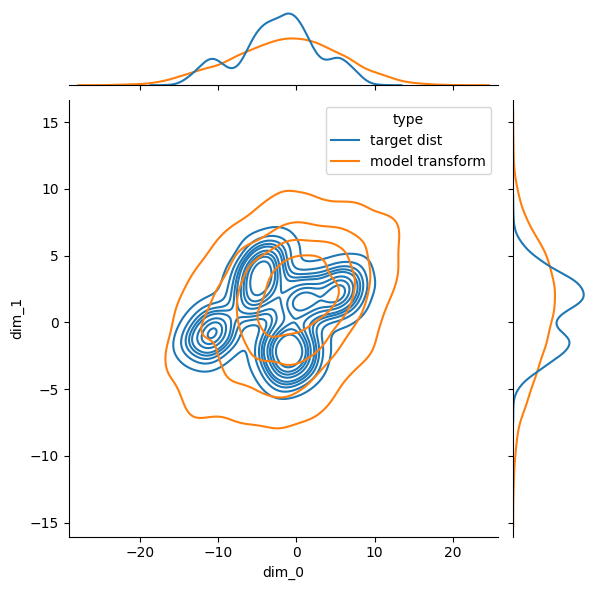

trail: 0 m step: 0 kl_test: 16.497756958007812


  2%|▏         | 100/6000 [00:31<34:20,  2.86it/s]

trail: 0 m step: 1 Loss: 11.901625633239746  L_n: 8.984087944030762  kld: 0.29175376892089844 KLD1: 8.872726440429688 KLD2: 2.9435958862304688


  3%|▎         | 200/6000 [01:02<33:05,  2.92it/s]

trail: 0 m step: 1 Loss: 11.588287353515625  L_n: 8.559675216674805  kld: 0.30286121368408203 KLD1: 8.56603717803955 KLD2: 2.8690226078033447


  5%|▌         | 300/6000 [01:33<32:46,  2.90it/s]

trail: 0 m step: 1 Loss: 11.410614013671875  L_n: 8.326574325561523  kld: 0.30840396881103516 KLD1: 8.435148239135742 KLD2: 2.836080312728882


  7%|▋         | 400/6000 [02:04<32:14,  2.89it/s]

trail: 0 m step: 1 Loss: 11.626388549804688  L_n: 8.370296478271484  kld: 0.3256092071533203 KLD1: 8.303985595703125 KLD2: 2.8198812007904053


  8%|▊         | 500/6000 [02:35<31:31,  2.91it/s]

trail: 0 m step: 1 Loss: 11.642195701599121  L_n: 8.391243934631348  kld: 0.32509517669677734 KLD1: 8.235701560974121 KLD2: 2.7952659130096436


 10%|█         | 600/6000 [03:07<31:03,  2.90it/s]

trail: 0 m step: 1 Loss: 11.572223663330078  L_n: 8.349424362182617  kld: 0.3222799301147461 KLD1: 8.257181167602539 KLD2: 2.778391122817993


 12%|█▏        | 700/6000 [03:38<30:25,  2.90it/s]

trail: 0 m step: 1 Loss: 11.414928436279297  L_n: 8.136882781982422  kld: 0.3278045654296875 KLD1: 8.16720962524414 KLD2: 2.773912191390991


 13%|█▎        | 800/6000 [04:09<29:46,  2.91it/s]

trail: 0 m step: 1 Loss: 11.409342765808105  L_n: 8.173182487487793  kld: 0.32361602783203125 KLD1: 8.235051155090332 KLD2: 2.728200674057007


 15%|█▌        | 900/6000 [04:40<29:23,  2.89it/s]

trail: 0 m step: 1 Loss: 11.416342735290527  L_n: 8.308184623718262  kld: 0.31081581115722656 KLD1: 8.329015731811523 KLD2: 2.75718355178833


 17%|█▋        | 1000/6000 [05:11<28:44,  2.90it/s]

trail: 0 m step: 1 Loss: 11.087667465209961  L_n: 7.967960357666016  kld: 0.31197071075439453 KLD1: 8.29875659942627 KLD2: 2.758314371109009


 18%|█▊        | 1100/6000 [05:43<28:12,  2.90it/s]

trail: 0 m step: 1 Loss: 11.325440406799316  L_n: 8.07553768157959  kld: 0.32499027252197266 KLD1: 8.121617317199707 KLD2: 2.701288938522339


 20%|██        | 1200/6000 [06:14<27:35,  2.90it/s]

trail: 0 m step: 1 Loss: 11.373519897460938  L_n: 8.020172119140625  kld: 0.33533477783203125 KLD1: 8.022967338562012 KLD2: 2.725571870803833


 22%|██▏       | 1300/6000 [06:45<27:04,  2.89it/s]

trail: 0 m step: 1 Loss: 11.347286224365234  L_n: 7.955085754394531  kld: 0.3392200469970703 KLD1: 7.9900031089782715 KLD2: 2.726902723312378


 23%|██▎       | 1400/6000 [07:16<26:30,  2.89it/s]

trail: 0 m step: 1 Loss: 11.57361888885498  L_n: 8.165587425231934  kld: 0.3408031463623047 KLD1: 7.942107677459717 KLD2: 2.696892023086548


 25%|██▌       | 1500/6000 [07:47<25:59,  2.89it/s]

trail: 0 m step: 1 Loss: 11.415327072143555  L_n: 8.063924789428711  kld: 0.3351402282714844 KLD1: 7.946345806121826 KLD2: 2.7420144081115723


 27%|██▋       | 1600/6000 [08:19<25:20,  2.89it/s]

trail: 0 m step: 1 Loss: 11.443704605102539  L_n: 7.935174942016602  kld: 0.35085296630859375 KLD1: 7.814754486083984 KLD2: 2.7046971321105957


 28%|██▊       | 1700/6000 [08:50<24:45,  2.89it/s]

trail: 0 m step: 1 Loss: 11.434353828430176  L_n: 8.116320610046387  kld: 0.3318033218383789 KLD1: 8.038416862487793 KLD2: 2.673964738845825


 30%|███       | 1800/6000 [09:21<24:09,  2.90it/s]

trail: 0 m step: 1 Loss: 11.302131652832031  L_n: 8.027786254882812  kld: 0.3274345397949219 KLD1: 8.064428329467773 KLD2: 2.690412759780884


 32%|███▏      | 1900/6000 [09:52<23:34,  2.90it/s]

trail: 0 m step: 1 Loss: 11.259957313537598  L_n: 8.028546333312988  kld: 0.32314109802246094 KLD1: 8.108333587646484 KLD2: 2.6708810329437256


 33%|███▎      | 2000/6000 [10:24<23:06,  2.89it/s]

trail: 0 m step: 1 Loss: 11.429414749145508  L_n: 8.120994567871094  kld: 0.3308420181274414 KLD1: 8.026039123535156 KLD2: 2.688760280609131


 35%|███▌      | 2100/6000 [10:55<22:26,  2.90it/s]

trail: 0 m step: 1 Loss: 11.245197296142578  L_n: 8.018888473510742  kld: 0.3226308822631836 KLD1: 8.067218780517578 KLD2: 2.693692207336426


 37%|███▋      | 2200/6000 [11:26<21:54,  2.89it/s]

trail: 0 m step: 1 Loss: 11.278443336486816  L_n: 7.92330265045166  kld: 0.3355140686035156 KLD1: 7.946664810180664 KLD2: 2.686400890350342


 38%|███▊      | 2300/6000 [11:57<21:18,  2.90it/s]

trail: 0 m step: 1 Loss: 11.214360237121582  L_n: 8.032425880432129  kld: 0.3181934356689453 KLD1: 8.159916877746582 KLD2: 2.697932004928589


 40%|████      | 2400/6000 [12:29<20:44,  2.89it/s]

trail: 0 m step: 1 Loss: 11.309988021850586  L_n: 7.950708389282227  kld: 0.33592796325683594 KLD1: 7.916092872619629 KLD2: 2.686835765838623


 42%|████▏     | 2500/6000 [13:00<20:05,  2.90it/s]

trail: 0 m step: 1 Loss: 11.291716575622559  L_n: 7.950346946716309  kld: 0.334136962890625 KLD1: 7.981401443481445 KLD2: 2.6875860691070557


 43%|████▎     | 2600/6000 [13:31<19:35,  2.89it/s]

trail: 0 m step: 1 Loss: 11.091214179992676  L_n: 7.893305778503418  kld: 0.3197908401489258 KLD1: 8.115438461303711 KLD2: 2.6972854137420654


 45%|████▌     | 2700/6000 [14:02<19:00,  2.89it/s]

trail: 0 m step: 1 Loss: 11.270659446716309  L_n: 7.9138593673706055  kld: 0.3356800079345703 KLD1: 7.983476161956787 KLD2: 2.663478136062622


 47%|████▋     | 2800/6000 [14:33<18:25,  2.89it/s]

trail: 0 m step: 1 Loss: 11.184629440307617  L_n: 7.850259780883789  kld: 0.3334369659423828 KLD1: 7.9958319664001465 KLD2: 2.6723968982696533


 48%|████▊     | 2900/6000 [15:05<17:49,  2.90it/s]

trail: 0 m step: 1 Loss: 11.352222442626953  L_n: 7.925985336303711  kld: 0.3426237106323242 KLD1: 7.875940322875977 KLD2: 2.6440227031707764


 50%|█████     | 3000/6000 [15:36<17:19,  2.89it/s]

trail: 0 m step: 1 Loss: 11.238324165344238  L_n: 7.960822105407715  kld: 0.32775020599365234 KLD1: 8.038020133972168 KLD2: 2.698955774307251


 52%|█████▏    | 3100/6000 [16:07<16:41,  2.89it/s]

trail: 0 m step: 1 Loss: 11.150447845458984  L_n: 7.861415863037109  kld: 0.3289031982421875 KLD1: 8.028178215026855 KLD2: 2.6919541358947754


 53%|█████▎    | 3200/6000 [16:38<16:08,  2.89it/s]

trail: 0 m step: 1 Loss: 11.328317642211914  L_n: 7.9442901611328125  kld: 0.33840274810791016 KLD1: 7.9045515060424805 KLD2: 2.667616605758667


 55%|█████▌    | 3300/6000 [17:10<15:32,  2.89it/s]

trail: 0 m step: 1 Loss: 11.328887939453125  L_n: 7.978143692016602  kld: 0.33507442474365234 KLD1: 7.903804302215576 KLD2: 2.6642236709594727


 57%|█████▋    | 3400/6000 [17:41<15:00,  2.89it/s]

trail: 0 m step: 1 Loss: 11.249017715454102  L_n: 7.957983016967773  kld: 0.3291034698486328 KLD1: 8.017609596252441 KLD2: 2.673008441925049


 58%|█████▊    | 3500/6000 [18:12<14:21,  2.90it/s]

trail: 0 m step: 1 Loss: 11.293045043945312  L_n: 7.935758590698242  kld: 0.33572864532470703 KLD1: 7.952141284942627 KLD2: 2.6649417877197266


 60%|██████    | 3600/6000 [18:43<13:46,  2.90it/s]

trail: 0 m step: 1 Loss: 11.35144329071045  L_n: 7.995787620544434  kld: 0.33556556701660156 KLD1: 7.908810138702393 KLD2: 2.6778104305267334


 62%|██████▏   | 3700/6000 [19:15<13:11,  2.90it/s]

trail: 0 m step: 1 Loss: 11.45127010345459  L_n: 7.97139835357666  kld: 0.34798717498779297 KLD1: 7.849063873291016 KLD2: 2.6810858249664307


 63%|██████▎   | 3800/6000 [19:46<12:41,  2.89it/s]

trail: 0 m step: 1 Loss: 11.23904800415039  L_n: 8.009830474853516  kld: 0.3229217529296875 KLD1: 8.084914207458496 KLD2: 2.6769254207611084


 65%|██████▌   | 3900/6000 [20:17<12:03,  2.90it/s]

trail: 0 m step: 1 Loss: 11.165780067443848  L_n: 7.8327836990356445  kld: 0.3332996368408203 KLD1: 7.939582824707031 KLD2: 2.658947229385376


 67%|██████▋   | 4000/6000 [20:48<11:31,  2.89it/s]

trail: 0 m step: 1 Loss: 11.334739685058594  L_n: 8.03542709350586  kld: 0.32993125915527344 KLD1: 7.993142127990723 KLD2: 2.692613124847412


 68%|██████▊   | 4100/6000 [21:20<10:57,  2.89it/s]

trail: 0 m step: 1 Loss: 11.122685432434082  L_n: 7.805157661437988  kld: 0.3317527770996094 KLD1: 7.992648124694824 KLD2: 2.6726250648498535


 70%|███████   | 4200/6000 [21:51<10:20,  2.90it/s]

trail: 0 m step: 1 Loss: 11.338506698608398  L_n: 7.9287872314453125  kld: 0.3409719467163086 KLD1: 7.901001453399658 KLD2: 2.658029317855835


 72%|███████▏  | 4300/6000 [22:22<09:47,  2.89it/s]

trail: 0 m step: 1 Loss: 11.169657707214355  L_n: 7.772936820983887  kld: 0.3396720886230469 KLD1: 7.893527984619141 KLD2: 2.654733896255493


 73%|███████▎  | 4400/6000 [22:53<09:14,  2.89it/s]

trail: 0 m step: 1 Loss: 11.220580101013184  L_n: 7.888785362243652  kld: 0.3331794738769531 KLD1: 7.968083381652832 KLD2: 2.667538642883301


 75%|███████▌  | 4500/6000 [23:25<08:37,  2.90it/s]

trail: 0 m step: 1 Loss: 11.439461708068848  L_n: 8.0067777633667  kld: 0.34326839447021484 KLD1: 7.847047328948975 KLD2: 2.650137424468994


 77%|███████▋  | 4600/6000 [23:56<08:03,  2.90it/s]

trail: 0 m step: 1 Loss: 11.414740562438965  L_n: 7.951272010803223  kld: 0.3463468551635742 KLD1: 7.812856197357178 KLD2: 2.659623146057129


 78%|███████▊  | 4700/6000 [24:27<07:30,  2.89it/s]

trail: 0 m step: 1 Loss: 11.334989547729492  L_n: 7.908180236816406  kld: 0.3426809310913086 KLD1: 7.85366678237915 KLD2: 2.6495821475982666


 80%|████████  | 4800/6000 [24:58<06:54,  2.89it/s]

trail: 0 m step: 1 Loss: 11.492051124572754  L_n: 7.959918022155762  kld: 0.3532133102416992 KLD1: 7.78220272064209 KLD2: 2.6903793811798096


 82%|████████▏ | 4900/6000 [25:30<06:19,  2.90it/s]

trail: 0 m step: 1 Loss: 11.148982048034668  L_n: 7.811236381530762  kld: 0.3337745666503906 KLD1: 7.935263633728027 KLD2: 2.6543915271759033


 83%|████████▎ | 5000/6000 [26:01<05:45,  2.90it/s]

trail: 0 m step: 1 Loss: 11.12292194366455  L_n: 7.850865364074707  kld: 0.3272056579589844 KLD1: 7.985782623291016 KLD2: 2.672116279602051


 85%|████████▌ | 5100/6000 [26:32<05:10,  2.90it/s]

trail: 0 m step: 1 Loss: 11.19455337524414  L_n: 7.916593551635742  kld: 0.32779598236083984 KLD1: 8.029314041137695 KLD2: 2.657853126525879


 87%|████████▋ | 5200/6000 [27:03<04:36,  2.89it/s]

trail: 0 m step: 1 Loss: 11.139792442321777  L_n: 7.746609687805176  kld: 0.33931827545166016 KLD1: 7.903371810913086 KLD2: 2.6751811504364014


 88%|████████▊ | 5300/6000 [27:35<04:01,  2.90it/s]

trail: 0 m step: 1 Loss: 11.400465965270996  L_n: 8.030524253845215  kld: 0.3369941711425781 KLD1: 7.913135528564453 KLD2: 2.6459100246429443


 90%|█████████ | 5400/6000 [28:06<03:26,  2.90it/s]

trail: 0 m step: 1 Loss: 11.433016777038574  L_n: 8.02806568145752  kld: 0.34049510955810547 KLD1: 7.849018573760986 KLD2: 2.685600996017456


 92%|█████████▏| 5500/6000 [28:37<02:52,  2.90it/s]

trail: 0 m step: 1 Loss: 11.402108192443848  L_n: 7.888581275939941  kld: 0.3513526916503906 KLD1: 7.786691188812256 KLD2: 2.6489837169647217


 93%|█████████▎| 5600/6000 [29:08<02:17,  2.90it/s]

trail: 0 m step: 1 Loss: 11.293058395385742  L_n: 7.818279266357422  kld: 0.34747791290283203 KLD1: 7.771698951721191 KLD2: 2.665703535079956


 95%|█████████▌| 5700/6000 [29:39<01:43,  2.89it/s]

trail: 0 m step: 1 Loss: 11.142111778259277  L_n: 7.793828010559082  kld: 0.33482837677001953 KLD1: 7.9653449058532715 KLD2: 2.6547327041625977


 97%|█████████▋| 5800/6000 [30:11<01:09,  2.90it/s]

trail: 0 m step: 1 Loss: 11.246968269348145  L_n: 7.864533424377441  kld: 0.3382434844970703 KLD1: 7.9238152503967285 KLD2: 2.654621124267578


 98%|█████████▊| 5900/6000 [30:42<00:34,  2.89it/s]

trail: 0 m step: 1 Loss: 11.353453636169434  L_n: 7.927702903747559  kld: 0.3425750732421875 KLD1: 7.8296709060668945 KLD2: 2.651174545288086


100%|██████████| 6000/6000 [31:13<00:00,  3.20it/s]

trail: 0 m step: 1 Loss: 11.52066707611084  L_n: 8.079047203063965  kld: 0.3441619873046875 KLD1: 7.822475433349609 KLD2: 2.6907799243927



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


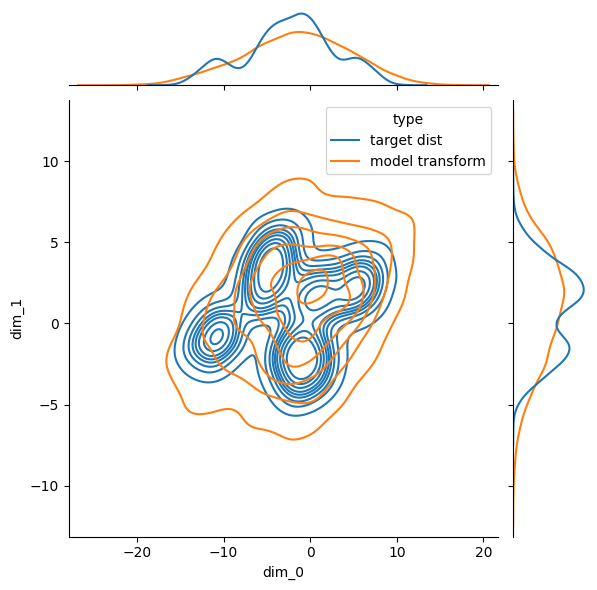

trail: 0 m step: 1 kl_test: 7.969088554382324


  2%|▏         | 100/6000 [00:31<34:23,  2.86it/s]

trail: 0 m step: 2 Loss: 6.305320739746094  L_n: 5.086944580078125  kld: 0.12183761596679688 KLD1: 4.99648904800415 KLD2: 2.0470545291900635


  3%|▎         | 200/6000 [01:02<33:13,  2.91it/s]

trail: 0 m step: 2 Loss: 6.162879943847656  L_n: 4.90861701965332  kld: 0.1254262924194336 KLD1: 4.912943363189697 KLD2: 2.0156948566436768


  5%|▌         | 300/6000 [01:33<32:54,  2.89it/s]

trail: 0 m step: 2 Loss: 6.060983657836914  L_n: 4.818002700805664  kld: 0.124298095703125 KLD1: 4.895777225494385 KLD2: 2.007477283477783


  7%|▋         | 400/6000 [02:05<32:18,  2.89it/s]

trail: 0 m step: 2 Loss: 6.265157699584961  L_n: 4.951862335205078  kld: 0.13132953643798828 KLD1: 4.8596906661987305 KLD2: 2.012425661087036


  8%|▊         | 500/6000 [02:36<31:47,  2.88it/s]

trail: 0 m step: 2 Loss: 6.233576774597168  L_n: 4.905423164367676  kld: 0.13281536102294922 KLD1: 4.816736698150635 KLD2: 1.9918001890182495


 10%|█         | 600/6000 [03:07<31:05,  2.90it/s]

trail: 0 m step: 2 Loss: 6.157317161560059  L_n: 4.869523048400879  kld: 0.12877941131591797 KLD1: 4.851731777191162 KLD2: 1.9803364276885986


 12%|█▏        | 700/6000 [03:39<30:32,  2.89it/s]

trail: 0 m step: 2 Loss: 6.096397399902344  L_n: 4.714256286621094  kld: 0.138214111328125 KLD1: 4.719917297363281 KLD2: 1.9699136018753052


 13%|█▎        | 800/6000 [04:10<29:55,  2.90it/s]

trail: 0 m step: 2 Loss: 6.081252098083496  L_n: 4.805798530578613  kld: 0.12754535675048828 KLD1: 4.866732120513916 KLD2: 1.9454858303070068


 15%|█▌        | 900/6000 [04:41<29:26,  2.89it/s]

trail: 0 m step: 2 Loss: 6.102603912353516  L_n: 4.876522064208984  kld: 0.12260818481445312 KLD1: 4.885255336761475 KLD2: 1.9675260782241821


 17%|█▋        | 1000/6000 [05:13<28:46,  2.90it/s]

trail: 0 m step: 2 Loss: 5.860316276550293  L_n: 4.610611915588379  kld: 0.1249704360961914 KLD1: 4.857429504394531 KLD2: 1.9640049934387207


 18%|█▊        | 1100/6000 [05:44<28:22,  2.88it/s]

trail: 0 m step: 2 Loss: 6.06174373626709  L_n: 4.720505714416504  kld: 0.1341238021850586 KLD1: 4.745238780975342 KLD2: 1.919271469116211


 20%|██        | 1200/6000 [06:15<27:39,  2.89it/s]

trail: 0 m step: 2 Loss: 6.097265243530273  L_n: 4.718223571777344  kld: 0.13790416717529297 KLD1: 4.714313983917236 KLD2: 1.9531461000442505


 22%|██▏       | 1300/6000 [06:47<27:05,  2.89it/s]

trail: 0 m step: 2 Loss: 6.064563751220703  L_n: 4.642063140869141  kld: 0.14225006103515625 KLD1: 4.660219192504883 KLD2: 1.9535995721817017


 23%|██▎       | 1400/6000 [07:18<26:32,  2.89it/s]

trail: 0 m step: 2 Loss: 6.2494707107543945  L_n: 4.824252128601074  kld: 0.14252185821533203 KLD1: 4.670771598815918 KLD2: 1.9303545951843262


 25%|██▌       | 1500/6000 [07:49<25:55,  2.89it/s]

trail: 0 m step: 2 Loss: 6.127215385437012  L_n: 4.766512870788574  kld: 0.13607025146484375 KLD1: 4.687122344970703 KLD2: 1.9782061576843262


 27%|██▋       | 1600/6000 [08:20<25:20,  2.89it/s]

trail: 0 m step: 2 Loss: 6.14333438873291  L_n: 4.672196388244629  kld: 0.14711380004882812 KLD1: 4.599097728729248 KLD2: 1.9452226161956787


 28%|██▊       | 1700/6000 [08:52<24:50,  2.89it/s]

trail: 0 m step: 2 Loss: 6.140665054321289  L_n: 4.751972198486328  kld: 0.1388692855834961 KLD1: 4.6705121994018555 KLD2: 1.9073866605758667


 30%|███       | 1800/6000 [09:23<24:11,  2.89it/s]

trail: 0 m step: 2 Loss: 6.0274505615234375  L_n: 4.678201675415039  kld: 0.13492488861083984 KLD1: 4.750378608703613 KLD2: 1.9254717826843262


 32%|███▏      | 1900/6000 [09:54<23:44,  2.88it/s]

trail: 0 m step: 2 Loss: 6.0120344161987305  L_n: 4.708094596862793  kld: 0.13039398193359375 KLD1: 4.798709392547607 KLD2: 1.9123505353927612


 33%|███▎      | 2000/6000 [10:26<23:02,  2.89it/s]

trail: 0 m step: 2 Loss: 6.133395195007324  L_n: 4.766303062438965  kld: 0.13670921325683594 KLD1: 4.716318607330322 KLD2: 1.9246429204940796


 35%|███▌      | 2100/6000 [10:57<22:32,  2.88it/s]

trail: 0 m step: 2 Loss: 6.010097503662109  L_n: 4.720863342285156  kld: 0.1289234161376953 KLD1: 4.750309944152832 KLD2: 1.9358364343643188


 37%|███▋      | 2200/6000 [11:28<21:57,  2.88it/s]

trail: 0 m step: 2 Loss: 6.029423713684082  L_n: 4.661129951477051  kld: 0.13682937622070312 KLD1: 4.700132369995117 KLD2: 1.9320124387741089


 38%|███▊      | 2300/6000 [11:59<21:21,  2.89it/s]

trail: 0 m step: 2 Loss: 5.974042892456055  L_n: 4.730499267578125  kld: 0.12435436248779297 KLD1: 4.853076457977295 KLD2: 1.9426511526107788


 40%|████      | 2400/6000 [12:31<20:47,  2.89it/s]

trail: 0 m step: 2 Loss: 6.069716453552246  L_n: 4.697436332702637  kld: 0.13722801208496094 KLD1: 4.696810245513916 KLD2: 1.9333971738815308


 42%|████▏     | 2500/6000 [13:02<20:11,  2.89it/s]

trail: 0 m step: 2 Loss: 6.058810234069824  L_n: 4.694951057434082  kld: 0.13638591766357422 KLD1: 4.6906208992004395 KLD2: 1.93345308303833


 43%|████▎     | 2600/6000 [13:33<19:37,  2.89it/s]

trail: 0 m step: 2 Loss: 5.952773094177246  L_n: 4.6547746658325195  kld: 0.12979984283447266 KLD1: 4.765127182006836 KLD2: 1.939663052558899


 45%|████▌     | 2700/6000 [14:05<19:04,  2.88it/s]

trail: 0 m step: 2 Loss: 6.024955749511719  L_n: 4.671977996826172  kld: 0.1352977752685547 KLD1: 4.7413458824157715 KLD2: 1.9137229919433594


 47%|████▋     | 2800/6000 [14:36<18:25,  2.90it/s]

trail: 0 m step: 2 Loss: 5.99315071105957  L_n: 4.648403167724609  kld: 0.1344747543334961 KLD1: 4.743128776550293 KLD2: 1.9228752851486206


 48%|████▊     | 2900/6000 [15:07<17:52,  2.89it/s]

trail: 0 m step: 2 Loss: 6.095067977905273  L_n: 4.692155838012695  kld: 0.1402912139892578 KLD1: 4.675093650817871 KLD2: 1.8977434635162354


 50%|█████     | 3000/6000 [15:39<17:18,  2.89it/s]

trail: 0 m step: 2 Loss: 6.041953086853027  L_n: 4.715773582458496  kld: 0.13261795043945312 KLD1: 4.742548942565918 KLD2: 1.9446685314178467


 52%|█████▏    | 3100/6000 [16:10<16:43,  2.89it/s]

trail: 0 m step: 2 Loss: 5.958866119384766  L_n: 4.64305305480957  kld: 0.13158130645751953 KLD1: 4.745861530303955 KLD2: 1.9420075416564941


 53%|█████▎    | 3200/6000 [16:41<16:09,  2.89it/s]

trail: 0 m step: 2 Loss: 6.0805253982543945  L_n: 4.696333885192871  kld: 0.13841915130615234 KLD1: 4.666837215423584 KLD2: 1.919873595237732


 55%|█████▌    | 3300/6000 [17:12<15:31,  2.90it/s]

trail: 0 m step: 2 Loss: 6.108877182006836  L_n: 4.719631195068359  kld: 0.13892459869384766 KLD1: 4.651057243347168 KLD2: 1.9143768548965454


 57%|█████▋    | 3400/6000 [17:44<14:59,  2.89it/s]

trail: 0 m step: 2 Loss: 6.011116027832031  L_n: 4.701711654663086  kld: 0.13094043731689453 KLD1: 4.757867336273193 KLD2: 1.924904227256775


 58%|█████▊    | 3500/6000 [18:15<14:26,  2.89it/s]

trail: 0 m step: 2 Loss: 6.035789489746094  L_n: 4.682411193847656  kld: 0.13533782958984375 KLD1: 4.697935581207275 KLD2: 1.9202079772949219


 60%|██████    | 3600/6000 [18:46<13:51,  2.89it/s]

trail: 0 m step: 2 Loss: 6.09877872467041  L_n: 4.739487648010254  kld: 0.13592910766601562 KLD1: 4.695428848266602 KLD2: 1.9318073987960815


 62%|██████▏   | 3700/6000 [19:18<13:18,  2.88it/s]

trail: 0 m step: 2 Loss: 6.138759613037109  L_n: 4.716106414794922  kld: 0.14226531982421875 KLD1: 4.646219730377197 KLD2: 1.9326214790344238


 63%|██████▎   | 3800/6000 [19:49<12:44,  2.88it/s]

trail: 0 m step: 2 Loss: 5.983423233032227  L_n: 4.705718994140625  kld: 0.12777042388916016 KLD1: 4.792741298675537 KLD2: 1.9284366369247437


 65%|██████▌   | 3900/6000 [20:20<12:08,  2.88it/s]

trail: 0 m step: 2 Loss: 5.976311683654785  L_n: 4.630295753479004  kld: 0.13460159301757812 KLD1: 4.690954208374023 KLD2: 1.9155222177505493


 67%|██████▋   | 4000/6000 [20:52<11:34,  2.88it/s]

trail: 0 m step: 2 Loss: 6.093136787414551  L_n: 4.7681684494018555  kld: 0.13249683380126953 KLD1: 4.733230113983154 KLD2: 1.945164442062378


 68%|██████▊   | 4100/6000 [21:23<10:59,  2.88it/s]

trail: 0 m step: 2 Loss: 5.979983329772949  L_n: 4.629637718200684  kld: 0.13503456115722656 KLD1: 4.717077255249023 KLD2: 1.924967885017395


 70%|███████   | 4200/6000 [21:55<10:25,  2.88it/s]

trail: 0 m step: 2 Loss: 6.096792221069336  L_n: 4.690008163452148  kld: 0.14067840576171875 KLD1: 4.664825439453125 KLD2: 1.9126170873641968


 72%|███████▏  | 4300/6000 [22:26<09:50,  2.88it/s]

trail: 0 m step: 2 Loss: 5.979992866516113  L_n: 4.605338096618652  kld: 0.1374654769897461 KLD1: 4.677781105041504 KLD2: 1.9127624034881592


 73%|███████▎  | 4400/6000 [22:57<09:15,  2.88it/s]

trail: 0 m step: 2 Loss: 6.040266990661621  L_n: 4.682034492492676  kld: 0.13582324981689453 KLD1: 4.6979875564575195 KLD2: 1.921305775642395


 75%|███████▌  | 4500/6000 [23:29<08:38,  2.89it/s]

trail: 0 m step: 2 Loss: 6.175792694091797  L_n: 4.748809814453125  kld: 0.1426982879638672 KLD1: 4.631416320800781 KLD2: 1.907315969467163


 77%|███████▋  | 4600/6000 [24:00<08:05,  2.88it/s]

trail: 0 m step: 2 Loss: 6.1330366134643555  L_n: 4.6952009201049805  kld: 0.1437835693359375 KLD1: 4.609708309173584 KLD2: 1.915930986404419


 78%|███████▊  | 4700/6000 [24:32<07:30,  2.88it/s]

trail: 0 m step: 2 Loss: 6.084316253662109  L_n: 4.682605743408203  kld: 0.14017105102539062 KLD1: 4.644290447235107 KLD2: 1.9082683324813843


 80%|████████  | 4800/6000 [25:03<06:57,  2.88it/s]

trail: 0 m step: 2 Loss: 6.202130317687988  L_n: 4.72536563873291  kld: 0.1476764678955078 KLD1: 4.597689628601074 KLD2: 1.9454658031463623


 82%|████████▏ | 4900/6000 [25:34<06:22,  2.87it/s]

trail: 0 m step: 2 Loss: 5.973959922790527  L_n: 4.622193336486816  kld: 0.1351766586303711 KLD1: 4.689885139465332 KLD2: 1.9094449281692505


 83%|████████▎ | 5000/6000 [26:06<05:47,  2.88it/s]

trail: 0 m step: 2 Loss: 5.952239036560059  L_n: 4.640097618103027  kld: 0.13121414184570312 KLD1: 4.736844539642334 KLD2: 1.9285672903060913


 85%|████████▌ | 5100/6000 [26:37<05:12,  2.88it/s]

trail: 0 m step: 2 Loss: 5.984462738037109  L_n: 4.668573379516602  kld: 0.13158893585205078 KLD1: 4.733370780944824 KLD2: 1.9120632410049438


 87%|████████▋ | 5200/6000 [27:08<04:37,  2.88it/s]

trail: 0 m step: 2 Loss: 5.972055435180664  L_n: 4.581808090209961  kld: 0.1390247344970703 KLD1: 4.677609920501709 KLD2: 1.9310998916625977


 88%|████████▊ | 5300/6000 [27:40<04:02,  2.88it/s]

trail: 0 m step: 2 Loss: 6.144315719604492  L_n: 4.7687835693359375  kld: 0.13755321502685547 KLD1: 4.65721321105957 KLD2: 1.9037976264953613


 90%|█████████ | 5400/6000 [28:11<03:28,  2.88it/s]

trail: 0 m step: 2 Loss: 6.14628791809082  L_n: 4.757537841796875  kld: 0.13887500762939453 KLD1: 4.668928623199463 KLD2: 1.9424636363983154


 92%|█████████▏| 5500/6000 [28:42<02:52,  2.89it/s]

trail: 0 m step: 2 Loss: 6.144232749938965  L_n: 4.690823554992676  kld: 0.1453409194946289 KLD1: 4.618875503540039 KLD2: 1.9107048511505127


 93%|█████████▎| 5600/6000 [29:14<02:18,  2.89it/s]

trail: 0 m step: 2 Loss: 6.080885887145996  L_n: 4.64443302154541  kld: 0.1436452865600586 KLD1: 4.593699932098389 KLD2: 1.9247561693191528


 95%|█████████▌| 5700/6000 [29:45<01:44,  2.88it/s]

trail: 0 m step: 2 Loss: 5.914828300476074  L_n: 4.548174858093262  kld: 0.13666534423828125 KLD1: 4.697747707366943 KLD2: 1.9123765230178833


 97%|█████████▋| 5800/6000 [30:16<01:09,  2.89it/s]

trail: 0 m step: 2 Loss: 6.000707626342773  L_n: 4.648111343383789  kld: 0.13525962829589844 KLD1: 4.70924186706543 KLD2: 1.914576530456543


 98%|█████████▊| 5900/6000 [30:48<00:34,  2.89it/s]

trail: 0 m step: 2 Loss: 6.107675552368164  L_n: 4.703609466552734  kld: 0.14040660858154297 KLD1: 4.647243499755859 KLD2: 1.9079216718673706


100%|██████████| 6000/6000 [31:19<00:00,  3.19it/s]

trail: 0 m step: 2 Loss: 6.206545829772949  L_n: 4.796624183654785  kld: 0.1409921646118164 KLD1: 4.624367713928223 KLD2: 1.9491475820541382



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


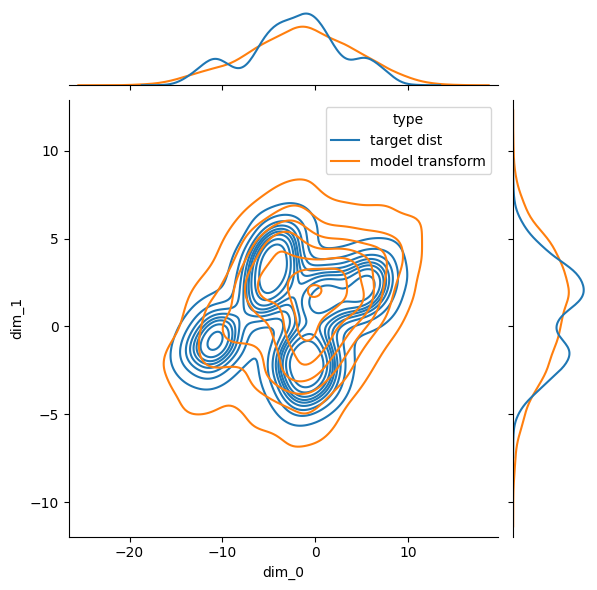

trail: 0 m step: 2 kl_test: 4.736333847045898


  2%|▏         | 100/6000 [00:31<34:31,  2.85it/s]

trail: 0 m step: 3 Loss: 3.939600944519043  L_n: 3.2986745834350586  kld: 0.06409263610839844 KLD1: 3.2154541015625 KLD2: 1.509415864944458


  3%|▎         | 200/6000 [01:02<33:17,  2.90it/s]

trail: 0 m step: 3 Loss: 3.850039482116699  L_n: 3.212632179260254  kld: 0.06374073028564453 KLD1: 3.229104518890381 KLD2: 1.4994760751724243


  5%|▌         | 300/6000 [01:34<33:06,  2.87it/s]

trail: 0 m step: 3 Loss: 3.765716552734375  L_n: 3.1094837188720703  kld: 0.06562328338623047 KLD1: 3.178025007247925 KLD2: 1.484127163887024


  7%|▋         | 400/6000 [02:05<32:19,  2.89it/s]

trail: 0 m step: 3 Loss: 3.930419921875  L_n: 3.2418575286865234  kld: 0.06885623931884766 KLD1: 3.1582000255584717 KLD2: 1.499896764755249


  8%|▊         | 500/6000 [02:36<31:49,  2.88it/s]

trail: 0 m step: 3 Loss: 3.9007863998413086  L_n: 3.199387550354004  kld: 0.07013988494873047 KLD1: 3.143784999847412 KLD2: 1.4854904413223267


 10%|█         | 600/6000 [03:08<31:04,  2.90it/s]

trail: 0 m step: 3 Loss: 3.844461441040039  L_n: 3.180665969848633  kld: 0.06637954711914062 KLD1: 3.1952545642852783 KLD2: 1.4779912233352661


 12%|█▏        | 700/6000 [03:39<30:31,  2.89it/s]

trail: 0 m step: 3 Loss: 3.7982406616210938  L_n: 3.038248062133789  kld: 0.07599925994873047 KLD1: 3.061417579650879 KLD2: 1.4668091535568237


 13%|█▎        | 800/6000 [04:10<30:01,  2.89it/s]

trail: 0 m step: 3 Loss: 3.7828369140625  L_n: 3.1497116088867188  kld: 0.06331253051757812 KLD1: 3.1985726356506348 KLD2: 1.454728126525879


 15%|█▌        | 900/6000 [04:41<29:27,  2.89it/s]

trail: 0 m step: 3 Loss: 3.811185836791992  L_n: 3.191650390625  kld: 0.06195354461669922 KLD1: 3.208578109741211 KLD2: 1.4710558652877808


 17%|█▋        | 1000/6000 [05:13<28:46,  2.90it/s]

trail: 0 m step: 3 Loss: 3.6279067993164062  L_n: 3.00927734375  kld: 0.061862945556640625 KLD1: 3.2149031162261963 KLD2: 1.4753456115722656


 18%|█▊        | 1100/6000 [05:44<28:19,  2.88it/s]

trail: 0 m step: 3 Loss: 3.800436019897461  L_n: 3.093944549560547  kld: 0.0706491470336914 KLD1: 3.1123745441436768 KLD2: 1.43264639377594


 20%|██        | 1200/6000 [06:15<27:48,  2.88it/s]

trail: 0 m step: 3 Loss: 3.832071304321289  L_n: 3.104494094848633  kld: 0.07275772094726562 KLD1: 3.1002109050750732 KLD2: 1.4674605131149292


 22%|██▏       | 1300/6000 [06:47<27:10,  2.88it/s]

trail: 0 m step: 3 Loss: 3.786776542663574  L_n: 3.025925636291504  kld: 0.07608509063720703 KLD1: 3.036245584487915 KLD2: 1.4643476009368896


 23%|██▎       | 1400/6000 [07:18<26:34,  2.88it/s]

trail: 0 m step: 3 Loss: 3.9346370697021484  L_n: 3.1922969818115234  kld: 0.0742340087890625 KLD1: 3.087993860244751 KLD2: 1.4499017000198364


 25%|██▌       | 1500/6000 [07:49<26:02,  2.88it/s]

trail: 0 m step: 3 Loss: 3.8306541442871094  L_n: 3.131000518798828  kld: 0.06996536254882812 KLD1: 3.078538656234741 KLD2: 1.4925081729888916


 27%|██▋       | 1600/6000 [08:21<25:26,  2.88it/s]

trail: 0 m step: 3 Loss: 3.8419504165649414  L_n: 3.0754919052124023  kld: 0.0766458511352539 KLD1: 3.0318307876586914 KLD2: 1.4672662019729614


 28%|██▊       | 1700/6000 [08:52<24:48,  2.89it/s]

trail: 0 m step: 3 Loss: 3.833836555480957  L_n: 3.1034650802612305  kld: 0.07303714752197266 KLD1: 3.0427041053771973 KLD2: 1.4277101755142212


 30%|███       | 1800/6000 [09:23<24:14,  2.89it/s]

trail: 0 m step: 3 Loss: 3.7635812759399414  L_n: 3.0660829544067383  kld: 0.06974983215332031 KLD1: 3.132702112197876 KLD2: 1.4442285299301147


 32%|███▏      | 1900/6000 [09:55<23:40,  2.89it/s]

trail: 0 m step: 3 Loss: 3.764371871948242  L_n: 3.0971527099609375  kld: 0.06672191619873047 KLD1: 3.1591455936431885 KLD2: 1.4315085411071777


 33%|███▎      | 2000/6000 [10:26<23:03,  2.89it/s]

trail: 0 m step: 3 Loss: 3.841029167175293  L_n: 3.125058174133301  kld: 0.07159709930419922 KLD1: 3.1047861576080322 KLD2: 1.4418919086456299


 35%|███▌      | 2100/6000 [10:58<22:33,  2.88it/s]

trail: 0 m step: 3 Loss: 3.7426023483276367  L_n: 3.0934457778930664  kld: 0.06491565704345703 KLD1: 3.125622510910034 KLD2: 1.455001950263977


 37%|███▋      | 2200/6000 [11:29<21:58,  2.88it/s]

trail: 0 m step: 3 Loss: 3.7460289001464844  L_n: 3.0321273803710938  kld: 0.07139015197753906 KLD1: 3.0889196395874023 KLD2: 1.4505420923233032


 38%|███▊      | 2300/6000 [12:00<21:22,  2.88it/s]

trail: 0 m step: 3 Loss: 3.737706184387207  L_n: 3.120793342590332  kld: 0.0616912841796875 KLD1: 3.203967809677124 KLD2: 1.4621329307556152


 40%|████      | 2400/6000 [12:32<20:47,  2.89it/s]

trail: 0 m step: 3 Loss: 3.8023061752319336  L_n: 3.0882997512817383  kld: 0.07140064239501953 KLD1: 3.0910027027130127 KLD2: 1.4512267112731934


 42%|████▏     | 2500/6000 [13:03<20:12,  2.89it/s]

trail: 0 m step: 3 Loss: 3.7889175415039062  L_n: 3.075836181640625  kld: 0.07130813598632812 KLD1: 3.085529327392578 KLD2: 1.453398585319519


 43%|████▎     | 2600/6000 [13:34<19:38,  2.89it/s]

trail: 0 m step: 3 Loss: 3.734280586242676  L_n: 3.0634851455688477  kld: 0.06707954406738281 KLD1: 3.110513687133789 KLD2: 1.4582628011703491


 45%|████▌     | 2700/6000 [14:06<19:06,  2.88it/s]

trail: 0 m step: 3 Loss: 3.7556142807006836  L_n: 3.057620048522949  kld: 0.06979942321777344 KLD1: 3.1238420009613037 KLD2: 1.4341022968292236


 47%|████▋     | 2800/6000 [14:37<18:31,  2.88it/s]

trail: 0 m step: 3 Loss: 3.763784408569336  L_n: 3.0625476837158203  kld: 0.07012367248535156 KLD1: 3.1027135848999023 KLD2: 1.4439003467559814


 48%|████▊     | 2900/6000 [15:08<17:55,  2.88it/s]

trail: 0 m step: 3 Loss: 3.8167152404785156  L_n: 3.084779739379883  kld: 0.07319355010986328 KLD1: 3.080678701400757 KLD2: 1.42021906375885


 50%|█████     | 3000/6000 [15:40<17:20,  2.88it/s]

trail: 0 m step: 3 Loss: 3.787417411804199  L_n: 3.104853630065918  kld: 0.06825637817382812 KLD1: 3.11358904838562 KLD2: 1.463696002960205


 52%|█████▏    | 3100/6000 [16:11<16:45,  2.88it/s]

trail: 0 m step: 3 Loss: 3.7357254028320312  L_n: 3.0657882690429688  kld: 0.06699371337890625 KLD1: 3.1259853839874268 KLD2: 1.4609986543655396


 53%|█████▎    | 3200/6000 [16:42<16:10,  2.88it/s]

trail: 0 m step: 3 Loss: 3.795351982116699  L_n: 3.077712059020996  kld: 0.07176399230957031 KLD1: 3.067267417907715 KLD2: 1.4403743743896484


 55%|█████▌    | 3300/6000 [17:14<15:36,  2.88it/s]

trail: 0 m step: 3 Loss: 3.845372200012207  L_n: 3.1084394454956055  kld: 0.07369327545166016 KLD1: 3.049996852874756 KLD2: 1.4352365732192993


 57%|█████▋    | 3400/6000 [17:45<14:59,  2.89it/s]

trail: 0 m step: 3 Loss: 3.761563301086426  L_n: 3.099064826965332  kld: 0.06624984741210938 KLD1: 3.1457760334014893 KLD2: 1.4448215961456299


 58%|█████▊    | 3500/6000 [18:16<14:22,  2.90it/s]

trail: 0 m step: 3 Loss: 3.7585840225219727  L_n: 3.061953544616699  kld: 0.06966304779052734 KLD1: 3.0792043209075928 KLD2: 1.442183256149292


 60%|██████    | 3600/6000 [18:48<13:52,  2.88it/s]

trail: 0 m step: 3 Loss: 3.8030099868774414  L_n: 3.1054162979125977  kld: 0.06975936889648438 KLD1: 3.093207836151123 KLD2: 1.4531906843185425


 62%|██████▏   | 3700/6000 [19:19<13:18,  2.88it/s]

trail: 0 m step: 3 Loss: 3.837691307067871  L_n: 3.0972394943237305  kld: 0.07404518127441406 KLD1: 3.044046401977539 KLD2: 1.4525450468063354


 63%|██████▎   | 3800/6000 [19:51<12:43,  2.88it/s]

trail: 0 m step: 3 Loss: 3.7275867462158203  L_n: 3.0781822204589844  kld: 0.0649404525756836 KLD1: 3.1507935523986816 KLD2: 1.446897029876709


 65%|██████▌   | 3900/6000 [20:22<12:08,  2.88it/s]

trail: 0 m step: 3 Loss: 3.7190322875976562  L_n: 3.0270652770996094  kld: 0.06919670104980469 KLD1: 3.0857787132263184 KLD2: 1.439802646636963


 67%|██████▋   | 4000/6000 [20:53<11:33,  2.88it/s]

trail: 0 m step: 3 Loss: 3.812619209289551  L_n: 3.13071346282959  kld: 0.0681905746459961 KLD1: 3.112797260284424 KLD2: 1.4658145904541016


 68%|██████▊   | 4100/6000 [21:25<10:59,  2.88it/s]

trail: 0 m step: 3 Loss: 3.7497777938842773  L_n: 3.050553321838379  kld: 0.06992244720458984 KLD1: 3.091312885284424 KLD2: 1.4467990398406982


 70%|███████   | 4200/6000 [21:56<10:24,  2.88it/s]

trail: 0 m step: 3 Loss: 3.825201988220215  L_n: 3.0769872665405273  kld: 0.07482147216796875 KLD1: 3.0549356937408447 KLD2: 1.4340916872024536


 72%|███████▏  | 4300/6000 [22:27<09:49,  2.88it/s]

trail: 0 m step: 3 Loss: 3.716334342956543  L_n: 3.002346992492676  kld: 0.07139873504638672 KLD1: 3.0718319416046143 KLD2: 1.4355964660644531


 73%|███████▎  | 4400/6000 [22:59<09:12,  2.89it/s]

trail: 0 m step: 3 Loss: 3.7816858291625977  L_n: 3.0634641647338867  kld: 0.0718221664428711 KLD1: 3.0659754276275635 KLD2: 1.4415980577468872


 75%|███████▌  | 4500/6000 [23:30<08:38,  2.90it/s]

trail: 0 m step: 3 Loss: 3.88076114654541  L_n: 3.1297616958618164  kld: 0.07509994506835938 KLD1: 3.0281379222869873 KLD2: 1.430375337600708


 77%|███████▋  | 4600/6000 [24:01<08:05,  2.88it/s]

trail: 0 m step: 3 Loss: 3.8716793060302734  L_n: 3.110179901123047  kld: 0.07614994049072266 KLD1: 3.015610933303833 KLD2: 1.439062237739563


 78%|███████▊  | 4700/6000 [24:32<07:28,  2.90it/s]

trail: 0 m step: 3 Loss: 3.820572853088379  L_n: 3.081923484802246  kld: 0.07386493682861328 KLD1: 3.0414857864379883 KLD2: 1.4311065673828125


 80%|████████  | 4800/6000 [25:04<06:55,  2.89it/s]

trail: 0 m step: 3 Loss: 3.8858423233032227  L_n: 3.102341651916504  kld: 0.07835006713867188 KLD1: 3.0186073780059814 KLD2: 1.4667882919311523


 82%|████████▏ | 4900/6000 [25:35<06:20,  2.89it/s]

trail: 0 m step: 3 Loss: 3.7354612350463867  L_n: 3.0403661727905273  kld: 0.06950950622558594 KLD1: 3.08353328704834 KLD2: 1.4317635297775269


 83%|████████▎ | 5000/6000 [26:06<05:46,  2.88it/s]

trail: 0 m step: 3 Loss: 3.699732780456543  L_n: 3.0260095596313477  kld: 0.06737232208251953 KLD1: 3.106008529663086 KLD2: 1.4502887725830078


 85%|████████▌ | 5100/6000 [26:38<05:11,  2.89it/s]

trail: 0 m step: 3 Loss: 3.7400436401367188  L_n: 3.0580902099609375  kld: 0.06819534301757812 KLD1: 3.101263999938965 KLD2: 1.4341869354248047


 87%|████████▋ | 5200/6000 [27:09<04:36,  2.89it/s]

trail: 0 m step: 3 Loss: 3.7371826171875  L_n: 3.0152225494384766  kld: 0.07219600677490234 KLD1: 3.051248550415039 KLD2: 1.4528247117996216


 88%|████████▊ | 5300/6000 [27:40<04:01,  2.89it/s]

trail: 0 m step: 3 Loss: 3.8637571334838867  L_n: 3.1391172409057617  kld: 0.0724639892578125 KLD1: 3.0528807640075684 KLD2: 1.4270890951156616


 90%|█████████ | 5400/6000 [28:11<03:27,  2.89it/s]

trail: 0 m step: 3 Loss: 3.841329574584961  L_n: 3.1259593963623047  kld: 0.07153701782226562 KLD1: 3.087550401687622 KLD2: 1.4635515213012695


 92%|█████████▏| 5500/6000 [28:43<02:53,  2.89it/s]

trail: 0 m step: 3 Loss: 3.8549680709838867  L_n: 3.09189510345459  kld: 0.07630729675292969 KLD1: 3.039210796356201 KLD2: 1.4360005855560303


 93%|█████████▎| 5600/6000 [29:14<02:18,  2.88it/s]

trail: 0 m step: 3 Loss: 3.8076248168945312  L_n: 3.055652618408203  kld: 0.07519721984863281 KLD1: 3.0274460315704346 KLD2: 1.4474222660064697


 95%|█████████▌| 5700/6000 [29:46<01:44,  2.88it/s]

trail: 0 m step: 3 Loss: 3.682727813720703  L_n: 2.9648208618164062  kld: 0.07179069519042969 KLD1: 3.067274808883667 KLD2: 1.4360568523406982


 97%|█████████▋| 5800/6000 [30:17<01:09,  2.89it/s]

trail: 0 m step: 3 Loss: 3.745194435119629  L_n: 3.0558977127075195  kld: 0.06892967224121094 KLD1: 3.0992863178253174 KLD2: 1.4380207061767578


 98%|█████████▊| 5900/6000 [30:48<00:34,  2.89it/s]

trail: 0 m step: 3 Loss: 3.8379592895507812  L_n: 3.1043167114257812  kld: 0.0733642578125 KLD1: 3.060086250305176 KLD2: 1.4308966398239136


100%|██████████| 6000/6000 [31:19<00:00,  3.19it/s]

trail: 0 m step: 3 Loss: 3.8850698471069336  L_n: 3.1390867233276367  kld: 0.07459831237792969 KLD1: 3.038935422897339 KLD2: 1.4691803455352783



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


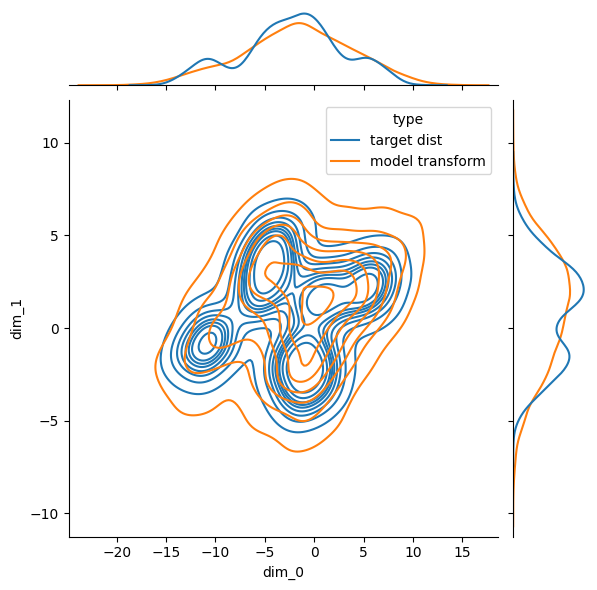

trail: 0 m step: 3 kl_test: 3.101673126220703


  2%|▏         | 100/6000 [00:31<34:24,  2.86it/s]

trail: 0 m step: 4 Loss: 2.6782302856445312  L_n: 2.310903549194336  kld: 0.03673267364501953 KLD1: 2.2346150875091553 KLD2: 1.1543283462524414


  3%|▎         | 200/6000 [01:02<33:17,  2.90it/s]

trail: 0 m step: 4 Loss: 2.6180057525634766  L_n: 2.2485523223876953  kld: 0.036945343017578125 KLD1: 2.254434823989868 KLD2: 1.1478650569915771


  5%|▌         | 300/6000 [01:34<33:02,  2.88it/s]

trail: 0 m step: 4 Loss: 2.5395679473876953  L_n: 2.1342086791992188  kld: 0.040535926818847656 KLD1: 2.174896717071533 KLD2: 1.1309267282485962


  7%|▋         | 400/6000 [02:05<32:20,  2.89it/s]

trail: 0 m step: 4 Loss: 2.667276382446289  L_n: 2.248727798461914  kld: 0.0418548583984375 KLD1: 2.178703546524048 KLD2: 1.150636076927185


  8%|▊         | 500/6000 [02:36<31:45,  2.89it/s]

trail: 0 m step: 4 Loss: 2.6555652618408203  L_n: 2.23529052734375  kld: 0.04202747344970703 KLD1: 2.188713312149048 KLD2: 1.1426347494125366


 10%|█         | 600/6000 [03:08<31:09,  2.89it/s]

trail: 0 m step: 4 Loss: 2.59932804107666  L_n: 2.207797050476074  kld: 0.039153099060058594 KLD1: 2.227219581604004 KLD2: 1.1367040872573853


 12%|█▏        | 700/6000 [03:39<30:38,  2.88it/s]

trail: 0 m step: 4 Loss: 2.5803050994873047  L_n: 2.096677780151367  kld: 0.04836273193359375 KLD1: 2.1092538833618164 KLD2: 1.1259729862213135


 13%|█▎        | 800/6000 [04:10<30:03,  2.88it/s]

trail: 0 m step: 4 Loss: 2.56064510345459  L_n: 2.203274726867676  kld: 0.035737037658691406 KLD1: 2.2364954948425293 KLD2: 1.1192433834075928


 15%|█▌        | 900/6000 [04:42<29:25,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5968198776245117  L_n: 2.239373207092285  kld: 0.035744667053222656 KLD1: 2.2451093196868896 KLD2: 1.1299006938934326


 17%|█▋        | 1000/6000 [05:13<28:56,  2.88it/s]

trail: 0 m step: 4 Loss: 2.441460609436035  L_n: 2.09824275970459  kld: 0.03432178497314453 KLD1: 2.2649004459381104 KLD2: 1.1418999433517456


 18%|█▊        | 1100/6000 [05:44<28:15,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5679759979248047  L_n: 2.1465377807617188  kld: 0.042143821716308594 KLD1: 2.1705541610717773 KLD2: 1.0992932319641113


 20%|██        | 1200/6000 [06:16<27:43,  2.89it/s]

trail: 0 m step: 4 Loss: 2.6059093475341797  L_n: 2.162689208984375  kld: 0.04432201385498047 KLD1: 2.16546630859375 KLD2: 1.1315044164657593


 22%|██▏       | 1300/6000 [06:47<27:07,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5647010803222656  L_n: 2.105630874633789  kld: 0.045907020568847656 KLD1: 2.1268956661224365 KLD2: 1.1305066347122192


 23%|██▎       | 1400/6000 [07:18<26:31,  2.89it/s]

trail: 0 m step: 4 Loss: 2.6705713272094727  L_n: 2.2245092391967773  kld: 0.04460620880126953 KLD1: 2.147050619125366 KLD2: 1.1166167259216309


 25%|██▌       | 1500/6000 [07:50<26:00,  2.88it/s]

trail: 0 m step: 4 Loss: 2.602458953857422  L_n: 2.1945724487304688  kld: 0.04078865051269531 KLD1: 2.148013114929199 KLD2: 1.1573015451431274


 27%|██▋       | 1600/6000 [08:21<25:22,  2.89it/s]

trail: 0 m step: 4 Loss: 2.6185836791992188  L_n: 2.165149688720703  kld: 0.04534339904785156 KLD1: 2.117966413497925 KLD2: 1.1363110542297363


 28%|██▊       | 1700/6000 [08:52<24:49,  2.89it/s]

trail: 0 m step: 4 Loss: 2.591022491455078  L_n: 2.158121109008789  kld: 0.043290138244628906 KLD1: 2.128183126449585 KLD2: 1.0984995365142822


 30%|███       | 1800/6000 [09:24<24:14,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5577898025512695  L_n: 2.150628089904785  kld: 0.04071617126464844 KLD1: 2.204329013824463 KLD2: 1.112587809562683


 32%|███▏      | 1900/6000 [09:55<23:39,  2.89it/s]

trail: 0 m step: 4 Loss: 2.559786796569824  L_n: 2.1727094650268555  kld: 0.038707733154296875 KLD1: 2.212667465209961 KLD2: 1.100733995437622


 33%|███▎      | 2000/6000 [10:26<23:00,  2.90it/s]

trail: 0 m step: 4 Loss: 2.6091718673706055  L_n: 2.1808481216430664  kld: 0.042832374572753906 KLD1: 2.159499168395996 KLD2: 1.1087062358856201


 35%|███▌      | 2100/6000 [10:58<22:27,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5189924240112305  L_n: 2.144007682800293  kld: 0.03749847412109375 KLD1: 2.1819231510162354 KLD2: 1.1210874319076538


 37%|███▋      | 2200/6000 [11:29<21:55,  2.89it/s]

trail: 0 m step: 4 Loss: 2.541736602783203  L_n: 2.1144237518310547  kld: 0.042731285095214844 KLD1: 2.155261754989624 KLD2: 1.11795175075531


 38%|███▊      | 2300/6000 [12:00<21:25,  2.88it/s]

trail: 0 m step: 4 Loss: 2.5346202850341797  L_n: 2.1828575134277344  kld: 0.03517627716064453 KLD1: 2.2305846214294434 KLD2: 1.1276510953903198


 40%|████      | 2400/6000 [12:31<20:40,  2.90it/s]

trail: 0 m step: 4 Loss: 2.5674352645874023  L_n: 2.1492013931274414  kld: 0.041823387145996094 KLD1: 2.1592140197753906 KLD2: 1.119070053100586


 42%|████▏     | 2500/6000 [13:03<20:09,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5681772232055664  L_n: 2.146090507507324  kld: 0.04220867156982422 KLD1: 2.1612722873687744 KLD2: 1.1219722032546997


 43%|████▎     | 2600/6000 [13:34<19:37,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5325746536254883  L_n: 2.143895149230957  kld: 0.038867950439453125 KLD1: 2.1748206615448 KLD2: 1.127423644065857


 45%|████▌     | 2700/6000 [14:05<19:05,  2.88it/s]

trail: 0 m step: 4 Loss: 2.536850929260254  L_n: 2.1238622665405273  kld: 0.041298866271972656 KLD1: 2.180502414703369 KLD2: 1.102638840675354


 47%|████▋     | 2800/6000 [14:37<18:29,  2.89it/s]

trail: 0 m step: 4 Loss: 2.574604034423828  L_n: 2.1512298583984375  kld: 0.04233741760253906 KLD1: 2.158069372177124 KLD2: 1.1128201484680176


 48%|████▊     | 2900/6000 [15:08<17:50,  2.90it/s]

trail: 0 m step: 4 Loss: 2.5835819244384766  L_n: 2.145549774169922  kld: 0.04380321502685547 KLD1: 2.1534202098846436 KLD2: 1.0900804996490479


 50%|█████     | 3000/6000 [15:39<17:24,  2.87it/s]

trail: 0 m step: 4 Loss: 2.5679454803466797  L_n: 2.1724185943603516  kld: 0.03955268859863281 KLD1: 2.1763124465942383 KLD2: 1.1309300661087036


 52%|█████▏    | 3100/6000 [16:11<16:44,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5353660583496094  L_n: 2.1402015686035156  kld: 0.039516448974609375 KLD1: 2.1799464225769043 KLD2: 1.127483606338501


 53%|█████▎    | 3200/6000 [16:42<16:10,  2.88it/s]

trail: 0 m step: 4 Loss: 2.5764970779418945  L_n: 2.1540002822875977  kld: 0.04224967956542969 KLD1: 2.1547048091888428 KLD2: 1.1100407838821411


 55%|█████▌    | 3300/6000 [17:13<15:37,  2.88it/s]

trail: 0 m step: 4 Loss: 2.6152725219726562  L_n: 2.1772499084472656  kld: 0.04380226135253906 KLD1: 2.1216745376586914 KLD2: 1.1055302619934082


 57%|█████▋    | 3400/6000 [17:45<15:00,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5519752502441406  L_n: 2.1700572967529297  kld: 0.038191795349121094 KLD1: 2.2038285732269287 KLD2: 1.1134549379348755


 58%|█████▊    | 3500/6000 [18:16<14:24,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5387840270996094  L_n: 2.1290950775146484  kld: 0.040968894958496094 KLD1: 2.1563913822174072 KLD2: 1.1122230291366577


 60%|██████    | 3600/6000 [18:47<13:52,  2.88it/s]

trail: 0 m step: 4 Loss: 2.566141128540039  L_n: 2.161191940307617  kld: 0.04049491882324219 KLD1: 2.160858154296875 KLD2: 1.1223000288009644


 62%|██████▏   | 3700/6000 [19:19<13:18,  2.88it/s]

trail: 0 m step: 4 Loss: 2.6123008728027344  L_n: 2.1644935607910156  kld: 0.044780731201171875 KLD1: 2.1177446842193604 KLD2: 1.1204452514648438


 63%|██████▎   | 3800/6000 [19:50<12:40,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5065393447875977  L_n: 2.130772590637207  kld: 0.03757667541503906 KLD1: 2.1967051029205322 KLD2: 1.1136358976364136


 65%|██████▌   | 3900/6000 [20:21<12:05,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5309982299804688  L_n: 2.12103271484375  kld: 0.040996551513671875 KLD1: 2.146709680557251 KLD2: 1.1092665195465088


 67%|██████▋   | 4000/6000 [20:52<11:32,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5795860290527344  L_n: 2.1805686950683594  kld: 0.0399017333984375 KLD1: 2.176433801651001 KLD2: 1.131943702697754


 68%|██████▊   | 4100/6000 [21:24<10:56,  2.90it/s]

trail: 0 m step: 4 Loss: 2.5474891662597656  L_n: 2.1285877227783203  kld: 0.04189014434814453 KLD1: 2.1488287448883057 KLD2: 1.1153273582458496


 70%|███████   | 4200/6000 [21:55<10:20,  2.90it/s]

trail: 0 m step: 4 Loss: 2.6075210571289062  L_n: 2.155241012573242  kld: 0.045228004455566406 KLD1: 2.125736713409424 KLD2: 1.103559970855713


 72%|███████▏  | 4300/6000 [22:26<09:48,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5111093521118164  L_n: 2.0907487869262695  kld: 0.04203605651855469 KLD1: 2.155883312225342 KLD2: 1.1073325872421265


 73%|███████▎  | 4400/6000 [22:58<09:15,  2.88it/s]

trail: 0 m step: 4 Loss: 2.559263229370117  L_n: 2.130939483642578  kld: 0.042832374572753906 KLD1: 2.1392641067504883 KLD2: 1.1109663248062134


 75%|███████▌  | 4500/6000 [23:29<08:39,  2.88it/s]

trail: 0 m step: 4 Loss: 2.6488122940063477  L_n: 2.199965476989746  kld: 0.044884681701660156 KLD1: 2.11415433883667 KLD2: 1.1003724336624146


 77%|███████▋  | 4600/6000 [24:00<08:06,  2.88it/s]

trail: 0 m step: 4 Loss: 2.642190933227539  L_n: 2.182157516479492  kld: 0.04600334167480469 KLD1: 2.1072659492492676 KLD2: 1.1078647375106812


 78%|███████▊  | 4700/6000 [24:32<07:30,  2.88it/s]

trail: 0 m step: 4 Loss: 2.6035337448120117  L_n: 2.1572046279907227  kld: 0.044632911682128906 KLD1: 2.1184511184692383 KLD2: 1.1014437675476074


 80%|████████  | 4800/6000 [25:03<06:55,  2.89it/s]

trail: 0 m step: 4 Loss: 2.6391029357910156  L_n: 2.1673965454101562  kld: 0.04717063903808594 KLD1: 2.1100618839263916 KLD2: 1.1351717710494995


 82%|████████▏ | 4900/6000 [25:34<06:21,  2.89it/s]

trail: 0 m step: 4 Loss: 2.53448486328125  L_n: 2.1279525756835938  kld: 0.040653228759765625 KLD1: 2.1531238555908203 KLD2: 1.1007059812545776


 83%|████████▎ | 5000/6000 [26:06<05:48,  2.87it/s]

trail: 0 m step: 4 Loss: 2.494861602783203  L_n: 2.1010799407958984  kld: 0.03937816619873047 KLD1: 2.1544086933135986 KLD2: 1.1188302040100098


 85%|████████▌ | 5100/6000 [26:37<05:11,  2.89it/s]

trail: 0 m step: 4 Loss: 2.5392017364501953  L_n: 2.132640838623047  kld: 0.040656089782714844 KLD1: 2.1648104190826416 KLD2: 1.1044384241104126


 87%|████████▋ | 5200/6000 [27:09<04:37,  2.88it/s]

trail: 0 m step: 4 Loss: 2.5324344635009766  L_n: 2.105560302734375  kld: 0.042687416076660156 KLD1: 2.130863666534424 KLD2: 1.1227763891220093


 88%|████████▊ | 5300/6000 [27:40<04:02,  2.89it/s]

trail: 0 m step: 4 Loss: 2.623014450073242  L_n: 2.195606231689453  kld: 0.042740821838378906 KLD1: 2.1382741928100586 KLD2: 1.0977321863174438


 90%|█████████ | 5400/6000 [28:11<03:27,  2.89it/s]

trail: 0 m step: 4 Loss: 2.6030960083007812  L_n: 2.1821823120117188  kld: 0.04209136962890625 KLD1: 2.1600210666656494 KLD2: 1.132495403289795


 92%|█████████▏| 5500/6000 [28:43<02:53,  2.89it/s]

trail: 0 m step: 4 Loss: 2.6153430938720703  L_n: 2.1627769470214844  kld: 0.045256614685058594 KLD1: 2.120623826980591 KLD2: 1.1073923110961914


 93%|█████████▎| 5600/6000 [29:14<02:18,  2.88it/s]

trail: 0 m step: 4 Loss: 2.571493148803711  L_n: 2.1209487915039062  kld: 0.04505443572998047 KLD1: 2.1070847511291504 KLD2: 1.1167677640914917


 95%|█████████▌| 5700/6000 [29:45<01:43,  2.89it/s]

trail: 0 m step: 4 Loss: 2.482630729675293  L_n: 2.052933692932129  kld: 0.042969703674316406 KLD1: 2.1381003856658936 KLD2: 1.107063889503479


 97%|█████████▋| 5800/6000 [30:17<01:09,  2.88it/s]

trail: 0 m step: 4 Loss: 2.532547950744629  L_n: 2.1382322311401367  kld: 0.03943157196044922 KLD1: 2.184938907623291 KLD2: 1.1091238260269165


 98%|█████████▊| 5900/6000 [30:48<00:34,  2.89it/s]

trail: 0 m step: 4 Loss: 2.6057815551757812  L_n: 2.1741294860839844  kld: 0.04316520690917969 KLD1: 2.1378870010375977 KLD2: 1.1013890504837036


100%|██████████| 6000/6000 [31:19<00:00,  3.19it/s]

trail: 0 m step: 4 Loss: 2.6346588134765625  L_n: 2.1874427795410156  kld: 0.04472160339355469 KLD1: 2.1234655380249023 KLD2: 1.136838436126709



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


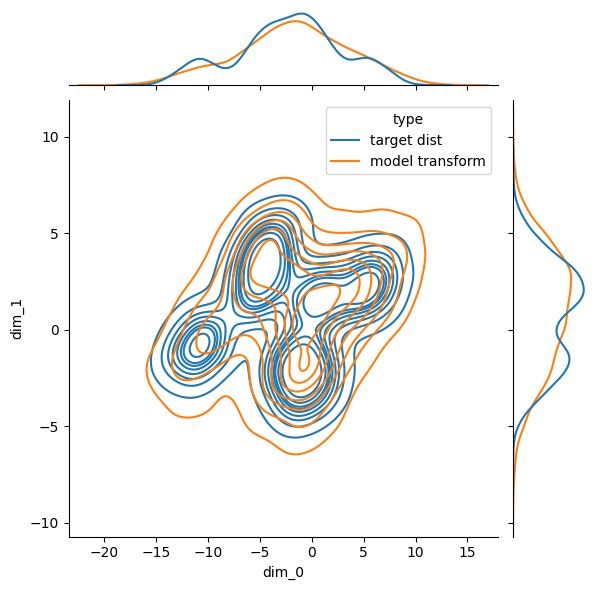

trail: 0 m step: 4 kl_test: 2.166484832763672


  2%|▏         | 100/6000 [00:31<33:45,  2.91it/s]

trail: 0 m step: 5 Loss: 1.9198989868164062  L_n: 1.6883373260498047  kld: 0.023156166076660156 KLD1: 1.614419937133789 KLD2: 0.9010586738586426


  3%|▎         | 200/6000 [01:02<33:20,  2.90it/s]

trail: 0 m step: 5 Loss: 1.8721599578857422  L_n: 1.6351146697998047  kld: 0.02370452880859375 KLD1: 1.6325782537460327 KLD2: 0.8967742919921875


  5%|▌         | 300/6000 [01:33<32:47,  2.90it/s]

trail: 0 m step: 5 Loss: 1.8084592819213867  L_n: 1.5439863204956055  kld: 0.026447296142578125 KLD1: 1.5733270645141602 KLD2: 0.8845438957214355


  7%|▋         | 400/6000 [02:04<32:11,  2.90it/s]

trail: 0 m step: 5 Loss: 1.9080495834350586  L_n: 1.6301679611206055  kld: 0.027788162231445312 KLD1: 1.559333086013794 KLD2: 0.9014402031898499


  8%|▊         | 500/6000 [02:35<31:37,  2.90it/s]

trail: 0 m step: 5 Loss: 1.9084672927856445  L_n: 1.6307191848754883  kld: 0.027774810791015625 KLD1: 1.5860661268234253 KLD2: 0.8971937298774719


 10%|█         | 600/6000 [03:07<31:07,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8514394760131836  L_n: 1.6049432754516602  kld: 0.024649620056152344 KLD1: 1.6203968524932861 KLD2: 0.8937378525733948


 12%|█▏        | 700/6000 [03:38<30:30,  2.90it/s]

trail: 0 m step: 5 Loss: 1.8426275253295898  L_n: 1.517786979675293  kld: 0.03248405456542969 KLD1: 1.5300559997558594 KLD2: 0.8845744132995605


 13%|█▎        | 800/6000 [04:09<29:59,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8230628967285156  L_n: 1.6029739379882812  kld: 0.022008895874023438 KLD1: 1.6309854984283447 KLD2: 0.8799325823783875


 15%|█▌        | 900/6000 [04:40<29:22,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8473501205444336  L_n: 1.6267175674438477  kld: 0.022063255310058594 KLD1: 1.6291241645812988 KLD2: 0.8882671594619751


 17%|█▋        | 1000/6000 [05:12<28:56,  2.88it/s]

trail: 0 m step: 5 Loss: 1.721806526184082  L_n: 1.5160799026489258  kld: 0.020572662353515625 KLD1: 1.6584378480911255 KLD2: 0.8989929556846619


 18%|█▊        | 1100/6000 [05:43<28:12,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8280105590820312  L_n: 1.5571479797363281  kld: 0.027086257934570312 KLD1: 1.587960124015808 KLD2: 0.8604618906974792


 20%|██        | 1200/6000 [06:14<27:40,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8667173385620117  L_n: 1.5759801864624023  kld: 0.029073715209960938 KLD1: 1.5774706602096558 KLD2: 0.8916052579879761


 22%|██▏       | 1300/6000 [06:45<27:00,  2.90it/s]

trail: 0 m step: 5 Loss: 1.83306884765625  L_n: 1.5361518859863281  kld: 0.029691696166992188 KLD1: 1.5521517992019653 KLD2: 0.8912404179573059


 23%|██▎       | 1400/6000 [07:17<26:31,  2.89it/s]

trail: 0 m step: 5 Loss: 1.9154720306396484  L_n: 1.627767562866211  kld: 0.02877044677734375 KLD1: 1.5646517276763916 KLD2: 0.8767529129981995


 25%|██▌       | 1500/6000 [07:48<25:59,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8568735122680664  L_n: 1.5974359512329102  kld: 0.025943756103515625 KLD1: 1.567829966545105 KLD2: 0.9141097664833069


 27%|██▋       | 1600/6000 [08:19<25:25,  2.88it/s]

trail: 0 m step: 5 Loss: 1.875166893005371  L_n: 1.5816354751586914  kld: 0.02935314178466797 KLD1: 1.539898157119751 KLD2: 0.8967657685279846


 28%|██▊       | 1700/6000 [08:50<24:51,  2.88it/s]

trail: 0 m step: 5 Loss: 1.8488130569458008  L_n: 1.5690336227416992  kld: 0.027977943420410156 KLD1: 1.5556920766830444 KLD2: 0.8618245720863342


 30%|███       | 1800/6000 [09:22<24:15,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8311939239501953  L_n: 1.5671405792236328  kld: 0.02640533447265625 KLD1: 1.6007989645004272 KLD2: 0.873660147190094


 32%|███▏      | 1900/6000 [09:53<23:37,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8478631973266602  L_n: 1.5966272354125977  kld: 0.02512359619140625 KLD1: 1.601619839668274 KLD2: 0.8615232110023499


 33%|███▎      | 2000/6000 [10:24<23:03,  2.89it/s]

trail: 0 m step: 5 Loss: 1.867283821105957  L_n: 1.5860357284545898  kld: 0.02812480926513672 KLD1: 1.5635303258895874 KLD2: 0.8703351616859436


 35%|███▌      | 2100/6000 [10:56<22:24,  2.90it/s]

trail: 0 m step: 5 Loss: 1.794281005859375  L_n: 1.5578460693359375  kld: 0.02364349365234375 KLD1: 1.5894958972930908 KLD2: 0.881563663482666


 37%|███▋      | 2200/6000 [11:27<21:50,  2.90it/s]

trail: 0 m step: 5 Loss: 1.8126544952392578  L_n: 1.5350494384765625  kld: 0.02776050567626953 KLD1: 1.5644516944885254 KLD2: 0.8795762658119202


 38%|███▊      | 2300/6000 [11:58<21:14,  2.90it/s]

trail: 0 m step: 5 Loss: 1.8049802780151367  L_n: 1.588486671447754  kld: 0.02164936065673828 KLD1: 1.6246635913848877 KLD2: 0.8878253698348999


 40%|████      | 2400/6000 [12:29<20:43,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8334674835205078  L_n: 1.5659523010253906  kld: 0.02675151824951172 KLD1: 1.5701197385787964 KLD2: 0.8783727288246155


 42%|████▏     | 2500/6000 [13:01<20:11,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8405580520629883  L_n: 1.5656423568725586  kld: 0.02749156951904297 KLD1: 1.564916968345642 KLD2: 0.8826161623001099


 43%|████▎     | 2600/6000 [13:32<19:33,  2.90it/s]

trail: 0 m step: 5 Loss: 1.809370994567871  L_n: 1.5629987716674805  kld: 0.024637222290039062 KLD1: 1.5896960496902466 KLD2: 0.8866578936576843


 45%|████▌     | 2700/6000 [14:03<19:04,  2.88it/s]

trail: 0 m step: 5 Loss: 1.807027816772461  L_n: 1.5418586730957031  kld: 0.02651691436767578 KLD1: 1.5842335224151611 KLD2: 0.8648397922515869


 47%|████▋     | 2800/6000 [14:34<18:27,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8425798416137695  L_n: 1.5689802169799805  kld: 0.027359962463378906 KLD1: 1.5728520154953003 KLD2: 0.8756011724472046


 48%|████▊     | 2900/6000 [15:06<17:49,  2.90it/s]

trail: 0 m step: 5 Loss: 1.8392915725708008  L_n: 1.5569944381713867  kld: 0.028229713439941406 KLD1: 1.5588740110397339 KLD2: 0.8539753556251526


 50%|█████     | 3000/6000 [15:37<17:20,  2.88it/s]

trail: 0 m step: 5 Loss: 1.8304738998413086  L_n: 1.580458641052246  kld: 0.02500152587890625 KLD1: 1.58550226688385 KLD2: 0.8906984329223633


 52%|█████▏    | 3100/6000 [16:08<16:43,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8065385818481445  L_n: 1.5595369338989258  kld: 0.024700164794921875 KLD1: 1.5914983749389648 KLD2: 0.8884199261665344


 53%|█████▎    | 3200/6000 [16:40<16:08,  2.89it/s]

trail: 0 m step: 5 Loss: 1.830820083618164  L_n: 1.56622314453125  kld: 0.026459693908691406 KLD1: 1.5738253593444824 KLD2: 0.8745651841163635


 55%|█████▌    | 3300/6000 [17:11<15:29,  2.90it/s]

trail: 0 m step: 5 Loss: 1.8595094680786133  L_n: 1.5743131637573242  kld: 0.028519630432128906 KLD1: 1.541069507598877 KLD2: 0.8683447241783142


 57%|█████▋    | 3400/6000 [17:42<14:58,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8315191268920898  L_n: 1.5929479598999023  kld: 0.02385711669921875 KLD1: 1.6057664155960083 KLD2: 0.8736127614974976


 58%|█████▊    | 3500/6000 [18:13<14:28,  2.88it/s]

trail: 0 m step: 5 Loss: 1.8121767044067383  L_n: 1.5469598770141602  kld: 0.026521682739257812 KLD1: 1.5637974739074707 KLD2: 0.8733068108558655


 60%|██████    | 3600/6000 [18:45<13:54,  2.88it/s]

trail: 0 m step: 5 Loss: 1.8237228393554688  L_n: 1.5734119415283203  kld: 0.025031089782714844 KLD1: 1.5841561555862427 KLD2: 0.8839126825332642


 62%|██████▏   | 3700/6000 [19:16<13:15,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8705615997314453  L_n: 1.574197769165039  kld: 0.029636383056640625 KLD1: 1.5368643999099731 KLD2: 0.8812427520751953


 63%|██████▎   | 3800/6000 [19:47<12:42,  2.89it/s]

trail: 0 m step: 5 Loss: 1.7822561264038086  L_n: 1.5492162704467773  kld: 0.023303985595703125 KLD1: 1.6078377962112427 KLD2: 0.8754202723503113


 65%|██████▌   | 3900/6000 [20:19<12:07,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8037223815917969  L_n: 1.5376472473144531  kld: 0.026607513427734375 KLD1: 1.564357042312622 KLD2: 0.8711939454078674


 67%|██████▋   | 4000/6000 [20:50<11:31,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8397579193115234  L_n: 1.5877685546875  kld: 0.025198936462402344 KLD1: 1.58577299118042 KLD2: 0.8929187059402466


 68%|██████▊   | 4100/6000 [21:21<10:56,  2.90it/s]

trail: 0 m step: 5 Loss: 1.8136215209960938  L_n: 1.5430831909179688  kld: 0.0270538330078125 KLD1: 1.554283857345581 KLD2: 0.8767611384391785


 70%|███████   | 4200/6000 [21:52<10:21,  2.90it/s]

trail: 0 m step: 5 Loss: 1.860152244567871  L_n: 1.5657529830932617  kld: 0.029439926147460938 KLD1: 1.548546314239502 KLD2: 0.865329384803772


 72%|███████▏  | 4300/6000 [22:24<09:47,  2.89it/s]

trail: 0 m step: 5 Loss: 1.786646842956543  L_n: 1.5162134170532227  kld: 0.02704334259033203 KLD1: 1.5668206214904785 KLD2: 0.8699213862419128


 73%|███████▎  | 4400/6000 [22:55<09:13,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8271188735961914  L_n: 1.5500192642211914  kld: 0.0277099609375 KLD1: 1.555751085281372 KLD2: 0.8728185296058655


 75%|███████▌  | 4500/6000 [23:26<08:36,  2.90it/s]

trail: 0 m step: 5 Loss: 1.904458999633789  L_n: 1.6096115112304688  kld: 0.02948474884033203 KLD1: 1.5411397218704224 KLD2: 0.8627786636352539


 77%|███████▋  | 4600/6000 [23:57<08:05,  2.89it/s]

trail: 0 m step: 5 Loss: 1.906846046447754  L_n: 1.6021757125854492  kld: 0.03046703338623047 KLD1: 1.5271031856536865 KLD2: 0.8703241944313049


 78%|███████▊  | 4700/6000 [24:29<07:28,  2.90it/s]

trail: 0 m step: 5 Loss: 1.8655757904052734  L_n: 1.5757827758789062  kld: 0.02897930145263672 KLD1: 1.5377238988876343 KLD2: 0.8644379377365112


 80%|████████  | 4800/6000 [25:00<06:53,  2.90it/s]

trail: 0 m step: 5 Loss: 1.8994131088256836  L_n: 1.5891351699829102  kld: 0.031027793884277344 KLD1: 1.5319815874099731 KLD2: 0.8969720602035522


 82%|████████▏ | 4900/6000 [25:31<06:20,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8041677474975586  L_n: 1.5478391647338867  kld: 0.025632858276367188 KLD1: 1.5725114345550537 KLD2: 0.8641394376754761


 83%|████████▎ | 5000/6000 [26:02<05:45,  2.89it/s]

trail: 0 m step: 5 Loss: 1.7738008499145508  L_n: 1.5235090255737305  kld: 0.02502918243408203 KLD1: 1.564760446548462 KLD2: 0.880339503288269


 85%|████████▌ | 5100/6000 [26:33<05:10,  2.90it/s]

trail: 0 m step: 5 Loss: 1.8107004165649414  L_n: 1.5487451553344727  kld: 0.026195526123046875 KLD1: 1.5768351554870605 KLD2: 0.8667255640029907


 87%|████████▋ | 5200/6000 [27:05<04:37,  2.88it/s]

trail: 0 m step: 5 Loss: 1.7951765060424805  L_n: 1.5193548202514648  kld: 0.027582168579101562 KLD1: 1.5543742179870605 KLD2: 0.8831093311309814


 88%|████████▊ | 5300/6000 [27:36<04:02,  2.89it/s]

trail: 0 m step: 5 Loss: 1.868112564086914  L_n: 1.5935020446777344  kld: 0.02746105194091797 KLD1: 1.5566174983978271 KLD2: 0.8595612049102783


 90%|█████████ | 5400/6000 [28:07<03:27,  2.90it/s]

trail: 0 m step: 5 Loss: 1.852982521057129  L_n: 1.5847711563110352  kld: 0.026821136474609375 KLD1: 1.5756747722625732 KLD2: 0.8931337594985962


 92%|█████████▏| 5500/6000 [28:39<02:52,  2.90it/s]

trail: 0 m step: 5 Loss: 1.8654088973999023  L_n: 1.5736894607543945  kld: 0.02917194366455078 KLD1: 1.5524805784225464 KLD2: 0.8692829608917236


 93%|█████████▎| 5600/6000 [29:10<02:18,  2.90it/s]

trail: 0 m step: 5 Loss: 1.836165428161621  L_n: 1.5404024124145508  kld: 0.02957630157470703 KLD1: 1.5270423889160156 KLD2: 0.8782581686973572


 95%|█████████▌| 5700/6000 [29:41<01:43,  2.89it/s]

trail: 0 m step: 5 Loss: 1.7554311752319336  L_n: 1.4763479232788086  kld: 0.0279083251953125 KLD1: 1.5492414236068726 KLD2: 0.868905246257782


 97%|█████████▋| 5800/6000 [30:12<01:09,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8025226593017578  L_n: 1.5548057556152344  kld: 0.024771690368652344 KLD1: 1.5892454385757446 KLD2: 0.8702870607376099


 98%|█████████▊| 5900/6000 [30:44<00:34,  2.89it/s]

trail: 0 m step: 5 Loss: 1.8571195602416992  L_n: 1.5802488327026367  kld: 0.02768707275390625 KLD1: 1.5540040731430054 KLD2: 0.863715410232544


100%|██████████| 6000/6000 [31:15<00:00,  3.20it/s]

trail: 0 m step: 5 Loss: 1.885146141052246  L_n: 1.5900506973266602  kld: 0.029509544372558594 KLD1: 1.531261920928955 KLD2: 0.8965343236923218



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


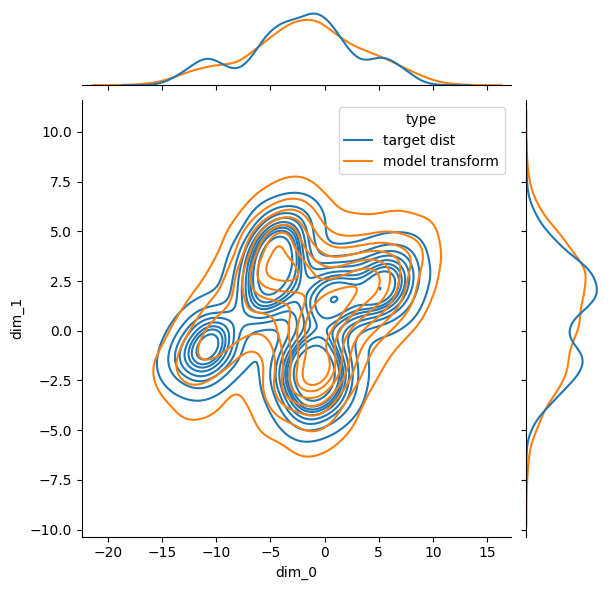

trail: 0 m step: 5 kl_test: 1.5812358856201172


  2%|▏         | 100/6000 [00:31<33:53,  2.90it/s]

trail: 0 m step: 6 Loss: 1.4216136932373047  L_n: 1.2638568878173828  kld: 0.015775680541992188 KLD1: 1.2068294286727905 KLD2: 0.7154687643051147


  3%|▎         | 200/6000 [01:02<33:27,  2.89it/s]

trail: 0 m step: 6 Loss: 1.388235092163086  L_n: 1.2293529510498047  kld: 0.015888214111328125 KLD1: 1.2270201444625854 KLD2: 0.7126869559288025


  5%|▌         | 300/6000 [01:33<32:49,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3349437713623047  L_n: 1.1530303955078125  kld: 0.01819133758544922 KLD1: 1.1810312271118164 KLD2: 0.7050646543502808


  7%|▋         | 400/6000 [02:04<32:18,  2.89it/s]

trail: 0 m step: 6 Loss: 1.4116525650024414  L_n: 1.2142038345336914  kld: 0.019744873046875 KLD1: 1.1670488119125366 KLD2: 0.7175828814506531


  8%|▊         | 500/6000 [02:36<31:37,  2.90it/s]

trail: 0 m step: 6 Loss: 1.4172496795654297  L_n: 1.2266483306884766  kld: 0.019060134887695312 KLD1: 1.1900347471237183 KLD2: 0.7156912684440613


 10%|█         | 600/6000 [03:07<31:01,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3755426406860352  L_n: 1.208115577697754  kld: 0.016742706298828125 KLD1: 1.211513876914978 KLD2: 0.7115587592124939


 12%|█▏        | 700/6000 [03:38<30:33,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3599367141723633  L_n: 1.129948616027832  kld: 0.022998809814453125 KLD1: 1.1541577577590942 KLD2: 0.7075868248939514


 13%|█▎        | 800/6000 [04:09<29:53,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3535032272338867  L_n: 1.2076482772827148  kld: 0.014585494995117188 KLD1: 1.232237458229065 KLD2: 0.7006674408912659


 15%|█▌        | 900/6000 [04:41<29:24,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3692007064819336  L_n: 1.2222490310668945  kld: 0.014695167541503906 KLD1: 1.2108372449874878 KLD2: 0.7078242897987366


 17%|█▋        | 1000/6000 [05:12<28:50,  2.89it/s]

trail: 0 m step: 6 Loss: 1.270223617553711  L_n: 1.1368904113769531  kld: 0.013333320617675781 KLD1: 1.2473161220550537 KLD2: 0.7220626473426819


 18%|█▊        | 1100/6000 [05:43<28:09,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3462438583374023  L_n: 1.1643686294555664  kld: 0.018187522888183594 KLD1: 1.1934168338775635 KLD2: 0.6855238676071167


 20%|██        | 1200/6000 [06:14<27:39,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3815832138061523  L_n: 1.1774110794067383  kld: 0.020417213439941406 KLD1: 1.1870242357254028 KLD2: 0.712253987789154


 22%|██▏       | 1300/6000 [06:46<27:08,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3665523529052734  L_n: 1.1603107452392578  kld: 0.020624160766601562 KLD1: 1.163548231124878 KLD2: 0.7114909887313843


 23%|██▎       | 1400/6000 [07:17<26:34,  2.88it/s]

trail: 0 m step: 6 Loss: 1.431269645690918  L_n: 1.2339448928833008  kld: 0.01973247528076172 KLD1: 1.1708940267562866 KLD2: 0.6997328400611877


 25%|██▌       | 1500/6000 [07:48<25:55,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3835182189941406  L_n: 1.2069358825683594  kld: 0.017658233642578125 KLD1: 1.1831645965576172 KLD2: 0.7324411869049072


 27%|██▋       | 1600/6000 [08:19<25:24,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3928565979003906  L_n: 1.1925182342529297  kld: 0.020033836364746094 KLD1: 1.1594839096069336 KLD2: 0.7177560925483704


 28%|██▊       | 1700/6000 [08:51<24:49,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3655014038085938  L_n: 1.17327880859375  kld: 0.019222259521484375 KLD1: 1.1626265048980713 KLD2: 0.6846424341201782


 30%|███       | 1800/6000 [09:22<24:12,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3559465408325195  L_n: 1.1714391708374023  kld: 0.01845073699951172 KLD1: 1.1972862482070923 KLD2: 0.6966254711151123


 32%|███▏      | 1900/6000 [09:53<23:37,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3663597106933594  L_n: 1.1962051391601562  kld: 0.017015457153320312 KLD1: 1.205099105834961 KLD2: 0.6855905055999756


 33%|███▎      | 2000/6000 [10:24<23:00,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3870830535888672  L_n: 1.1865921020507812  kld: 0.020049095153808594 KLD1: 1.1678544282913208 KLD2: 0.6926820874214172


 35%|███▌      | 2100/6000 [10:56<22:24,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3269844055175781  L_n: 1.1708011627197266  kld: 0.015618324279785156 KLD1: 1.1937569379806519 KLD2: 0.7038716673851013


 37%|███▋      | 2200/6000 [11:27<21:56,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3481922149658203  L_n: 1.1549968719482422  kld: 0.019319534301757812 KLD1: 1.1705306768417358 KLD2: 0.7021124958992004


 38%|███▊      | 2300/6000 [11:58<21:23,  2.88it/s]

trail: 0 m step: 6 Loss: 1.3400535583496094  L_n: 1.197336196899414  kld: 0.014271736145019531 KLD1: 1.216171383857727 KLD2: 0.7081916928291321


 40%|████      | 2400/6000 [12:30<20:45,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3573417663574219  L_n: 1.1759529113769531  kld: 0.018138885498046875 KLD1: 1.180709719657898 KLD2: 0.6995049715042114


 42%|████▏     | 2500/6000 [13:01<20:15,  2.88it/s]

trail: 0 m step: 6 Loss: 1.3649349212646484  L_n: 1.1760311126708984  kld: 0.018890380859375 KLD1: 1.171748161315918 KLD2: 0.7036963701248169


 43%|████▎     | 2600/6000 [13:32<19:33,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3373279571533203  L_n: 1.1741065979003906  kld: 0.01632213592529297 KLD1: 1.1935107707977295 KLD2: 0.7092064023017883


 45%|████▌     | 2700/6000 [14:04<18:58,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3373823165893555  L_n: 1.156661033630371  kld: 0.018072128295898438 KLD1: 1.1915494203567505 KLD2: 0.6892648339271545


 47%|████▋     | 2800/6000 [14:35<18:24,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3668699264526367  L_n: 1.1799688339233398  kld: 0.018690109252929688 KLD1: 1.1879169940948486 KLD2: 0.6987215876579285


 48%|████▊     | 2900/6000 [15:06<17:50,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3654098510742188  L_n: 1.167856216430664  kld: 0.01975536346435547 KLD1: 1.1657158136367798 KLD2: 0.6773781776428223


 50%|█████     | 3000/6000 [15:37<17:17,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3505430221557617  L_n: 1.1850042343139648  kld: 0.016553878784179688 KLD1: 1.199661374092102 KLD2: 0.7128552794456482


 52%|█████▏    | 3100/6000 [16:08<16:42,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3300886154174805  L_n: 1.1663713455200195  kld: 0.016371726989746094 KLD1: 1.205233097076416 KLD2: 0.7110269069671631


 53%|█████▎    | 3200/6000 [16:40<16:06,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3494949340820312  L_n: 1.1725883483886719  kld: 0.017690658569335938 KLD1: 1.184604287147522 KLD2: 0.6975880861282349


 55%|█████▌    | 3300/6000 [17:11<15:36,  2.88it/s]

trail: 0 m step: 6 Loss: 1.3810806274414062  L_n: 1.1792831420898438  kld: 0.02017974853515625 KLD1: 1.1583739519119263 KLD2: 0.6909565329551697


 57%|█████▋    | 3400/6000 [17:42<15:02,  2.88it/s]

trail: 0 m step: 6 Loss: 1.3608598709106445  L_n: 1.2010908126831055  kld: 0.015976905822753906 KLD1: 1.2148181200027466 KLD2: 0.6974071264266968


 58%|█████▊    | 3500/6000 [18:14<14:23,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3451776504516602  L_n: 1.1614713668823242  kld: 0.018370628356933594 KLD1: 1.168986439704895 KLD2: 0.6965419054031372


 60%|██████    | 3600/6000 [18:45<13:49,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3450536727905273  L_n: 1.177302360534668  kld: 0.016775131225585938 KLD1: 1.199276089668274 KLD2: 0.7045630812644958


 62%|██████▏   | 3700/6000 [19:16<13:15,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3981590270996094  L_n: 1.18890380859375  kld: 0.020925521850585938 KLD1: 1.1474038362503052 KLD2: 0.703052818775177


 63%|██████▎   | 3800/6000 [19:47<12:42,  2.88it/s]

trail: 0 m step: 6 Loss: 1.3117265701293945  L_n: 1.1593198776245117  kld: 0.015240669250488281 KLD1: 1.2159430980682373 KLD2: 0.6979884505271912


 65%|██████▌   | 3900/6000 [20:19<12:04,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3301410675048828  L_n: 1.1477031707763672  kld: 0.018243789672851562 KLD1: 1.1659386157989502 KLD2: 0.6949161887168884


 67%|██████▋   | 4000/6000 [20:50<11:32,  2.89it/s]

trail: 0 m step: 6 Loss: 1.364912986755371  L_n: 1.197648048400879  kld: 0.01672649383544922 KLD1: 1.1950496435165405 KLD2: 0.7151980400085449


 68%|██████▊   | 4100/6000 [21:21<10:55,  2.90it/s]

trail: 0 m step: 6 Loss: 1.355093002319336  L_n: 1.1654071807861328  kld: 0.018968582153320312 KLD1: 1.160320520401001 KLD2: 0.6993411183357239


 70%|███████   | 4200/6000 [21:52<10:22,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3772001266479492  L_n: 1.175917625427246  kld: 0.020128250122070312 KLD1: 1.1612582206726074 KLD2: 0.6882899403572083


 72%|███████▏  | 4300/6000 [22:24<09:45,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3242559432983398  L_n: 1.1419897079467773  kld: 0.01822662353515625 KLD1: 1.181001901626587 KLD2: 0.6942382454872131


 73%|███████▎  | 4400/6000 [22:55<09:12,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3624391555786133  L_n: 1.1709222793579102  kld: 0.019151687622070312 KLD1: 1.1696809530258179 KLD2: 0.6955245137214661


 75%|███████▌  | 4500/6000 [23:26<08:39,  2.88it/s]

trail: 0 m step: 6 Loss: 1.4207067489624023  L_n: 1.215590476989746  kld: 0.020511627197265625 KLD1: 1.1519889831542969 KLD2: 0.686538577079773


 77%|███████▋  | 4600/6000 [23:58<08:04,  2.89it/s]

trail: 0 m step: 6 Loss: 1.4232063293457031  L_n: 1.2089157104492188  kld: 0.021429061889648438 KLD1: 1.1496329307556152 KLD2: 0.693979799747467


 78%|███████▊  | 4700/6000 [24:29<07:30,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3847551345825195  L_n: 1.186295509338379  kld: 0.019845962524414062 KLD1: 1.1514198780059814 KLD2: 0.6887006759643555


 80%|████████  | 4800/6000 [25:00<06:55,  2.89it/s]

trail: 0 m step: 6 Loss: 1.4133663177490234  L_n: 1.1938400268554688  kld: 0.02195262908935547 KLD1: 1.1416956186294556 KLD2: 0.7189905047416687


 82%|████████▏ | 4900/6000 [25:31<06:20,  2.89it/s]

trail: 0 m step: 6 Loss: 1.338576316833496  L_n: 1.1631383895874023  kld: 0.017543792724609375 KLD1: 1.178814172744751 KLD2: 0.6883132457733154


 83%|████████▎ | 5000/6000 [26:03<05:45,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3099746704101562  L_n: 1.1408023834228516  kld: 0.01691722869873047 KLD1: 1.172881841659546 KLD2: 0.7030789852142334


 85%|████████▌ | 5100/6000 [26:34<05:10,  2.90it/s]

trail: 0 m step: 6 Loss: 1.344721794128418  L_n: 1.1655359268188477  kld: 0.01791858673095703 KLD1: 1.1710160970687866 KLD2: 0.6901485919952393


 87%|████████▋ | 5200/6000 [27:05<04:35,  2.90it/s]

trail: 0 m step: 6 Loss: 1.319112777709961  L_n: 1.133565902709961  kld: 0.0185546875 KLD1: 1.1747653484344482 KLD2: 0.7064418792724609


 88%|████████▊ | 5300/6000 [27:36<04:02,  2.89it/s]

trail: 0 m step: 6 Loss: 1.389653205871582  L_n: 1.2041826248168945  kld: 0.01854705810546875 KLD1: 1.1657353639602661 KLD2: 0.6832460761070251


 90%|█████████ | 5400/6000 [28:08<03:27,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3725433349609375  L_n: 1.1931095123291016  kld: 0.017943382263183594 KLD1: 1.185838222503662 KLD2: 0.7146943211555481


 92%|█████████▏| 5500/6000 [28:39<02:52,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3889827728271484  L_n: 1.1881484985351562  kld: 0.02008342742919922 KLD1: 1.1674606800079346 KLD2: 0.6934027075767517


 93%|█████████▎| 5600/6000 [29:10<02:18,  2.90it/s]

trail: 0 m step: 6 Loss: 1.3587360382080078  L_n: 1.1560420989990234  kld: 0.020269393920898438 KLD1: 1.1484497785568237 KLD2: 0.7013271450996399


 95%|█████████▌| 5700/6000 [29:41<01:43,  2.89it/s]

trail: 0 m step: 6 Loss: 1.295633316040039  L_n: 1.1022663116455078  kld: 0.019336700439453125 KLD1: 1.155132532119751 KLD2: 0.6928365230560303


 97%|█████████▋| 5800/6000 [30:13<01:08,  2.91it/s]

trail: 0 m step: 6 Loss: 1.3335657119750977  L_n: 1.1688756942749023  kld: 0.01646900177001953 KLD1: 1.1913673877716064 KLD2: 0.6944072246551514


 98%|█████████▊| 5900/6000 [30:44<00:34,  2.89it/s]

trail: 0 m step: 6 Loss: 1.3744745254516602  L_n: 1.1865911483764648  kld: 0.01878833770751953 KLD1: 1.1754448413848877 KLD2: 0.6876040101051331


100%|██████████| 6000/6000 [31:15<00:00,  3.20it/s]

trail: 0 m step: 6 Loss: 1.4017448425292969  L_n: 1.1955795288085938  kld: 0.020616531372070312 KLD1: 1.1440274715423584 KLD2: 0.7184191346168518



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


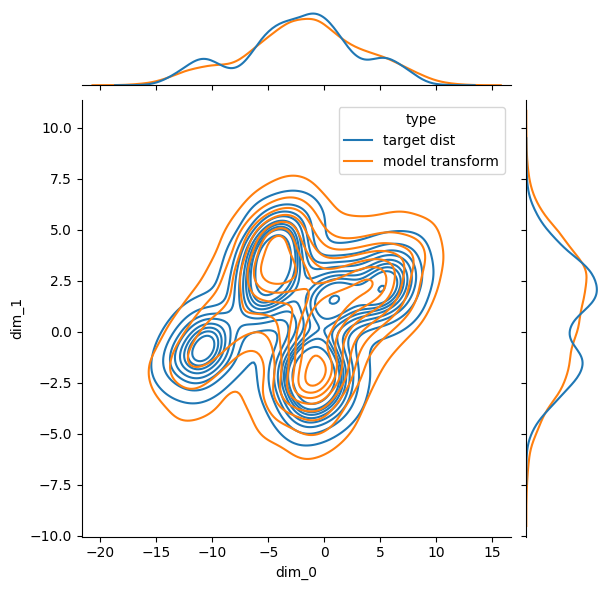

trail: 0 m step: 6 kl_test: 1.1926565170288086


  2%|▏         | 100/6000 [00:31<34:01,  2.89it/s]

trail: 0 m step: 7 Loss: 1.082021713256836  L_n: 0.9708900451660156  kld: 0.011113166809082031 KLD1: 0.9303708672523499 KLD2: 0.5761451721191406


  3%|▎         | 200/6000 [01:02<33:25,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0633916854858398  L_n: 0.9511728286743164  kld: 0.011221885681152344 KLD1: 0.9423423409461975 KLD2: 0.5747917890548706


  5%|▌         | 300/6000 [01:33<32:46,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0223846435546875  L_n: 0.8911685943603516  kld: 0.013121604919433594 KLD1: 0.9143819808959961 KLD2: 0.5697099566459656


  7%|▋         | 400/6000 [02:05<32:15,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0815200805664062  L_n: 0.9382114410400391  kld: 0.014330863952636719 KLD1: 0.8953139185905457 KLD2: 0.5794453024864197


  8%|▊         | 500/6000 [02:36<31:38,  2.90it/s]

trail: 0 m step: 7 Loss: 1.086557388305664  L_n: 0.9480361938476562  kld: 0.013852119445800781 KLD1: 0.9210268259048462 KLD2: 0.5796730518341064


 10%|█         | 600/6000 [03:07<31:01,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0503978729248047  L_n: 0.9309501647949219  kld: 0.011944770812988281 KLD1: 0.9336495995521545 KLD2: 0.5753764510154724


 12%|█▏        | 700/6000 [03:38<30:31,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0346288681030273  L_n: 0.8663625717163086  kld: 0.016826629638671875 KLD1: 0.887508749961853 KLD2: 0.5736481547355652


 13%|█▎        | 800/6000 [04:09<29:56,  2.89it/s]

trail: 0 m step: 7 Loss: 1.037759780883789  L_n: 0.9368228912353516  kld: 0.01009368896484375 KLD1: 0.9442154765129089 KLD2: 0.5665534734725952


 15%|█▌        | 900/6000 [04:41<29:20,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0343294143676758  L_n: 0.9330873489379883  kld: 0.01012420654296875 KLD1: 0.939079761505127 KLD2: 0.5715383887290955


 17%|█▋        | 1000/6000 [05:12<28:47,  2.89it/s]

trail: 0 m step: 7 Loss: 0.9689006805419922  L_n: 0.8766994476318359  kld: 0.009220123291015625 KLD1: 0.9631292819976807 KLD2: 0.5857607126235962


 18%|█▊        | 1100/6000 [05:43<28:08,  2.90it/s]

trail: 0 m step: 7 Loss: 1.016042709350586  L_n: 0.8895378112792969  kld: 0.012650489807128906 KLD1: 0.9234248995780945 KLD2: 0.552290141582489


 20%|██        | 1200/6000 [06:14<27:36,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0568323135375977  L_n: 0.9066953659057617  kld: 0.015013694763183594 KLD1: 0.9050325751304626 KLD2: 0.5765641331672668


 22%|██▏       | 1300/6000 [06:45<27:06,  2.89it/s]

trail: 0 m step: 7 Loss: 1.034541130065918  L_n: 0.8857870101928711  kld: 0.014875411987304688 KLD1: 0.8926945328712463 KLD2: 0.5761129856109619


 23%|██▎       | 1400/6000 [07:17<26:29,  2.89it/s]

trail: 0 m step: 7 Loss: 1.1028766632080078  L_n: 0.9580516815185547  kld: 0.014482498168945312 KLD1: 0.9059878587722778 KLD2: 0.5656118988990784


 25%|██▌       | 1500/6000 [07:48<25:51,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0648736953735352  L_n: 0.934840202331543  kld: 0.013003349304199219 KLD1: 0.9146450757980347 KLD2: 0.5959991812705994


 27%|██▋       | 1600/6000 [08:19<25:20,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0550260543823242  L_n: 0.917658805847168  kld: 0.013736724853515625 KLD1: 0.8946502804756165 KLD2: 0.5817058086395264


 28%|██▊       | 1700/6000 [08:50<24:44,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0429248809814453  L_n: 0.9033641815185547  kld: 0.013956069946289062 KLD1: 0.8825148344039917 KLD2: 0.5512237548828125


 30%|███       | 1800/6000 [09:21<24:12,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0406904220581055  L_n: 0.9009675979614258  kld: 0.013972282409667969 KLD1: 0.9227263331413269 KLD2: 0.5632966160774231


 32%|███▏      | 1900/6000 [09:53<23:38,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0463409423828125  L_n: 0.9230403900146484  kld: 0.012330055236816406 KLD1: 0.9278210997581482 KLD2: 0.5527711510658264


 33%|███▎      | 2000/6000 [10:24<22:55,  2.91it/s]

trail: 0 m step: 7 Loss: 1.0493040084838867  L_n: 0.905766487121582  kld: 0.014353752136230469 KLD1: 0.8923453688621521 KLD2: 0.5600712299346924


 35%|███▌      | 2100/6000 [10:55<22:25,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0040283203125  L_n: 0.8953285217285156  kld: 0.010869979858398438 KLD1: 0.9184596538543701 KLD2: 0.5693483948707581


 37%|███▋      | 2200/6000 [11:26<21:57,  2.88it/s]

trail: 0 m step: 7 Loss: 1.0274667739868164  L_n: 0.8889074325561523  kld: 0.013855934143066406 KLD1: 0.9032976627349854 KLD2: 0.5689731240272522


 38%|███▊      | 2300/6000 [11:58<21:17,  2.90it/s]

trail: 0 m step: 7 Loss: 1.019388198852539  L_n: 0.9192428588867188  kld: 0.010014533996582031 KLD1: 0.9442140460014343 KLD2: 0.5727373361587524


 40%|████      | 2400/6000 [12:29<20:42,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0359086990356445  L_n: 0.9080686569213867  kld: 0.012784004211425781 KLD1: 0.9111605286598206 KLD2: 0.5658584833145142


 42%|████▏     | 2500/6000 [13:00<20:11,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0366277694702148  L_n: 0.9012060165405273  kld: 0.01354217529296875 KLD1: 0.9025764465332031 KLD2: 0.5689492225646973


 43%|████▎     | 2600/6000 [13:31<19:34,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0166921615600586  L_n: 0.9015073776245117  kld: 0.011518478393554688 KLD1: 0.9199017286300659 KLD2: 0.5738466382026672


 45%|████▌     | 2700/6000 [14:02<18:59,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0189743041992188  L_n: 0.8926029205322266  kld: 0.012637138366699219 KLD1: 0.9195194840431213 KLD2: 0.5560771226882935


 47%|████▋     | 2800/6000 [14:34<18:25,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0435419082641602  L_n: 0.9078531265258789  kld: 0.013568878173828125 KLD1: 0.9134913682937622 KLD2: 0.5642557740211487


 48%|████▊     | 2900/6000 [15:05<17:50,  2.90it/s]

trail: 0 m step: 7 Loss: 1.036555290222168  L_n: 0.8947248458862305  kld: 0.01418304443359375 KLD1: 0.8945014476776123 KLD2: 0.5454837679862976


 50%|█████     | 3000/6000 [15:36<17:18,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0308170318603516  L_n: 0.9103107452392578  kld: 0.012050628662109375 KLD1: 0.9208210706710815 KLD2: 0.5788909196853638


 52%|█████▏    | 3100/6000 [16:08<16:43,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0105304718017578  L_n: 0.8929424285888672  kld: 0.011758804321289062 KLD1: 0.9254855513572693 KLD2: 0.575420618057251


 53%|█████▎    | 3200/6000 [16:39<16:10,  2.88it/s]

trail: 0 m step: 7 Loss: 1.029597282409668  L_n: 0.9064207077026367  kld: 0.012317657470703125 KLD1: 0.9100819826126099 KLD2: 0.5645065903663635


 55%|█████▌    | 3300/6000 [17:10<15:34,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0464181900024414  L_n: 0.9020605087280273  kld: 0.014435768127441406 KLD1: 0.894267737865448 KLD2: 0.5588587522506714


 57%|█████▋    | 3400/6000 [17:41<15:00,  2.89it/s]

trail: 0 m step: 7 Loss: 1.041956901550293  L_n: 0.9273443222045898  kld: 0.011461257934570312 KLD1: 0.9349396228790283 KLD2: 0.5618775486946106


 58%|█████▊    | 3500/6000 [18:13<14:23,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0234804153442383  L_n: 0.8937902450561523  kld: 0.012969017028808594 KLD1: 0.8944858312606812 KLD2: 0.5640472769737244


 60%|██████    | 3600/6000 [18:44<13:50,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0258054733276367  L_n: 0.9105825424194336  kld: 0.011522293090820312 KLD1: 0.9301987886428833 KLD2: 0.570540189743042


 62%|██████▏   | 3700/6000 [19:15<13:15,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0679702758789062  L_n: 0.9120063781738281  kld: 0.015596389770507812 KLD1: 0.8769975304603577 KLD2: 0.56749427318573


 63%|██████▎   | 3800/6000 [19:47<12:41,  2.89it/s]

trail: 0 m step: 7 Loss: 0.9994392395019531  L_n: 0.8915786743164062  kld: 0.010786056518554688 KLD1: 0.9300447106361389 KLD2: 0.5630217790603638


 65%|██████▌   | 3900/6000 [20:18<12:06,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0154027938842773  L_n: 0.8855504989624023  kld: 0.0129852294921875 KLD1: 0.9007989168167114 KLD2: 0.5615078806877136


 67%|██████▋   | 4000/6000 [20:49<11:29,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0433168411254883  L_n: 0.9252138137817383  kld: 0.011810302734375 KLD1: 0.9190664887428284 KLD2: 0.5799496173858643


 68%|██████▊   | 4100/6000 [21:20<10:55,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0336694717407227  L_n: 0.8969030380249023  kld: 0.013676643371582031 KLD1: 0.8854098320007324 KLD2: 0.56534343957901


 70%|███████   | 4200/6000 [21:52<10:22,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0506105422973633  L_n: 0.905308723449707  kld: 0.014530181884765625 KLD1: 0.8876116871833801 KLD2: 0.5553435683250427


 72%|███████▏  | 4300/6000 [22:23<09:47,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0046052932739258  L_n: 0.8755922317504883  kld: 0.01290130615234375 KLD1: 0.9111238121986389 KLD2: 0.5616487860679626


 73%|███████▎  | 4400/6000 [22:54<09:12,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0428686141967773  L_n: 0.9029455184936523  kld: 0.0139923095703125 KLD1: 0.8976093530654907 KLD2: 0.5624824166297913


 75%|███████▌  | 4500/6000 [23:26<08:38,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0817174911499023  L_n: 0.9348611831665039  kld: 0.014685630798339844 KLD1: 0.8869933485984802 KLD2: 0.5532572269439697


 77%|███████▋  | 4600/6000 [23:57<08:02,  2.90it/s]

trail: 0 m step: 7 Loss: 1.088937759399414  L_n: 0.9317531585693359  kld: 0.015718460083007812 KLD1: 0.8885518312454224 KLD2: 0.5607905387878418


 78%|███████▊  | 4700/6000 [24:28<07:29,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0488882064819336  L_n: 0.9071531295776367  kld: 0.014173507690429688 KLD1: 0.8827831745147705 KLD2: 0.5567352175712585


 80%|████████  | 4800/6000 [24:59<06:55,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0756187438964844  L_n: 0.9159641265869141  kld: 0.01596546173095703 KLD1: 0.8785527944564819 KLD2: 0.584320604801178


 82%|████████▏ | 4900/6000 [25:31<06:20,  2.89it/s]

trail: 0 m step: 7 Loss: 1.016432762145996  L_n: 0.8935613632202148  kld: 0.012287139892578125 KLD1: 0.9053589701652527 KLD2: 0.5559263825416565


 83%|████████▎ | 5000/6000 [26:02<05:45,  2.89it/s]

trail: 0 m step: 7 Loss: 0.9973049163818359  L_n: 0.8782577514648438  kld: 0.011904716491699219 KLD1: 0.90097576379776 KLD2: 0.5687597990036011


 85%|████████▌ | 5100/6000 [26:33<05:11,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0277099609375  L_n: 0.9012432098388672  kld: 0.012646675109863281 KLD1: 0.8951237797737122 KLD2: 0.5566709041595459


 87%|████████▋ | 5200/6000 [27:04<04:36,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0021495819091797  L_n: 0.8698844909667969  kld: 0.013226509094238281 KLD1: 0.908351719379425 KLD2: 0.5715258121490479


 88%|████████▊ | 5300/6000 [27:36<04:02,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0655498504638672  L_n: 0.9338760375976562  kld: 0.013167381286621094 KLD1: 0.893217146396637 KLD2: 0.5497156381607056


 90%|█████████ | 5400/6000 [28:07<03:27,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0454931259155273  L_n: 0.9189882278442383  kld: 0.012650489807128906 KLD1: 0.9175679683685303 KLD2: 0.5803148150444031


 92%|█████████▏| 5500/6000 [28:38<02:52,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0609683990478516  L_n: 0.91729736328125  kld: 0.014367103576660156 KLD1: 0.894653856754303 KLD2: 0.5604859590530396


 93%|█████████▎| 5600/6000 [29:10<02:18,  2.89it/s]

trail: 0 m step: 7 Loss: 1.0362319946289062  L_n: 0.8932571411132812  kld: 0.0142974853515625 KLD1: 0.8878558278083801 KLD2: 0.5673674941062927


 95%|█████████▌| 5700/6000 [29:41<01:43,  2.89it/s]

trail: 0 m step: 7 Loss: 0.9856014251708984  L_n: 0.8460788726806641  kld: 0.013952255249023438 KLD1: 0.8802311420440674 KLD2: 0.5593246221542358


 97%|█████████▋| 5800/6000 [30:12<01:08,  2.90it/s]

trail: 0 m step: 7 Loss: 1.0202159881591797  L_n: 0.9004249572753906  kld: 0.011979103088378906 KLD1: 0.9065771102905273 KLD2: 0.55973219871521


 98%|█████████▊| 5900/6000 [30:43<00:34,  2.89it/s]

trail: 0 m step: 7 Loss: 1.042923927307129  L_n: 0.9101057052612305  kld: 0.013281822204589844 KLD1: 0.9050403833389282 KLD2: 0.5552290678024292


100%|██████████| 6000/6000 [31:15<00:00,  3.20it/s]

trail: 0 m step: 7 Loss: 1.0760488510131836  L_n: 0.9263315200805664  kld: 0.014971733093261719 KLD1: 0.8750779032707214 KLD2: 0.5839847922325134



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


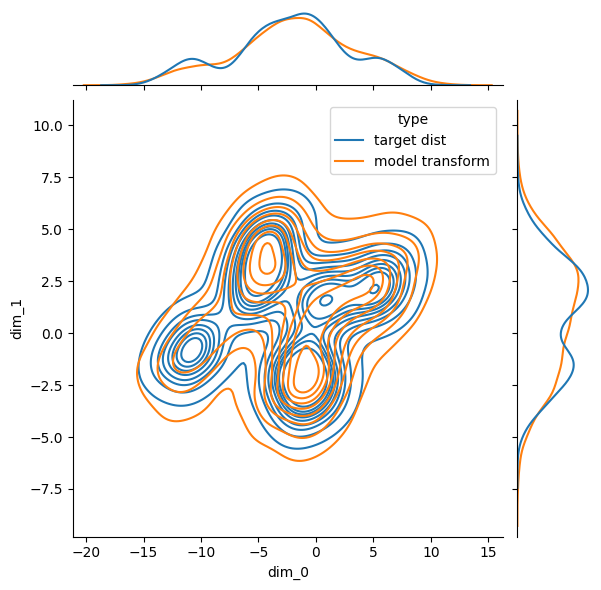

trail: 0 m step: 7 kl_test: 0.9226274490356445


  2%|▏         | 100/6000 [00:31<33:46,  2.91it/s]

trail: 0 m step: 8 Loss: 0.8460931777954102  L_n: 0.7623701095581055  kld: 0.008372306823730469 KLD1: 0.7226717472076416 KLD2: 0.46980488300323486


  3%|▎         | 200/6000 [01:02<33:20,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8292169570922852  L_n: 0.7486028671264648  kld: 0.008061408996582031 KLD1: 0.7411744594573975 KLD2: 0.4687410891056061


  5%|▌         | 300/6000 [01:33<32:43,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8010091781616211  L_n: 0.6988420486450195  kld: 0.010216712951660156 KLD1: 0.7142875790596008 KLD2: 0.46597820520401


  7%|▋         | 400/6000 [02:04<32:13,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8488874435424805  L_n: 0.7395391464233398  kld: 0.010934829711914062 KLD1: 0.6995196342468262 KLD2: 0.4749492108821869


  8%|▊         | 500/6000 [02:35<31:36,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8483600616455078  L_n: 0.7435703277587891  kld: 0.010478973388671875 KLD1: 0.7179665565490723 KLD2: 0.4748435914516449


 10%|█         | 600/6000 [03:06<30:59,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8222627639770508  L_n: 0.7339048385620117  kld: 0.008835792541503906 KLD1: 0.7320494651794434 KLD2: 0.47079265117645264


 12%|█▏        | 700/6000 [03:38<30:27,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8148870468139648  L_n: 0.6777200698852539  kld: 0.013716697692871094 KLD1: 0.7029100060462952 KLD2: 0.4685675799846649


 13%|█▎        | 800/6000 [04:09<29:58,  2.89it/s]

trail: 0 m step: 8 Loss: 0.8126621246337891  L_n: 0.738494873046875  kld: 0.007416725158691406 KLD1: 0.7350060343742371 KLD2: 0.46341854333877563


 15%|█▌        | 900/6000 [04:40<29:20,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8064775466918945  L_n: 0.7333402633666992  kld: 0.007313728332519531 KLD1: 0.7342095375061035 KLD2: 0.4694061279296875


 17%|█▋        | 1000/6000 [05:12<28:43,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7478456497192383  L_n: 0.6885843276977539  kld: 0.0059261322021484375 KLD1: 0.7644407749176025 KLD2: 0.48370712995529175


 18%|█▊        | 1100/6000 [05:43<28:12,  2.89it/s]

trail: 0 m step: 8 Loss: 0.791259765625  L_n: 0.6963977813720703  kld: 0.009486198425292969 KLD1: 0.7265775203704834 KLD2: 0.45191052556037903


 20%|██        | 1200/6000 [06:14<27:31,  2.91it/s]

trail: 0 m step: 8 Loss: 0.8314237594604492  L_n: 0.7147035598754883  kld: 0.011672019958496094 KLD1: 0.7152726054191589 KLD2: 0.4721408188343048


 22%|██▏       | 1300/6000 [06:45<27:07,  2.89it/s]

trail: 0 m step: 8 Loss: 0.8041200637817383  L_n: 0.6929693222045898  kld: 0.011115074157714844 KLD1: 0.7038348317146301 KLD2: 0.4729360342025757


 23%|██▎       | 1400/6000 [07:17<26:27,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8649368286132812  L_n: 0.7550449371337891  kld: 0.010989189147949219 KLD1: 0.7089055776596069 KLD2: 0.4624166786670685


 25%|██▌       | 1500/6000 [07:48<25:51,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8310136795043945  L_n: 0.7324419021606445  kld: 0.009857177734375 KLD1: 0.7157440185546875 KLD2: 0.49037089943885803


 27%|██▋       | 1600/6000 [08:19<25:18,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8253164291381836  L_n: 0.7262582778930664  kld: 0.009905815124511719 KLD1: 0.71074378490448 KLD2: 0.47682487964630127


 28%|██▊       | 1700/6000 [08:50<24:46,  2.89it/s]

trail: 0 m step: 8 Loss: 0.8078279495239258  L_n: 0.7043924331665039  kld: 0.010343551635742188 KLD1: 0.6960851550102234 KLD2: 0.4510005712509155


 30%|███       | 1800/6000 [09:21<24:09,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8131074905395508  L_n: 0.7126569747924805  kld: 0.010045051574707031 KLD1: 0.7324857115745544 KLD2: 0.4615059494972229


 32%|███▏      | 1900/6000 [09:53<23:33,  2.90it/s]

trail: 0 m step: 8 Loss: 0.815913200378418  L_n: 0.7231969833374023  kld: 0.009271621704101562 KLD1: 0.7245432734489441 KLD2: 0.45125672221183777


 33%|███▎      | 2000/6000 [10:24<23:00,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8309898376464844  L_n: 0.7222805023193359  kld: 0.010870933532714844 KLD1: 0.6991117000579834 KLD2: 0.4575493037700653


 35%|███▌      | 2100/6000 [10:55<22:24,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7804031372070312  L_n: 0.7027835845947266  kld: 0.007761955261230469 KLD1: 0.7188775539398193 KLD2: 0.46550452709198


 37%|███▋      | 2200/6000 [11:26<21:51,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7982254028320312  L_n: 0.6956005096435547  kld: 0.010262489318847656 KLD1: 0.7104489803314209 KLD2: 0.4668325185775757


 38%|███▊      | 2300/6000 [11:57<21:17,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7915897369384766  L_n: 0.7192916870117188  kld: 0.007229804992675781 KLD1: 0.7421029806137085 KLD2: 0.4692247807979584


 40%|████      | 2400/6000 [12:29<20:39,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8089656829833984  L_n: 0.7171459197998047  kld: 0.009181976318359375 KLD1: 0.7204455137252808 KLD2: 0.4632057547569275


 42%|████▏     | 2500/6000 [13:00<20:08,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8138198852539062  L_n: 0.7131881713867188  kld: 0.01006317138671875 KLD1: 0.7104322910308838 KLD2: 0.46724769473075867


 43%|████▎     | 2600/6000 [13:31<19:32,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7856721878051758  L_n: 0.7017107009887695  kld: 0.008396148681640625 KLD1: 0.7241562604904175 KLD2: 0.47153857350349426


 45%|████▌     | 2700/6000 [14:02<18:58,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7944107055664062  L_n: 0.7040882110595703  kld: 0.009032249450683594 KLD1: 0.7216092944145203 KLD2: 0.4557143449783325


 47%|████▋     | 2800/6000 [14:34<18:18,  2.91it/s]

trail: 0 m step: 8 Loss: 0.8177156448364258  L_n: 0.714900016784668  kld: 0.010281562805175781 KLD1: 0.7143281102180481 KLD2: 0.4615144431591034


 48%|████▊     | 2900/6000 [15:05<17:48,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8088617324829102  L_n: 0.7024412155151367  kld: 0.010642051696777344 KLD1: 0.7030861377716064 KLD2: 0.4443257749080658


 50%|█████     | 3000/6000 [15:36<17:12,  2.91it/s]

trail: 0 m step: 8 Loss: 0.8034858703613281  L_n: 0.7170639038085938  kld: 0.008642196655273438 KLD1: 0.7228648066520691 KLD2: 0.47603073716163635


 52%|█████▏    | 3100/6000 [16:07<16:38,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7933540344238281  L_n: 0.7042522430419922  kld: 0.008910179138183594 KLD1: 0.7249875068664551 KLD2: 0.4722025394439697


 53%|█████▎    | 3200/6000 [16:38<16:06,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8063144683837891  L_n: 0.7117195129394531  kld: 0.009459495544433594 KLD1: 0.7153587937355042 KLD2: 0.4617910087108612


 55%|█████▌    | 3300/6000 [17:09<15:30,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8157997131347656  L_n: 0.7024936676025391  kld: 0.011330604553222656 KLD1: 0.7019440531730652 KLD2: 0.4568746089935303


 57%|█████▋    | 3400/6000 [17:41<14:54,  2.91it/s]

trail: 0 m step: 8 Loss: 0.8109874725341797  L_n: 0.7284278869628906  kld: 0.008255958557128906 KLD1: 0.7381938695907593 KLD2: 0.4596755802631378


 58%|█████▊    | 3500/6000 [18:12<14:21,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7879648208618164  L_n: 0.6925878524780273  kld: 0.009537696838378906 KLD1: 0.7039525508880615 KLD2: 0.46224960684776306


 60%|██████    | 3600/6000 [18:43<13:45,  2.91it/s]

trail: 0 m step: 8 Loss: 0.7961158752441406  L_n: 0.7142715454101562  kld: 0.008184432983398438 KLD1: 0.7345952987670898 KLD2: 0.46719813346862793


 62%|██████▏   | 3700/6000 [19:14<13:11,  2.91it/s]

trail: 0 m step: 8 Loss: 0.8385143280029297  L_n: 0.7216606140136719  kld: 0.011685371398925781 KLD1: 0.6949689984321594 KLD2: 0.466294527053833


 63%|██████▎   | 3800/6000 [19:45<12:39,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7801504135131836  L_n: 0.700556755065918  kld: 0.007959365844726562 KLD1: 0.731190025806427 KLD2: 0.4604824185371399


 65%|██████▌   | 3900/6000 [20:16<12:05,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7947025299072266  L_n: 0.7012424468994141  kld: 0.00934600830078125 KLD1: 0.707185685634613 KLD2: 0.46019354462623596


 67%|██████▋   | 4000/6000 [20:48<11:28,  2.91it/s]

trail: 0 m step: 8 Loss: 0.817448616027832  L_n: 0.7333536148071289  kld: 0.008409500122070312 KLD1: 0.7254007458686829 KLD2: 0.4775436818599701


 68%|██████▊   | 4100/6000 [21:19<10:53,  2.91it/s]

trail: 0 m step: 8 Loss: 0.8118314743041992  L_n: 0.7093782424926758  kld: 0.010245323181152344 KLD1: 0.6900219321250916 KLD2: 0.463003009557724


 70%|███████   | 4200/6000 [21:50<10:20,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8217620849609375  L_n: 0.7130813598632812  kld: 0.010868072509765625 KLD1: 0.6890345811843872 KLD2: 0.45321303606033325


 72%|███████▏  | 4300/6000 [22:21<09:45,  2.91it/s]

trail: 0 m step: 8 Loss: 0.7795372009277344  L_n: 0.6858863830566406  kld: 0.009365081787109375 KLD1: 0.7153047919273376 KLD2: 0.4599876403808594


 73%|███████▎  | 4400/6000 [22:52<09:09,  2.91it/s]

trail: 0 m step: 8 Loss: 0.8155345916748047  L_n: 0.7101917266845703  kld: 0.010534286499023438 KLD1: 0.7038193941116333 KLD2: 0.46065086126327515


 75%|███████▌  | 4500/6000 [23:24<08:34,  2.91it/s]

trail: 0 m step: 8 Loss: 0.8504486083984375  L_n: 0.7413578033447266  kld: 0.010909080505371094 KLD1: 0.6972467303276062 KLD2: 0.4518570601940155


 77%|███████▋  | 4600/6000 [23:55<08:01,  2.91it/s]

trail: 0 m step: 8 Loss: 0.8431568145751953  L_n: 0.725006103515625  kld: 0.011815071105957031 KLD1: 0.6951276063919067 KLD2: 0.4586845636367798


 78%|███████▊  | 4700/6000 [24:26<07:27,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8177661895751953  L_n: 0.7108116149902344  kld: 0.010695457458496094 KLD1: 0.6870604157447815 KLD2: 0.45435741543769836


 80%|████████  | 4800/6000 [24:57<06:54,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8486518859863281  L_n: 0.7286415100097656  kld: 0.01200103759765625 KLD1: 0.6877985000610352 KLD2: 0.48095545172691345


 82%|████████▏ | 4900/6000 [25:28<06:19,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7988967895507812  L_n: 0.7080116271972656  kld: 0.009088516235351562 KLD1: 0.7087984085083008 KLD2: 0.4545400142669678


 83%|████████▎ | 5000/6000 [25:59<05:44,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7755565643310547  L_n: 0.6876754760742188  kld: 0.008788108825683594 KLD1: 0.711031436920166 KLD2: 0.4667884111404419


 85%|████████▌ | 5100/6000 [26:30<05:10,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8046150207519531  L_n: 0.7112216949462891  kld: 0.009339332580566406 KLD1: 0.7092617750167847 KLD2: 0.45524168014526367


 87%|████████▋ | 5200/6000 [27:02<04:35,  2.91it/s]

trail: 0 m step: 8 Loss: 0.7833108901977539  L_n: 0.6857595443725586  kld: 0.009755134582519531 KLD1: 0.7142020463943481 KLD2: 0.468354195356369


 88%|████████▊ | 5300/6000 [27:33<04:01,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8300561904907227  L_n: 0.735194206237793  kld: 0.009486198425292969 KLD1: 0.707107663154602 KLD2: 0.44828617572784424


 90%|█████████ | 5400/6000 [28:04<03:27,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8173322677612305  L_n: 0.7244253158569336  kld: 0.009290695190429688 KLD1: 0.7174085974693298 KLD2: 0.4772869944572449


 92%|█████████▏| 5500/6000 [28:35<02:51,  2.91it/s]

trail: 0 m step: 8 Loss: 0.8292255401611328  L_n: 0.7239303588867188  kld: 0.010529518127441406 KLD1: 0.707792341709137 KLD2: 0.4590059816837311


 93%|█████████▎| 5600/6000 [29:06<02:17,  2.90it/s]

trail: 0 m step: 8 Loss: 0.8028717041015625  L_n: 0.6984157562255859  kld: 0.010445594787597656 KLD1: 0.6979020237922668 KLD2: 0.46569257974624634


 95%|█████████▌| 5700/6000 [29:37<01:43,  2.91it/s]

trail: 0 m step: 8 Loss: 0.7707681655883789  L_n: 0.6668939590454102  kld: 0.010387420654296875 KLD1: 0.6905383467674255 KLD2: 0.45705652236938477


 97%|█████████▋| 5800/6000 [30:08<01:08,  2.90it/s]

trail: 0 m step: 8 Loss: 0.7972240447998047  L_n: 0.7109928131103516  kld: 0.008623123168945312 KLD1: 0.7110020518302917 KLD2: 0.45822036266326904


 98%|█████████▊| 5900/6000 [30:40<00:34,  2.91it/s]

trail: 0 m step: 8 Loss: 0.8090362548828125  L_n: 0.7113037109375  kld: 0.00977325439453125 KLD1: 0.7149247527122498 KLD2: 0.45323944091796875


100%|██████████| 6000/6000 [31:11<00:00,  3.21it/s]

trail: 0 m step: 8 Loss: 0.8445730209350586  L_n: 0.7346811294555664  kld: 0.010989189147949219 KLD1: 0.6867946982383728 KLD2: 0.47923198342323303



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


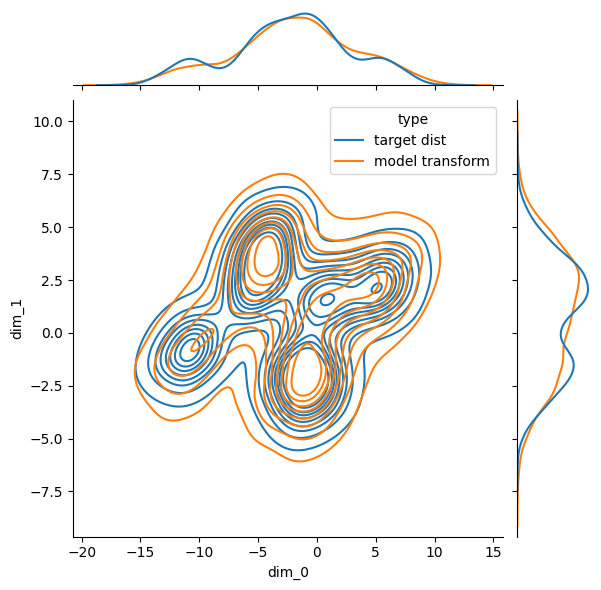

trail: 0 m step: 8 kl_test: 0.7260074615478516


  2%|▏         | 100/6000 [00:31<33:46,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6759328842163086  L_n: 0.6078214645385742  kld: 0.0068111419677734375 KLD1: 0.5739840865135193 KLD2: 0.3853168487548828


  3%|▎         | 200/6000 [01:02<33:14,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6663637161254883  L_n: 0.6038599014282227  kld: 0.0062503814697265625 KLD1: 0.595609188079834 KLD2: 0.3869059383869171


  5%|▌         | 300/6000 [01:33<32:31,  2.92it/s]

trail: 0 m step: 9 Loss: 0.6389217376708984  L_n: 0.5607776641845703  kld: 0.007814407348632812 KLD1: 0.5729567408561707 KLD2: 0.3857796788215637


  7%|▋         | 400/6000 [02:04<32:10,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6735754013061523  L_n: 0.5845880508422852  kld: 0.008898735046386719 KLD1: 0.5617316365242004 KLD2: 0.39279136061668396


  8%|▊         | 500/6000 [02:35<31:30,  2.91it/s]

trail: 0 m step: 9 Loss: 0.669917106628418  L_n: 0.5875768661499023  kld: 0.008234024047851562 KLD1: 0.5661594867706299 KLD2: 0.39120373129844666


 10%|█         | 600/6000 [03:06<30:59,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6535453796386719  L_n: 0.5888671875  kld: 0.0064678192138671875 KLD1: 0.5823571085929871 KLD2: 0.38979876041412354


 12%|█▏        | 700/6000 [03:37<30:20,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6408958435058594  L_n: 0.5350856781005859  kld: 0.010581016540527344 KLD1: 0.5607404708862305 KLD2: 0.38777852058410645


 13%|█▎        | 800/6000 [04:09<29:48,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6442728042602539  L_n: 0.5891313552856445  kld: 0.0055141448974609375 KLD1: 0.5916178226470947 KLD2: 0.38341599702835083


 15%|█▌        | 900/6000 [04:40<29:19,  2.90it/s]

trail: 0 m step: 9 Loss: 0.638463020324707  L_n: 0.5850000381469727  kld: 0.0053462982177734375 KLD1: 0.5881167054176331 KLD2: 0.3873278796672821


 17%|█▋        | 1000/6000 [05:11<28:36,  2.91it/s]

trail: 0 m step: 9 Loss: 0.5907802581787109  L_n: 0.5431442260742188  kld: 0.004763603210449219 KLD1: 0.6165998578071594 KLD2: 0.3990059792995453


 18%|█▊        | 1100/6000 [05:42<28:05,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6190280914306641  L_n: 0.5503158569335938  kld: 0.006871223449707031 KLD1: 0.5839876532554626 KLD2: 0.3720439672470093


 20%|██        | 1200/6000 [06:13<27:35,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6594181060791016  L_n: 0.5638885498046875  kld: 0.009552955627441406 KLD1: 0.5657009482383728 KLD2: 0.390327513217926


 22%|██▏       | 1300/6000 [06:44<27:01,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6384916305541992  L_n: 0.553624153137207  kld: 0.008486747741699219 KLD1: 0.5595275163650513 KLD2: 0.3921460807323456


 23%|██▎       | 1400/6000 [07:16<26:20,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6842288970947266  L_n: 0.6022415161132812  kld: 0.008198738098144531 KLD1: 0.5658000111579895 KLD2: 0.3822954595088959


 25%|██▌       | 1500/6000 [07:47<25:55,  2.89it/s]

trail: 0 m step: 9 Loss: 0.6650667190551758  L_n: 0.5869894027709961  kld: 0.007807731628417969 KLD1: 0.5781933665275574 KLD2: 0.4081207811832428


 27%|██▋       | 1600/6000 [08:18<25:22,  2.89it/s]

trail: 0 m step: 9 Loss: 0.6599159240722656  L_n: 0.5837459564208984  kld: 0.007616996765136719 KLD1: 0.5668845772743225 KLD2: 0.39577317237854004


 28%|██▊       | 1700/6000 [08:49<24:41,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6498489379882812  L_n: 0.5678043365478516  kld: 0.008204460144042969 KLD1: 0.5559753775596619 KLD2: 0.37189599871635437


 30%|███       | 1800/6000 [09:20<24:03,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6482629776000977  L_n: 0.5642919540405273  kld: 0.008397102355957031 KLD1: 0.5764976143836975 KLD2: 0.3798138499259949


 32%|███▏      | 1900/6000 [09:52<23:32,  2.90it/s]

trail: 0 m step: 9 Loss: 0.655461311340332  L_n: 0.5814752578735352  kld: 0.0073986053466796875 KLD1: 0.5777866840362549 KLD2: 0.3715304732322693


 33%|███▎      | 2000/6000 [10:23<22:58,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6615352630615234  L_n: 0.5786418914794922  kld: 0.008289337158203125 KLD1: 0.5579569935798645 KLD2: 0.3777469992637634


 35%|███▌      | 2100/6000 [10:54<22:26,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6219644546508789  L_n: 0.5648012161254883  kld: 0.0057163238525390625 KLD1: 0.5671729445457458 KLD2: 0.38401976227760315


 37%|███▋      | 2200/6000 [11:25<21:48,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6349020004272461  L_n: 0.5554513931274414  kld: 0.007945060729980469 KLD1: 0.5728859901428223 KLD2: 0.3862597942352295


 38%|███▊      | 2300/6000 [11:57<21:19,  2.89it/s]

trail: 0 m step: 9 Loss: 0.6352729797363281  L_n: 0.5769939422607422  kld: 0.005827903747558594 KLD1: 0.5928510427474976 KLD2: 0.3881660997867584


 40%|████      | 2400/6000 [12:28<20:43,  2.89it/s]

trail: 0 m step: 9 Loss: 0.6467456817626953  L_n: 0.57513427734375  kld: 0.007161140441894531 KLD1: 0.5745021104812622 KLD2: 0.38100534677505493


 42%|████▏     | 2500/6000 [12:59<20:06,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6450634002685547  L_n: 0.5694370269775391  kld: 0.0075626373291015625 KLD1: 0.5672681331634521 KLD2: 0.38476067781448364


 43%|████▎     | 2600/6000 [13:30<19:37,  2.89it/s]

trail: 0 m step: 9 Loss: 0.6265439987182617  L_n: 0.5657663345336914  kld: 0.006077766418457031 KLD1: 0.5798896551132202 KLD2: 0.3896883428096771


 45%|████▌     | 2700/6000 [14:02<19:01,  2.89it/s]

trail: 0 m step: 9 Loss: 0.6289567947387695  L_n: 0.5616083145141602  kld: 0.0067348480224609375 KLD1: 0.576188325881958 KLD2: 0.3750429153442383


 47%|████▋     | 2800/6000 [14:33<18:22,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6440639495849609  L_n: 0.5641937255859375  kld: 0.007987022399902344 KLD1: 0.5703717470169067 KLD2: 0.38081833720207214


 48%|████▊     | 2900/6000 [15:04<17:52,  2.89it/s]

trail: 0 m step: 9 Loss: 0.642003059387207  L_n: 0.5612649917602539  kld: 0.008073806762695312 KLD1: 0.5686162114143372 KLD2: 0.36561381816864014


 50%|█████     | 3000/6000 [15:35<17:12,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6384191513061523  L_n: 0.5718050003051758  kld: 0.006661415100097656 KLD1: 0.568342387676239 KLD2: 0.3939548134803772


 52%|█████▏    | 3100/6000 [16:06<16:43,  2.89it/s]

trail: 0 m step: 9 Loss: 0.6209869384765625  L_n: 0.5564136505126953  kld: 0.006457328796386719 KLD1: 0.5809687376022339 KLD2: 0.3915656805038452


 53%|█████▎    | 3200/6000 [16:38<16:04,  2.90it/s]

trail: 0 m step: 9 Loss: 0.640385627746582  L_n: 0.5715494155883789  kld: 0.0068836212158203125 KLD1: 0.567596971988678 KLD2: 0.38171565532684326


 55%|█████▌    | 3300/6000 [17:09<15:31,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6521949768066406  L_n: 0.5631027221679688  kld: 0.008909225463867188 KLD1: 0.5569201111793518 KLD2: 0.37591108679771423


 57%|█████▋    | 3400/6000 [17:40<14:59,  2.89it/s]

trail: 0 m step: 9 Loss: 0.6408681869506836  L_n: 0.5795469284057617  kld: 0.0061321258544921875 KLD1: 0.5937705636024475 KLD2: 0.3796060085296631


 58%|█████▊    | 3500/6000 [18:11<14:21,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6220083236694336  L_n: 0.5487279891967773  kld: 0.007328033447265625 KLD1: 0.5600958466529846 KLD2: 0.3821227550506592


 60%|██████    | 3600/6000 [18:42<13:50,  2.89it/s]

trail: 0 m step: 9 Loss: 0.6264963150024414  L_n: 0.5673494338989258  kld: 0.0059146881103515625 KLD1: 0.5870434641838074 KLD2: 0.38608530163764954


 62%|██████▏   | 3700/6000 [19:14<13:14,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6660537719726562  L_n: 0.5741100311279297  kld: 0.009194374084472656 KLD1: 0.5546186566352844 KLD2: 0.3855040371417999


 63%|██████▎   | 3800/6000 [19:45<12:36,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6186628341674805  L_n: 0.5585908889770508  kld: 0.006007194519042969 KLD1: 0.5874283909797668 KLD2: 0.3792397379875183


 65%|██████▌   | 3900/6000 [20:16<12:01,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6232280731201172  L_n: 0.5553932189941406  kld: 0.006783485412597656 KLD1: 0.5666580200195312 KLD2: 0.38002312183380127


 67%|██████▋   | 4000/6000 [20:47<11:30,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6521825790405273  L_n: 0.5902128219604492  kld: 0.0061969757080078125 KLD1: 0.5813239216804504 KLD2: 0.3956250250339508


 68%|██████▊   | 4100/6000 [21:18<10:56,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6438789367675781  L_n: 0.5666027069091797  kld: 0.007727622985839844 KLD1: 0.551770031452179 KLD2: 0.3821198046207428


 70%|███████   | 4200/6000 [21:50<10:20,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6578741073608398  L_n: 0.5752191543579102  kld: 0.008265495300292969 KLD1: 0.5535492897033691 KLD2: 0.3729497790336609


 72%|███████▏  | 4300/6000 [22:21<09:47,  2.89it/s]

trail: 0 m step: 9 Loss: 0.6256799697875977  L_n: 0.5560235977172852  kld: 0.00696563720703125 KLD1: 0.5713893175125122 KLD2: 0.37980446219444275


 73%|███████▎  | 4400/6000 [22:52<09:12,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6436710357666016  L_n: 0.5641441345214844  kld: 0.007952690124511719 KLD1: 0.5588036775588989 KLD2: 0.3798271715641022


 75%|███████▌  | 4500/6000 [23:23<08:37,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6759977340698242  L_n: 0.5945634841918945  kld: 0.008143424987792969 KLD1: 0.558007001876831 KLD2: 0.37143388390541077


 77%|███████▋  | 4600/6000 [23:54<08:02,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6729469299316406  L_n: 0.5824527740478516  kld: 0.009049415588378906 KLD1: 0.5563128590583801 KLD2: 0.37869885563850403


 78%|███████▊  | 4700/6000 [24:26<07:27,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6552305221557617  L_n: 0.573634147644043  kld: 0.008159637451171875 KLD1: 0.5442025065422058 KLD2: 0.3747294247150421


 80%|████████  | 4800/6000 [24:57<06:52,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6773691177368164  L_n: 0.5819635391235352  kld: 0.009540557861328125 KLD1: 0.5415698289871216 KLD2: 0.3988037407398224


 82%|████████▏ | 4900/6000 [25:28<06:19,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6347808837890625  L_n: 0.5673656463623047  kld: 0.006741523742675781 KLD1: 0.5624579787254333 KLD2: 0.3741593658924103


 83%|████████▎ | 5000/6000 [25:59<05:43,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6119060516357422  L_n: 0.5488491058349609  kld: 0.006305694580078125 KLD1: 0.572411298751831 KLD2: 0.3865984380245209


 85%|████████▌ | 5100/6000 [26:30<05:10,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6322250366210938  L_n: 0.5625972747802734  kld: 0.006962776184082031 KLD1: 0.5639922618865967 KLD2: 0.3749871551990509


 87%|████████▋ | 5200/6000 [27:02<04:36,  2.89it/s]

trail: 0 m step: 9 Loss: 0.6226825714111328  L_n: 0.5512619018554688  kld: 0.007142066955566406 KLD1: 0.5709573030471802 KLD2: 0.38758647441864014


 88%|████████▊ | 5300/6000 [27:33<04:01,  2.89it/s]

trail: 0 m step: 9 Loss: 0.659205436706543  L_n: 0.5894346237182617  kld: 0.006977081298828125 KLD1: 0.5695514678955078 KLD2: 0.3685394823551178


 90%|█████████ | 5400/6000 [28:04<03:26,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6511249542236328  L_n: 0.5817451477050781  kld: 0.006937980651855469 KLD1: 0.5742341876029968 KLD2: 0.3960072994232178


 92%|█████████▏| 5500/6000 [28:35<02:52,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6583175659179688  L_n: 0.5776271820068359  kld: 0.008069038391113281 KLD1: 0.5653702616691589 KLD2: 0.3780408203601837


 93%|█████████▎| 5600/6000 [29:06<02:17,  2.91it/s]

trail: 0 m step: 9 Loss: 0.633885383605957  L_n: 0.5577726364135742  kld: 0.007611274719238281 KLD1: 0.5602357387542725 KLD2: 0.3858381509780884


 95%|█████████▌| 5700/6000 [29:37<01:43,  2.91it/s]

trail: 0 m step: 9 Loss: 0.6066217422485352  L_n: 0.5308332443237305  kld: 0.007578849792480469 KLD1: 0.5543169379234314 KLD2: 0.3772546648979187


 97%|█████████▋| 5800/6000 [30:09<01:08,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6331033706665039  L_n: 0.5690164566040039  kld: 0.00640869140625 KLD1: 0.5636417865753174 KLD2: 0.37819379568099976


 98%|█████████▊| 5900/6000 [30:40<00:34,  2.90it/s]

trail: 0 m step: 9 Loss: 0.6420516967773438  L_n: 0.5669689178466797  kld: 0.007508277893066406 KLD1: 0.5685654878616333 KLD2: 0.3728143572807312


100%|██████████| 6000/6000 [31:11<00:00,  3.21it/s]

trail: 0 m step: 9 Loss: 0.6764383316040039  L_n: 0.5933542251586914  kld: 0.00830841064453125 KLD1: 0.5530605316162109 KLD2: 0.3980206549167633



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


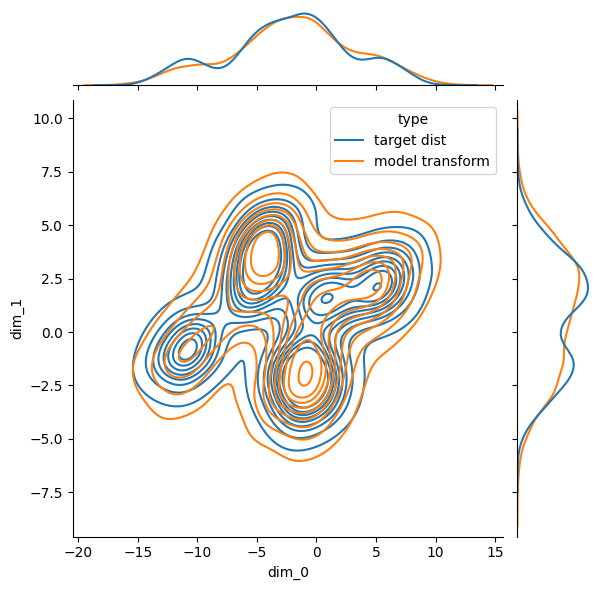

trail: 0 m step: 9 kl_test: 0.57489013671875


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  optimizer_lr_input = optimizer_lr * (outer_lr_factor**mirror_itr)
  optimizer = torch.optim.Adam(model2.parameters(), lr=optimizer_lr_input, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = eta
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )


<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


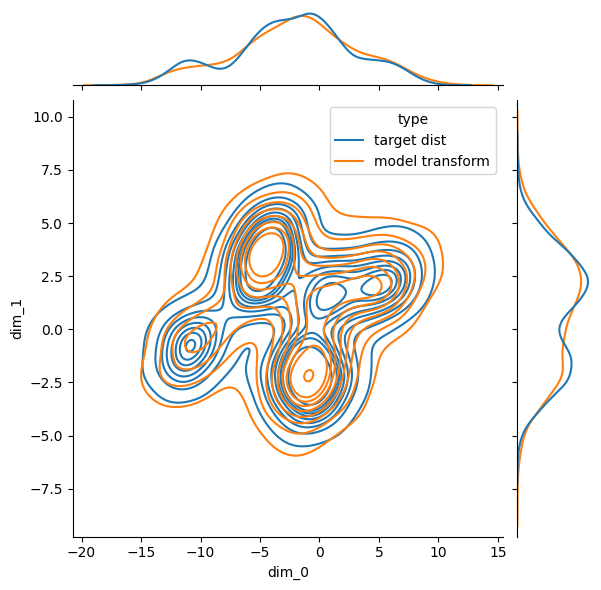

In [ ]:
target_samples = stationary_dist.sample((5000,))
model_samples, _ = model.sample(5000)
plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())

  2%|▏         | 100/6000 [00:31<34:50,  2.82it/s]

trail: 0 m step: 0 Loss: 0.5506563186645508  L_n: 0.4943513870239258  kld: 0.0056304931640625 KLD1: 0.46633830666542053 KLD2: 0.3199840188026428


  3%|▎         | 200/6000 [01:02<33:12,  2.91it/s]

trail: 0 m step: 0 Loss: 0.5405378341674805  L_n: 0.4937887191772461  kld: 0.0046749114990234375 KLD1: 0.48331418633461 KLD2: 0.3237169086933136


  5%|▌         | 300/6000 [01:33<32:47,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5221424102783203  L_n: 0.4595146179199219  kld: 0.006262779235839844 KLD1: 0.4698871970176697 KLD2: 0.32332274317741394


  7%|▋         | 400/6000 [02:05<32:22,  2.88it/s]

trail: 0 m step: 0 Loss: 0.5456018447875977  L_n: 0.4737997055053711  kld: 0.007180213928222656 KLD1: 0.44995418190956116 KLD2: 0.3280180096626282


  8%|▊         | 500/6000 [02:36<31:38,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5482187271118164  L_n: 0.4800119400024414  kld: 0.0068206787109375 KLD1: 0.45508286356925964 KLD2: 0.3264172673225403


 10%|█         | 600/6000 [03:07<30:58,  2.91it/s]

trail: 0 m step: 0 Loss: 0.5310525894165039  L_n: 0.4758443832397461  kld: 0.005520820617675781 KLD1: 0.472860187292099 KLD2: 0.32345813512802124


 12%|█▏        | 700/6000 [03:38<30:31,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5266380310058594  L_n: 0.4416370391845703  kld: 0.008500099182128906 KLD1: 0.4590262472629547 KLD2: 0.32656723260879517


 13%|█▎        | 800/6000 [04:09<29:53,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5240755081176758  L_n: 0.47779369354248047  kld: 0.004628181457519531 KLD1: 0.47966229915618896 KLD2: 0.31931203603744507


 15%|█▌        | 900/6000 [04:41<29:16,  2.90it/s]

trail: 0 m step: 0 Loss: 0.512141227722168  L_n: 0.47247791290283203  kld: 0.003966331481933594 KLD1: 0.48004090785980225 KLD2: 0.32374751567840576


 17%|█▋        | 1000/6000 [05:12<28:45,  2.90it/s]

trail: 0 m step: 0 Loss: 0.47508716583251953  L_n: 0.4418611526489258  kld: 0.003322601318359375 KLD1: 0.5113434195518494 KLD2: 0.33452507853507996


 18%|█▊        | 1100/6000 [05:43<28:13,  2.89it/s]

trail: 0 m step: 0 Loss: 0.49523162841796875  L_n: 0.44277000427246094  kld: 0.005246162414550781 KLD1: 0.4713034927845001 KLD2: 0.3105204403400421


 20%|██        | 1200/6000 [06:14<27:38,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5297203063964844  L_n: 0.4533882141113281  kld: 0.007633209228515625 KLD1: 0.45855966210365295 KLD2: 0.3273630738258362


 22%|██▏       | 1300/6000 [06:46<27:02,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5122880935668945  L_n: 0.4471712112426758  kld: 0.006511688232421875 KLD1: 0.45791465044021606 KLD2: 0.32837092876434326


 23%|██▎       | 1400/6000 [07:17<26:28,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5592584609985352  L_n: 0.4930734634399414  kld: 0.006618499755859375 KLD1: 0.459535151720047 KLD2: 0.31886065006256104


 25%|██▌       | 1500/6000 [07:48<25:50,  2.90it/s]

trail: 0 m step: 0 Loss: 0.542877197265625  L_n: 0.4781608581542969  kld: 0.0064716339111328125 KLD1: 0.4735598862171173 KLD2: 0.342322438955307


 27%|██▋       | 1600/6000 [08:19<25:19,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5373926162719727  L_n: 0.4803342819213867  kld: 0.005705833435058594 KLD1: 0.4547186493873596 KLD2: 0.3321413993835449


 28%|██▊       | 1700/6000 [08:50<24:45,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5271234512329102  L_n: 0.45940303802490234  kld: 0.006772041320800781 KLD1: 0.4510989189147949 KLD2: 0.30977585911750793


 30%|███       | 1800/6000 [09:22<24:07,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5260944366455078  L_n: 0.4583454132080078  kld: 0.00677490234375 KLD1: 0.46411532163619995 KLD2: 0.31751489639282227


 32%|███▏      | 1900/6000 [09:53<23:41,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5375404357910156  L_n: 0.4754180908203125  kld: 0.0062122344970703125 KLD1: 0.4703298807144165 KLD2: 0.309296190738678


 33%|███▎      | 2000/6000 [10:24<22:58,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5400810241699219  L_n: 0.47650909423828125  kld: 0.0063571929931640625 KLD1: 0.45044904947280884 KLD2: 0.31577926874160767


 35%|███▌      | 2100/6000 [10:55<22:29,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5012712478637695  L_n: 0.4564485549926758  kld: 0.004482269287109375 KLD1: 0.46174636483192444 KLD2: 0.32027003169059753


 37%|███▋      | 2200/6000 [11:27<21:52,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5187015533447266  L_n: 0.4544811248779297  kld: 0.0064220428466796875 KLD1: 0.4595039486885071 KLD2: 0.3218931555747986


 38%|███▊      | 2300/6000 [11:58<21:17,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5108003616333008  L_n: 0.46366024017333984  kld: 0.004714012145996094 KLD1: 0.47966980934143066 KLD2: 0.3247540593147278


 40%|████      | 2400/6000 [12:29<20:46,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5277872085571289  L_n: 0.47347545623779297  kld: 0.005431175231933594 KLD1: 0.4666898846626282 KLD2: 0.3183853328227997


 42%|████▏     | 2500/6000 [13:00<20:10,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5199565887451172  L_n: 0.4586067199707031  kld: 0.006134986877441406 KLD1: 0.4565693140029907 KLD2: 0.3217298090457916


 43%|████▎     | 2600/6000 [13:32<19:31,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5046100616455078  L_n: 0.4600543975830078  kld: 0.00445556640625 KLD1: 0.4715805947780609 KLD2: 0.32538431882858276


 45%|████▌     | 2700/6000 [14:03<19:00,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5143966674804688  L_n: 0.4618206024169922  kld: 0.005257606506347656 KLD1: 0.4715908467769623 KLD2: 0.31286880373954773


 47%|████▋     | 2800/6000 [14:34<18:22,  2.90it/s]

trail: 0 m step: 0 Loss: 0.521367073059082  L_n: 0.45811939239501953  kld: 0.00632476806640625 KLD1: 0.4630248546600342 KLD2: 0.3189470171928406


 48%|████▊     | 2900/6000 [15:05<17:49,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5193414688110352  L_n: 0.4552450180053711  kld: 0.006409645080566406 KLD1: 0.4611532986164093 KLD2: 0.3032393753528595


 50%|█████     | 3000/6000 [15:36<17:19,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5128679275512695  L_n: 0.46059703826904297  kld: 0.005227088928222656 KLD1: 0.4576410949230194 KLD2: 0.3286013603210449


 52%|█████▏    | 3100/6000 [16:08<16:41,  2.90it/s]

trail: 0 m step: 0 Loss: 0.4968252182006836  L_n: 0.4461183547973633  kld: 0.005070686340332031 KLD1: 0.47392943501472473 KLD2: 0.32768628001213074


 53%|█████▎    | 3200/6000 [16:39<16:08,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5214242935180664  L_n: 0.46594905853271484  kld: 0.005547523498535156 KLD1: 0.45734071731567383 KLD2: 0.31957104802131653


 55%|█████▌    | 3300/6000 [17:10<15:29,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5296554565429688  L_n: 0.4597034454345703  kld: 0.006995201110839844 KLD1: 0.45174500346183777 KLD2: 0.3138444125652313


 57%|█████▋    | 3400/6000 [17:41<14:56,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5232944488525391  L_n: 0.4746856689453125  kld: 0.004860877990722656 KLD1: 0.48543769121170044 KLD2: 0.3158974051475525


 58%|█████▊    | 3500/6000 [18:12<14:23,  2.89it/s]

trail: 0 m step: 0 Loss: 0.4993896484375  L_n: 0.4445056915283203  kld: 0.005488395690917969 KLD1: 0.45250052213668823 KLD2: 0.32033467292785645


 60%|██████    | 3600/6000 [18:44<13:47,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5028781890869141  L_n: 0.4552135467529297  kld: 0.0047664642333984375 KLD1: 0.48102888464927673 KLD2: 0.321809858083725


 62%|██████▏   | 3700/6000 [19:15<13:13,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5411539077758789  L_n: 0.4658327102661133  kld: 0.0075321197509765625 KLD1: 0.44729316234588623 KLD2: 0.3204784691333771


 63%|██████▎   | 3800/6000 [19:46<12:39,  2.89it/s]

trail: 0 m step: 0 Loss: 0.4956169128417969  L_n: 0.44799041748046875  kld: 0.0047626495361328125 KLD1: 0.47155818343162537 KLD2: 0.3163021504878998


 65%|██████▌   | 3900/6000 [20:17<12:04,  2.90it/s]

trail: 0 m step: 0 Loss: 0.49880027770996094  L_n: 0.4461669921875  kld: 0.005263328552246094 KLD1: 0.45773208141326904 KLD2: 0.317420095205307


 67%|██████▋   | 4000/6000 [20:48<11:31,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5222434997558594  L_n: 0.4775257110595703  kld: 0.004471778869628906 KLD1: 0.47028207778930664 KLD2: 0.33135393261909485


 68%|██████▊   | 4100/6000 [21:19<10:56,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5223302841186523  L_n: 0.4603891372680664  kld: 0.006194114685058594 KLD1: 0.4470309913158417 KLD2: 0.3191833794116974


 70%|███████   | 4200/6000 [21:51<10:20,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5282526016235352  L_n: 0.46581554412841797  kld: 0.006243705749511719 KLD1: 0.454398512840271 KLD2: 0.31009718775749207


 72%|███████▏  | 4300/6000 [22:22<09:45,  2.90it/s]

trail: 0 m step: 0 Loss: 0.503016471862793  L_n: 0.45068836212158203  kld: 0.005232810974121094 KLD1: 0.4617527723312378 KLD2: 0.31724199652671814


 73%|███████▎  | 4400/6000 [22:53<09:11,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5237522125244141  L_n: 0.4595317840576172  kld: 0.0064220428466796875 KLD1: 0.45665955543518066 KLD2: 0.3170095682144165


 75%|███████▌  | 4500/6000 [23:24<08:35,  2.91it/s]

trail: 0 m step: 0 Loss: 0.548553466796875  L_n: 0.4840278625488281  kld: 0.0064525604248046875 KLD1: 0.4501909911632538 KLD2: 0.309161901473999


 77%|███████▋  | 4600/6000 [23:55<08:03,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5421943664550781  L_n: 0.47327232360839844  kld: 0.006892204284667969 KLD1: 0.45267507433891296 KLD2: 0.3166848421096802


 78%|███████▊  | 4700/6000 [24:27<07:29,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5234346389770508  L_n: 0.46159839630126953  kld: 0.006183624267578125 KLD1: 0.44317322969436646 KLD2: 0.3126240670681


 80%|████████  | 4800/6000 [24:58<06:54,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5481071472167969  L_n: 0.4708976745605469  kld: 0.007720947265625 KLD1: 0.4371967613697052 KLD2: 0.33500373363494873


 82%|████████▏ | 4900/6000 [25:29<06:21,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5124521255493164  L_n: 0.46149730682373047  kld: 0.005095481872558594 KLD1: 0.4637303948402405 KLD2: 0.31149399280548096


 83%|████████▎ | 5000/6000 [26:00<05:46,  2.89it/s]

trail: 0 m step: 0 Loss: 0.4924650192260742  L_n: 0.4437131881713867  kld: 0.00487518310546875 KLD1: 0.4654652178287506 KLD2: 0.32237935066223145


 85%|████████▌ | 5100/6000 [26:32<05:11,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5077886581420898  L_n: 0.4558134078979492  kld: 0.0051975250244140625 KLD1: 0.45500749349594116 KLD2: 0.3116632103919983


 87%|████████▋ | 5200/6000 [27:03<04:36,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5030679702758789  L_n: 0.44481754302978516  kld: 0.005825042724609375 KLD1: 0.4598957896232605 KLD2: 0.32347381114959717


 88%|████████▊ | 5300/6000 [27:34<04:00,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5325088500976562  L_n: 0.47686195373535156  kld: 0.005564689636230469 KLD1: 0.4612328112125397 KLD2: 0.3042902648448944


 90%|█████████ | 5400/6000 [28:05<03:27,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5253925323486328  L_n: 0.4703369140625  kld: 0.005505561828613281 KLD1: 0.45946478843688965 KLD2: 0.33122652769088745


 92%|█████████▏| 5500/6000 [28:37<02:52,  2.90it/s]

trail: 0 m step: 0 Loss: 0.533198356628418  L_n: 0.4680624008178711  kld: 0.0065135955810546875 KLD1: 0.4571566879749298 KLD2: 0.31560206413269043


 93%|█████████▎| 5600/6000 [29:08<02:18,  2.89it/s]

trail: 0 m step: 0 Loss: 0.5141029357910156  L_n: 0.45649147033691406  kld: 0.005761146545410156 KLD1: 0.4535330832004547 KLD2: 0.3216173052787781


 95%|█████████▌| 5700/6000 [29:39<01:43,  2.89it/s]

trail: 0 m step: 0 Loss: 0.4883718490600586  L_n: 0.42973995208740234  kld: 0.005863189697265625 KLD1: 0.45555487275123596 KLD2: 0.3145918846130371


 97%|█████████▋| 5800/6000 [30:10<01:08,  2.90it/s]

trail: 0 m step: 0 Loss: 0.5182886123657227  L_n: 0.4680013656616211  kld: 0.005028724670410156 KLD1: 0.4611227512359619 KLD2: 0.31510791182518005


 98%|█████████▊| 5900/6000 [30:41<00:34,  2.90it/s]

trail: 0 m step: 0 Loss: 0.523284912109375  L_n: 0.46437644958496094  kld: 0.005890846252441406 KLD1: 0.4609186351299286 KLD2: 0.31063997745513916


100%|██████████| 6000/6000 [31:13<00:00,  3.20it/s]

trail: 0 m step: 0 Loss: 0.5498571395874023  L_n: 0.4833669662475586  kld: 0.006649017333984375 KLD1: 0.4482339322566986 KLD2: 0.33352816104888916



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


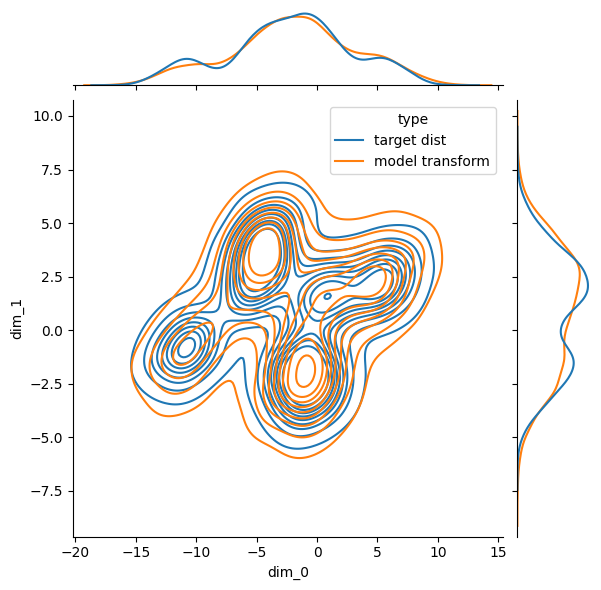

trail: 0 m step: 0 kl_test: 0.4667043685913086


  2%|▏         | 100/6000 [00:31<34:15,  2.87it/s]

trail: 0 m step: 1 Loss: 0.43292001577524036  L_n: 0.3831748962402344  kld: 0.006466865539550781 KLD1: 0.3591328561306 KLD2: 0.25623318552970886


  3%|▎         | 200/6000 [01:02<33:11,  2.91it/s]

trail: 0 m step: 1 Loss: 0.4352395717914288  L_n: 0.39076900482177734  kld: 0.0057811737060546875 KLD1: 0.3852330148220062 KLD2: 0.2595667839050293


  5%|▌         | 300/6000 [01:33<32:52,  2.89it/s]

trail: 0 m step: 1 Loss: 0.4130993622999925  L_n: 0.3568105697631836  kld: 0.007317543029785156 KLD1: 0.36653631925582886 KLD2: 0.2593577206134796


  7%|▋         | 400/6000 [02:05<32:12,  2.90it/s]

trail: 0 m step: 1 Loss: 0.43294026301457333  L_n: 0.3687286376953125  kld: 0.008347511291503906 KLD1: 0.35152119398117065 KLD2: 0.26286396384239197


  8%|▊         | 500/6000 [02:36<31:25,  2.92it/s]

trail: 0 m step: 1 Loss: 0.4460417674137996  L_n: 0.3829965591430664  kld: 0.008195877075195312 KLD1: 0.3556324243545532 KLD2: 0.2610246539115906


 10%|█         | 600/6000 [03:07<30:56,  2.91it/s]

trail: 0 m step: 1 Loss: 0.4273859170766977  L_n: 0.37561607360839844  kld: 0.006730079650878906 KLD1: 0.37225764989852905 KLD2: 0.2608336806297302


 12%|█▏        | 700/6000 [03:38<30:28,  2.90it/s]

trail: 0 m step: 1 Loss: 0.41596353971041167  L_n: 0.3383197784423828  kld: 0.01009368896484375 KLD1: 0.3470451533794403 KLD2: 0.2618385851383209


 13%|█▎        | 800/6000 [04:09<29:55,  2.90it/s]

trail: 0 m step: 1 Loss: 0.42347049713134766  L_n: 0.37387943267822266  kld: 0.00644683837890625 KLD1: 0.37881505489349365 KLD2: 0.25525525212287903


 15%|█▌        | 900/6000 [04:41<29:22,  2.89it/s]

trail: 0 m step: 1 Loss: 0.4035687079796424  L_n: 0.3657665252685547  kld: 0.004914283752441406 KLD1: 0.3760383427143097 KLD2: 0.26222023367881775


 17%|█▋        | 1000/6000 [05:12<28:49,  2.89it/s]

trail: 0 m step: 1 Loss: 0.37633294325608474  L_n: 0.3458080291748047  kld: 0.003968238830566406 KLD1: 0.399458646774292 KLD2: 0.26968851685523987


 18%|█▊        | 1100/6000 [05:43<28:12,  2.90it/s]

trail: 0 m step: 1 Loss: 0.39125640575702375  L_n: 0.34603023529052734  kld: 0.005879402160644531 KLD1: 0.36352938413619995 KLD2: 0.24871192872524261


 20%|██        | 1200/6000 [06:14<27:36,  2.90it/s]

trail: 0 m step: 1 Loss: 0.42351458622859073  L_n: 0.3577404022216797  kld: 0.008550643920898438 KLD1: 0.36160382628440857 KLD2: 0.26401785016059875


 22%|██▏       | 1300/6000 [06:45<26:58,  2.90it/s]

trail: 0 m step: 1 Loss: 0.40614487574650693  L_n: 0.3453664779663086  kld: 0.007901191711425781 KLD1: 0.3515208959579468 KLD2: 0.26219359040260315


 23%|██▎       | 1400/6000 [07:17<26:26,  2.90it/s]

trail: 0 m step: 1 Loss: 0.4349514154287485  L_n: 0.3762197494506836  kld: 0.0076351165771484375 KLD1: 0.3591892123222351 KLD2: 0.25501397252082825


 25%|██▌       | 1500/6000 [07:48<25:57,  2.89it/s]

trail: 0 m step: 1 Loss: 0.4359609897320087  L_n: 0.37552738189697266  kld: 0.007856369018554688 KLD1: 0.3620299696922302 KLD2: 0.2749162018299103


 27%|██▋       | 1600/6000 [08:19<25:19,  2.90it/s]

trail: 0 m step: 1 Loss: 0.4296211095956656  L_n: 0.3725767135620117  kld: 0.007415771484375 KLD1: 0.3532983362674713 KLD2: 0.2661629915237427


 28%|██▊       | 1700/6000 [08:50<24:42,  2.90it/s]

trail: 0 m step: 1 Loss: 0.41598063248854417  L_n: 0.3560018539428711  kld: 0.0077972412109375 KLD1: 0.3508109748363495 KLD2: 0.24598588049411774


 30%|███       | 1800/6000 [09:22<24:06,  2.90it/s]

trail: 0 m step: 1 Loss: 0.4201540580162635  L_n: 0.36127567291259766  kld: 0.0076541900634765625 KLD1: 0.36175501346588135 KLD2: 0.25439533591270447


 32%|███▏      | 1900/6000 [09:53<23:36,  2.89it/s]

trail: 0 m step: 1 Loss: 0.4267695500300481  L_n: 0.3701286315917969  kld: 0.007363319396972656 KLD1: 0.36522820591926575 KLD2: 0.24490295350551605


 33%|███▎      | 2000/6000 [10:24<23:02,  2.89it/s]

trail: 0 m step: 1 Loss: 0.42858593280498797  L_n: 0.3708152770996094  kld: 0.007510185241699219 KLD1: 0.3491857945919037 KLD2: 0.25374191999435425


 35%|███▌      | 2100/6000 [10:55<22:23,  2.90it/s]

trail: 0 m step: 1 Loss: 0.4069505838247446  L_n: 0.3643360137939453  kld: 0.005539894104003906 KLD1: 0.35475704073905945 KLD2: 0.2558138966560364


 37%|███▋      | 2200/6000 [11:27<21:53,  2.89it/s]

trail: 0 m step: 1 Loss: 0.42040289365328276  L_n: 0.36202335357666016  kld: 0.0075893402099609375 KLD1: 0.3532339334487915 KLD2: 0.25790271162986755


 38%|███▊      | 2300/6000 [11:58<21:16,  2.90it/s]

trail: 0 m step: 1 Loss: 0.3999505409827599  L_n: 0.36021900177001953  kld: 0.00516510009765625 KLD1: 0.37306565046310425 KLD2: 0.2597541809082031


 40%|████      | 2400/6000 [12:29<20:41,  2.90it/s]

trail: 0 m step: 1 Loss: 0.4225062590378981  L_n: 0.37312793731689453  kld: 0.006419181823730469 KLD1: 0.3697948157787323 KLD2: 0.2549334764480591


 42%|████▏     | 2500/6000 [13:00<20:05,  2.90it/s]

trail: 0 m step: 1 Loss: 0.41477174025315505  L_n: 0.35811614990234375  kld: 0.007365226745605469 KLD1: 0.35647299885749817 KLD2: 0.25845369696617126


 43%|████▎     | 2600/6000 [13:32<19:33,  2.90it/s]

trail: 0 m step: 1 Loss: 0.40355315575232875  L_n: 0.3606891632080078  kld: 0.005572319030761719 KLD1: 0.366912305355072 KLD2: 0.26121649146080017


 45%|████▌     | 2700/6000 [14:03<18:59,  2.90it/s]

trail: 0 m step: 1 Loss: 0.40149556673490083  L_n: 0.3486766815185547  kld: 0.006866455078125 KLD1: 0.3665241599082947 KLD2: 0.24812597036361694


 47%|████▋     | 2800/6000 [14:34<18:23,  2.90it/s]

trail: 0 m step: 1 Loss: 0.41397674267108625  L_n: 0.3544454574584961  kld: 0.007739067077636719 KLD1: 0.35714852809906006 KLD2: 0.2551051676273346


 48%|████▊     | 2900/6000 [15:05<17:49,  2.90it/s]

trail: 0 m step: 1 Loss: 0.42280255831204927  L_n: 0.36187744140625  kld: 0.007920265197753906 KLD1: 0.35330039262771606 KLD2: 0.24012963473796844


 50%|█████     | 3000/6000 [15:36<17:18,  2.89it/s]

trail: 0 m step: 1 Loss: 0.3964701432448167  L_n: 0.3454265594482422  kld: 0.0066356658935546875 KLD1: 0.34910672903060913 KLD2: 0.26265478134155273


 52%|█████▏    | 3100/6000 [16:08<16:46,  2.88it/s]

trail: 0 m step: 1 Loss: 0.3901378925030048  L_n: 0.3440093994140625  kld: 0.0059967041015625 KLD1: 0.3726294934749603 KLD2: 0.2625217139720917


 53%|█████▎    | 3200/6000 [16:39<16:06,  2.90it/s]

trail: 0 m step: 1 Loss: 0.41758339221660906  L_n: 0.3667745590209961  kld: 0.0066051483154296875 KLD1: 0.36324843764305115 KLD2: 0.2544516623020172


 55%|█████▌    | 3300/6000 [17:10<15:33,  2.89it/s]

trail: 0 m step: 1 Loss: 0.4135150909423828  L_n: 0.3520984649658203  kld: 0.007984161376953125 KLD1: 0.3488301634788513 KLD2: 0.24899804592132568


 57%|█████▋    | 3400/6000 [17:41<14:58,  2.89it/s]

trail: 0 m step: 1 Loss: 0.4105231211735652  L_n: 0.36731433868408203  kld: 0.0056171417236328125 KLD1: 0.37847527861595154 KLD2: 0.25210073590278625


 58%|█████▊    | 3500/6000 [18:13<14:25,  2.89it/s]

trail: 0 m step: 1 Loss: 0.38855956150935245  L_n: 0.33813953399658203  kld: 0.006554603576660156 KLD1: 0.356246680021286 KLD2: 0.2564007639884949


 60%|██████    | 3600/6000 [18:44<13:49,  2.89it/s]

trail: 0 m step: 1 Loss: 0.3978081483107347  L_n: 0.3534402847290039  kld: 0.005767822265625 KLD1: 0.3678170442581177 KLD2: 0.2583291530609131


 62%|██████▏   | 3700/6000 [19:15<14:01,  2.73it/s]

trail: 0 m step: 1 Loss: 0.4330591055063101  L_n: 0.3631401062011719  kld: 0.009089469909667969 KLD1: 0.3431337773799896 KLD2: 0.2558535933494568


 63%|██████▎   | 3800/6000 [19:47<12:40,  2.89it/s]

trail: 0 m step: 1 Loss: 0.396518560556265  L_n: 0.35126304626464844  kld: 0.005883216857910156 KLD1: 0.36662915349006653 KLD2: 0.2503981292247772


 65%|██████▌   | 3900/6000 [20:18<12:06,  2.89it/s]

trail: 0 m step: 1 Loss: 0.39753026228684646  L_n: 0.34659671783447266  kld: 0.006621360778808594 KLD1: 0.3526785671710968 KLD2: 0.25306180119514465


 67%|██████▋   | 4000/6000 [20:49<11:30,  2.90it/s]

trail: 0 m step: 1 Loss: 0.4178813054011418  L_n: 0.3755455017089844  kld: 0.005503654479980469 KLD1: 0.3681395947933197 KLD2: 0.2659703493118286


 68%|██████▊   | 4100/6000 [21:20<10:56,  2.89it/s]

trail: 0 m step: 1 Loss: 0.4191609162550706  L_n: 0.3609647750854492  kld: 0.007565498352050781 KLD1: 0.346864253282547 KLD2: 0.2540593445301056


 70%|███████   | 4200/6000 [21:52<10:21,  2.90it/s]

trail: 0 m step: 1 Loss: 0.4161244172316331  L_n: 0.35773754119873047  kld: 0.007590293884277344 KLD1: 0.3591434955596924 KLD2: 0.24603036046028137


 72%|███████▏  | 4300/6000 [22:23<09:45,  2.90it/s]

trail: 0 m step: 1 Loss: 0.3918476838331956  L_n: 0.3427114486694336  kld: 0.0063877105712890625 KLD1: 0.35265496373176575 KLD2: 0.2532183825969696


 73%|███████▎  | 4400/6000 [22:54<09:11,  2.90it/s]

trail: 0 m step: 1 Loss: 0.41864307110126203  L_n: 0.362640380859375  kld: 0.0072803497314453125 KLD1: 0.34958842396736145 KLD2: 0.25395557284355164


 75%|███████▌  | 4500/6000 [23:25<08:37,  2.90it/s]

trail: 0 m step: 1 Loss: 0.42883968353271484  L_n: 0.3714284896850586  kld: 0.0074634552001953125 KLD1: 0.34457284212112427 KLD2: 0.24649786949157715


 77%|███████▋  | 4600/6000 [23:56<08:04,  2.89it/s]

trail: 0 m step: 1 Loss: 0.4392756682175856  L_n: 0.37692737579345703  kld: 0.008105278015136719 KLD1: 0.34793251752853394 KLD2: 0.25251826643943787


 78%|███████▊  | 4700/6000 [24:28<07:29,  2.89it/s]

trail: 0 m step: 1 Loss: 0.424534430870643  L_n: 0.363800048828125  kld: 0.007895469665527344 KLD1: 0.3436777889728546 KLD2: 0.24775634706020355


 80%|████████  | 4800/6000 [24:59<06:55,  2.89it/s]

trail: 0 m step: 1 Loss: 0.437992682823768  L_n: 0.36905670166015625  kld: 0.008961677551269531 KLD1: 0.34762951731681824 KLD2: 0.2697974145412445


 82%|████████▏ | 4900/6000 [25:30<06:19,  2.90it/s]

trail: 0 m step: 1 Loss: 0.40473769261286807  L_n: 0.35765552520751953  kld: 0.0061206817626953125 KLD1: 0.3546023964881897 KLD2: 0.24896322190761566


 83%|████████▎ | 5000/6000 [26:01<05:45,  2.89it/s]

trail: 0 m step: 1 Loss: 0.3935100848858173  L_n: 0.3451881408691406  kld: 0.006281852722167969 KLD1: 0.35982808470726013 KLD2: 0.2580488622188568


 85%|████████▌ | 5100/6000 [26:33<05:11,  2.89it/s]

trail: 0 m step: 1 Loss: 0.40135669708251953  L_n: 0.35176563262939453  kld: 0.00644683837890625 KLD1: 0.3511796295642853 KLD2: 0.24852079153060913


 87%|████████▋ | 5200/6000 [27:04<04:36,  2.90it/s]

trail: 0 m step: 1 Loss: 0.39815623943622297  L_n: 0.3412952423095703  kld: 0.007391929626464844 KLD1: 0.3544912040233612 KLD2: 0.25768518447875977


 88%|████████▊ | 5300/6000 [27:35<04:01,  2.89it/s]

trail: 0 m step: 1 Loss: 0.41826321528508115  L_n: 0.36873817443847656  kld: 0.006438255310058594 KLD1: 0.3566996455192566 KLD2: 0.24116356670856476


 90%|█████████ | 5400/6000 [28:06<03:27,  2.90it/s]

trail: 0 m step: 1 Loss: 0.41860602452204776  L_n: 0.36627864837646484  kld: 0.006802558898925781 KLD1: 0.35539039969444275 KLD2: 0.26630899310112


 92%|█████████▏| 5500/6000 [28:38<02:52,  2.91it/s]

trail: 0 m step: 1 Loss: 0.4242729773888221  L_n: 0.3626289367675781  kld: 0.008013725280761719 KLD1: 0.35501423478126526 KLD2: 0.24979345500469208


 93%|█████████▎| 5600/6000 [29:09<02:17,  2.91it/s]

trail: 0 m step: 1 Loss: 0.40174476916973406  L_n: 0.3509359359741211  kld: 0.0066051483154296875 KLD1: 0.35066208243370056 KLD2: 0.25788062810897827


 95%|█████████▌| 5700/6000 [29:40<01:43,  2.91it/s]

trail: 0 m step: 1 Loss: 0.3813078220073993  L_n: 0.3277406692504883  kld: 0.0069637298583984375 KLD1: 0.3529989719390869 KLD2: 0.2509780824184418


 97%|█████████▋| 5800/6000 [30:11<01:08,  2.90it/s]

trail: 0 m step: 1 Loss: 0.40929236778846156  L_n: 0.3603248596191406  kld: 0.006365776062011719 KLD1: 0.3584936559200287 KLD2: 0.25042784214019775


 98%|█████████▊| 5900/6000 [30:43<00:34,  2.89it/s]

trail: 0 m step: 1 Loss: 0.4201451815091647  L_n: 0.3664093017578125  kld: 0.006985664367675781 KLD1: 0.3569225072860718 KLD2: 0.2473268061876297


100%|██████████| 6000/6000 [31:14<00:00,  3.20it/s]

trail: 0 m step: 1 Loss: 0.4379699413592999  L_n: 0.3789081573486328  kld: 0.007678031921386719 KLD1: 0.34961646795272827 KLD2: 0.2691366970539093



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


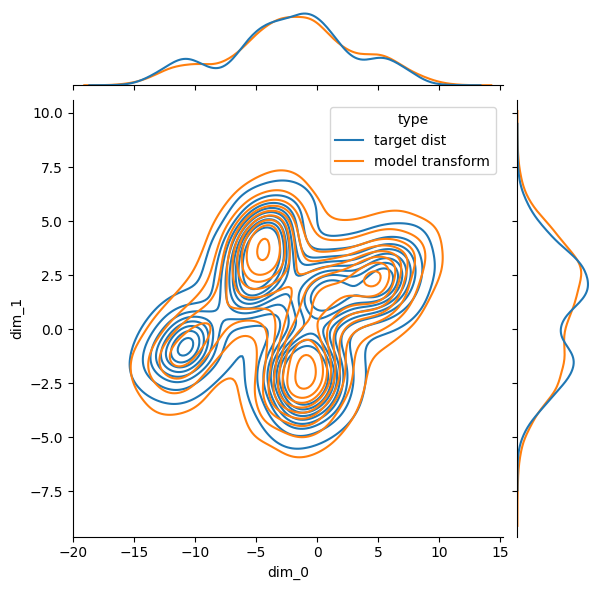

trail: 0 m step: 1 kl_test: 0.3614959716796875


  2%|▏         | 100/6000 [00:31<34:22,  2.86it/s]

trail: 0 m step: 2 Loss: 0.33021944937621345  L_n: 0.2860908508300781  kld: 0.007457733154296875 KLD1: 0.2752392888069153 KLD2: 0.19523504376411438


  3%|▎         | 200/6000 [01:02<33:23,  2.90it/s]

trail: 0 m step: 2 Loss: 0.33218984208868807  L_n: 0.289703369140625  kld: 0.007180213928222656 KLD1: 0.28008517622947693 KLD2: 0.19885146617889404


  5%|▌         | 300/6000 [01:33<32:46,  2.90it/s]

trail: 0 m step: 2 Loss: 0.31641959015434307  L_n: 0.2698249816894531  kld: 0.007874488830566406 KLD1: 0.2750623822212219 KLD2: 0.2007535696029663


  7%|▋         | 400/6000 [02:05<32:11,  2.90it/s]

trail: 0 m step: 2 Loss: 0.3310092666445399  L_n: 0.2761983871459961  kld: 0.009263038635253906 KLD1: 0.2595559358596802 KLD2: 0.20344096422195435


  8%|▊         | 500/6000 [02:36<31:38,  2.90it/s]

trail: 0 m step: 2 Loss: 0.3387120884551099  L_n: 0.28682994842529297  kld: 0.008768081665039062 KLD1: 0.26592546701431274 KLD2: 0.20317362248897552


 10%|█         | 600/6000 [03:07<31:09,  2.89it/s]

trail: 0 m step: 2 Loss: 0.330419416258321  L_n: 0.28136444091796875  kld: 0.008290290832519531 KLD1: 0.2742632329463959 KLD2: 0.19847850501537323


 12%|█▏        | 700/6000 [03:38<30:29,  2.90it/s]

trail: 0 m step: 2 Loss: 0.31026506141798027  L_n: 0.2549858093261719  kld: 0.009342193603515625 KLD1: 0.2615034580230713 KLD2: 0.2038687765598297


 13%|█▎        | 800/6000 [04:09<29:59,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3187759444558409  L_n: 0.2847709655761719  kld: 0.0057468414306640625 KLD1: 0.2848868668079376 KLD2: 0.19923198223114014


 15%|█▌        | 900/6000 [04:41<29:21,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3112303209022657  L_n: 0.2733316421508789  kld: 0.006404876708984375 KLD1: 0.27483347058296204 KLD2: 0.20194534957408905


 17%|█▋        | 1000/6000 [05:12<28:54,  2.88it/s]

trail: 0 m step: 2 Loss: 0.28880168418207114  L_n: 0.26097583770751953  kld: 0.004702568054199219 KLD1: 0.28643953800201416 KLD2: 0.20737971365451813


 18%|█▊        | 1100/6000 [05:43<28:24,  2.88it/s]

trail: 0 m step: 2 Loss: 0.2989160718297112  L_n: 0.26017093658447266  kld: 0.0065479278564453125 KLD1: 0.2707659602165222 KLD2: 0.19017426669597626


 20%|██        | 1200/6000 [06:15<27:45,  2.88it/s]

trail: 0 m step: 2 Loss: 0.32982096587412457  L_n: 0.26860523223876953  kld: 0.010345458984375 KLD1: 0.2603687345981598 KLD2: 0.20206645131111145


 22%|██▏       | 1300/6000 [06:46<27:07,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3118612639297395  L_n: 0.2586078643798828  kld: 0.008999824523925781 KLD1: 0.2580748498439789 KLD2: 0.2014513611793518


 23%|██▎       | 1400/6000 [07:17<26:33,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3420309653648963  L_n: 0.29192638397216797  kld: 0.008467674255371094 KLD1: 0.2677857279777527 KLD2: 0.19453802704811096


 25%|██▌       | 1500/6000 [07:49<25:59,  2.89it/s]

trail: 0 m step: 2 Loss: 0.330528360852123  L_n: 0.2806720733642578  kld: 0.008425712585449219 KLD1: 0.27913230657577515 KLD2: 0.2136782705783844


 27%|██▋       | 1600/6000 [08:20<25:20,  2.89it/s]

trail: 0 m step: 2 Loss: 0.32971681786712104  L_n: 0.2804079055786133  kld: 0.008333206176757812 KLD1: 0.2620003819465637 KLD2: 0.20573322474956512


 28%|██▊       | 1700/6000 [08:51<24:47,  2.89it/s]

trail: 0 m step: 2 Loss: 0.321498554839185  L_n: 0.2680702209472656  kld: 0.009029388427734375 KLD1: 0.2500612735748291 KLD2: 0.18800078332424164


 30%|███       | 1800/6000 [09:23<24:12,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3138055462809004  L_n: 0.2627134323120117  kld: 0.008634567260742188 KLD1: 0.27349281311035156 KLD2: 0.19543595612049103


 32%|███▏      | 1900/6000 [09:54<23:42,  2.88it/s]

trail: 0 m step: 2 Loss: 0.32318188593937797  L_n: 0.27527809143066406  kld: 0.008095741271972656 KLD1: 0.2754412889480591 KLD2: 0.18858912587165833


 33%|███▎      | 2000/6000 [10:25<23:05,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3284028126643254  L_n: 0.27719783782958984  kld: 0.008653640747070312 KLD1: 0.25847136974334717 KLD2: 0.1934346705675125


 35%|███▌      | 2100/6000 [10:56<22:27,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3007564431816868  L_n: 0.2636985778808594  kld: 0.006262779235839844 KLD1: 0.2665845453739166 KLD2: 0.19639763236045837


 37%|███▋      | 2200/6000 [11:28<21:49,  2.90it/s]

trail: 0 m step: 2 Loss: 0.31441391149216147  L_n: 0.26331615447998047  kld: 0.008635520935058594 KLD1: 0.2613941729068756 KLD2: 0.19944104552268982


 38%|███▊      | 2300/6000 [11:59<21:17,  2.90it/s]

trail: 0 m step: 2 Loss: 0.3080759443474944  L_n: 0.26850128173828125  kld: 0.006688117980957031 KLD1: 0.2763277590274811 KLD2: 0.1994146704673767


 40%|████      | 2400/6000 [12:30<20:46,  2.89it/s]

trail: 0 m step: 2 Loss: 0.32601688881597574  L_n: 0.27945613861083984  kld: 0.007868766784667969 KLD1: 0.2703888714313507 KLD2: 0.19371992349624634


 42%|████▏     | 2500/6000 [13:01<20:07,  2.90it/s]

trail: 0 m step: 2 Loss: 0.3140532025218715  L_n: 0.2655963897705078  kld: 0.008189201354980469 KLD1: 0.25838983058929443 KLD2: 0.1966070681810379


 43%|████▎     | 2600/6000 [13:33<19:38,  2.88it/s]

trail: 0 m step: 2 Loss: 0.30251760877801115  L_n: 0.2648954391479492  kld: 0.006358146667480469 KLD1: 0.26976147294044495 KLD2: 0.20083168148994446


 45%|████▌     | 2700/6000 [14:04<19:02,  2.89it/s]

trail: 0 m step: 2 Loss: 0.30736836879211066  L_n: 0.2652769088745117  kld: 0.007113456726074219 KLD1: 0.2755992114543915 KLD2: 0.18984386324882507


 47%|████▋     | 2800/6000 [14:35<18:20,  2.91it/s]

trail: 0 m step: 2 Loss: 0.3137028767512395  L_n: 0.26345157623291016  kld: 0.008492469787597656 KLD1: 0.2657391428947449 KLD2: 0.19507454335689545


 48%|████▊     | 2900/6000 [15:06<17:48,  2.90it/s]

trail: 0 m step: 2 Loss: 0.3264584343814285  L_n: 0.26756763458251953  kld: 0.009952545166015625 KLD1: 0.2509590685367584 KLD2: 0.1812964230775833


 50%|█████     | 3000/6000 [15:38<17:18,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3015451882717877  L_n: 0.25904178619384766  kld: 0.007183074951171875 KLD1: 0.26181870698928833 KLD2: 0.20127150416374207


 52%|█████▏    | 3100/6000 [16:09<16:44,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3017069968951524  L_n: 0.2601346969604492  kld: 0.007025718688964844 KLD1: 0.2758341133594513 KLD2: 0.20212006568908691


 53%|█████▎    | 3200/6000 [16:40<16:09,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3131921587611091  L_n: 0.2651529312133789  kld: 0.008118629455566406 KLD1: 0.2680404484272003 KLD2: 0.1940150111913681


 55%|█████▌    | 3300/6000 [17:11<15:35,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3103940613876433  L_n: 0.25588226318359375  kld: 0.009212493896484375 KLD1: 0.2659004330635071 KLD2: 0.190141499042511


 57%|█████▋    | 3400/6000 [17:43<14:58,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3168204324485282  L_n: 0.2771272659301758  kld: 0.0067081451416015625 KLD1: 0.28556472063064575 KLD2: 0.19371351599693298


 58%|█████▊    | 3500/6000 [18:14<14:24,  2.89it/s]

trail: 0 m step: 2 Loss: 0.29700267949753256  L_n: 0.2525806427001953  kld: 0.00750732421875 KLD1: 0.26524022221565247 KLD2: 0.1977606564760208


 60%|██████    | 3600/6000 [18:45<13:47,  2.90it/s]

trail: 0 m step: 2 Loss: 0.294520186249321  L_n: 0.2577219009399414  kld: 0.006218910217285156 KLD1: 0.2741679549217224 KLD2: 0.1980970948934555


 62%|██████▏   | 3700/6000 [19:16<13:16,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3324364769388233  L_n: 0.2743244171142578  kld: 0.009820938110351562 KLD1: 0.25482019782066345 KLD2: 0.1956280618906021


 63%|██████▎   | 3800/6000 [19:48<12:41,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3052598513089693  L_n: 0.26630592346191406  kld: 0.006583213806152344 KLD1: 0.2694946825504303 KLD2: 0.19232751429080963


 65%|██████▌   | 3900/6000 [20:19<12:02,  2.91it/s]

trail: 0 m step: 2 Loss: 0.3060235356438089  L_n: 0.25908470153808594  kld: 0.007932662963867188 KLD1: 0.2603696584701538 KLD2: 0.19323895871639252


 67%|██████▋   | 4000/6000 [20:50<11:30,  2.90it/s]

trail: 0 m step: 2 Loss: 0.3050792005640515  L_n: 0.26718616485595703  kld: 0.006403923034667969 KLD1: 0.27816033363342285 KLD2: 0.2053430825471878


 68%|██████▊   | 4100/6000 [21:22<10:58,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3164725839739015  L_n: 0.26337718963623047  kld: 0.008973121643066406 KLD1: 0.24653618037700653 KLD2: 0.19353549182415009


 70%|███████   | 4200/6000 [21:53<10:23,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3199297718747833  L_n: 0.27018070220947266  kld: 0.0084075927734375 KLD1: 0.26600438356399536 KLD2: 0.18655160069465637


 72%|███████▏  | 4300/6000 [22:24<09:48,  2.89it/s]

trail: 0 m step: 2 Loss: 0.28673190054808845  L_n: 0.24641799926757812  kld: 0.00681304931640625 KLD1: 0.26725703477859497 KLD2: 0.19523310661315918


 73%|███████▎  | 4400/6000 [22:55<09:13,  2.89it/s]

trail: 0 m step: 2 Loss: 0.31732334610978524  L_n: 0.2670269012451172  kld: 0.008500099182128906 KLD1: 0.25639867782592773 KLD2: 0.19393064081668854


 75%|███████▌  | 4500/6000 [23:26<08:38,  2.89it/s]

trail: 0 m step: 2 Loss: 0.33169305112940317  L_n: 0.2806968688964844  kld: 0.008618354797363281 KLD1: 0.253753125667572 KLD2: 0.1869090348482132


 77%|███████▋  | 4600/6000 [23:58<08:02,  2.90it/s]

trail: 0 m step: 2 Loss: 0.3371522214991101  L_n: 0.2849540710449219  kld: 0.008821487426757812 KLD1: 0.26502522826194763 KLD2: 0.19366896152496338


 78%|███████▊  | 4700/6000 [24:29<07:28,  2.90it/s]

trail: 0 m step: 2 Loss: 0.31931952753010584  L_n: 0.2682838439941406  kld: 0.008625030517578125 KLD1: 0.2555438280105591 KLD2: 0.19028499722480774


 80%|████████  | 4800/6000 [25:00<07:01,  2.85it/s]

trail: 0 m step: 2 Loss: 0.3324239888840173  L_n: 0.2744417190551758  kld: 0.009799003601074219 KLD1: 0.2500336468219757 KLD2: 0.20839838683605194


 82%|████████▏ | 4900/6000 [25:31<06:19,  2.90it/s]

trail: 0 m step: 2 Loss: 0.30112944834331085  L_n: 0.25788116455078125  kld: 0.0073089599609375 KLD1: 0.2532002329826355 KLD2: 0.18993012607097626


 83%|████████▎ | 5000/6000 [26:03<05:45,  2.89it/s]

trail: 0 m step: 2 Loss: 0.30011098060382185  L_n: 0.2590465545654297  kld: 0.006939888000488281 KLD1: 0.26996973156929016 KLD2: 0.19657765328884125


 85%|████████▌ | 5100/6000 [26:34<05:12,  2.88it/s]

trail: 0 m step: 2 Loss: 0.3089149802394167  L_n: 0.2640810012817383  kld: 0.007576942443847656 KLD1: 0.25493425130844116 KLD2: 0.1892692893743515


 87%|████████▋ | 5200/6000 [27:05<04:36,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3030518131143243  L_n: 0.25127124786376953  kld: 0.00875091552734375 KLD1: 0.25483840703964233 KLD2: 0.19652318954467773


 88%|████████▊ | 5300/6000 [27:36<04:02,  2.89it/s]

trail: 0 m step: 2 Loss: 0.31926557439318776  L_n: 0.2747983932495117  kld: 0.00751495361328125 KLD1: 0.26415205001831055 KLD2: 0.1811567097902298


 90%|█████████ | 5400/6000 [28:08<03:27,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3255769910191643  L_n: 0.2792024612426758  kld: 0.007837295532226562 KLD1: 0.26114460825920105 KLD2: 0.20548006892204285


 92%|█████████▏| 5500/6000 [28:39<02:53,  2.89it/s]

trail: 0 m step: 2 Loss: 0.3268145160562188  L_n: 0.2721729278564453  kld: 0.009234428405761719 KLD1: 0.26198261976242065 KLD2: 0.18992958962917328


 93%|█████████▎| 5600/6000 [29:10<02:18,  2.89it/s]

trail: 0 m step: 2 Loss: 0.30288455331113917  L_n: 0.2593202590942383  kld: 0.00736236572265625 KLD1: 0.2611936330795288 KLD2: 0.19730857014656067


 95%|█████████▌| 5700/6000 [29:41<01:43,  2.89it/s]

trail: 0 m step: 2 Loss: 0.29505597628079927  L_n: 0.24795913696289062  kld: 0.007959365844726562 KLD1: 0.26436692476272583 KLD2: 0.19158202409744263


 97%|█████████▋| 5800/6000 [30:13<01:08,  2.90it/s]

trail: 0 m step: 2 Loss: 0.31285281435272394  L_n: 0.26761817932128906  kld: 0.0076446533203125 KLD1: 0.26306092739105225 KLD2: 0.19002096354961395


 98%|█████████▊| 5900/6000 [30:44<00:34,  2.89it/s]

trail: 0 m step: 2 Loss: 0.31153365140835915  L_n: 0.26430702209472656  kld: 0.007981300354003906 KLD1: 0.2678138017654419 KLD2: 0.18768925964832306


100%|██████████| 6000/6000 [31:15<00:00,  3.20it/s]

trail: 0 m step: 2 Loss: 0.33008882985312554  L_n: 0.28078556060791016  kld: 0.008332252502441406 KLD1: 0.25428006052970886 KLD2: 0.20643822848796844



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


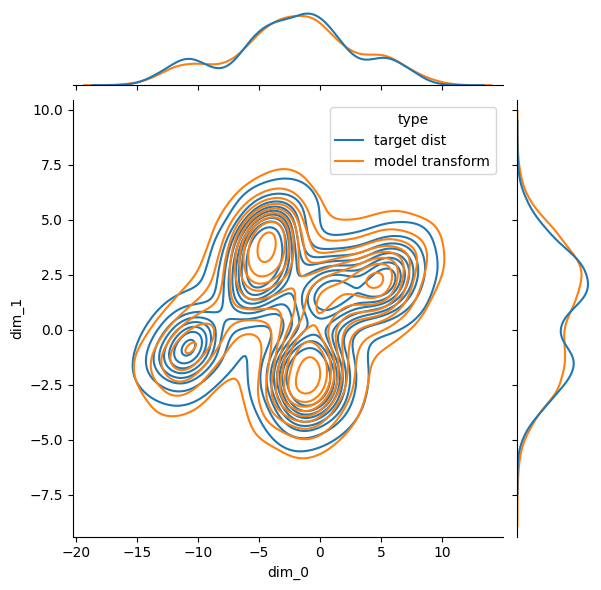

trail: 0 m step: 2 kl_test: 0.26876068115234375


  2%|▏         | 100/6000 [00:31<34:12,  2.87it/s]

trail: 0 m step: 3 Loss: 0.2383211628111265  L_n: 0.20421981811523438  kld: 0.0074920654296875 KLD1: 0.19884474575519562 KLD2: 0.14290405809879303


  3%|▎         | 200/6000 [01:02<33:10,  2.91it/s]

trail: 0 m step: 3 Loss: 0.23717521568510172  L_n: 0.2036294937133789  kld: 0.0073699951171875 KLD1: 0.20228277146816254 KLD2: 0.1441938281059265


  5%|▌         | 300/6000 [01:33<33:14,  2.86it/s]

trail: 0 m step: 3 Loss: 0.23199774299798687  L_n: 0.1955089569091797  kld: 0.008016586303710938 KLD1: 0.19784840941429138 KLD2: 0.1465059369802475


  7%|▋         | 400/6000 [02:04<32:14,  2.89it/s]

trail: 0 m step: 3 Loss: 0.23508444817759636  L_n: 0.19312191009521484  kld: 0.009219169616699219 KLD1: 0.18493615090847015 KLD2: 0.14801260828971863


  8%|▊         | 500/6000 [02:36<31:40,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2460722105037531  L_n: 0.2031850814819336  kld: 0.00942230224609375 KLD1: 0.19134508073329926 KLD2: 0.14775751531124115


 10%|█         | 600/6000 [03:07<31:01,  2.90it/s]

trail: 0 m step: 3 Loss: 0.23855644255591676  L_n: 0.20338726043701172  kld: 0.0077266693115234375 KLD1: 0.19076025485992432 KLD2: 0.14455239474773407


 12%|█▏        | 700/6000 [03:38<30:29,  2.90it/s]

trail: 0 m step: 3 Loss: 0.2287597339371415  L_n: 0.18116283416748047  kld: 0.010457038879394531 KLD1: 0.1785339117050171 KLD2: 0.14969025552272797


 13%|█▎        | 800/6000 [04:09<29:52,  2.90it/s]

trail: 0 m step: 3 Loss: 0.2252737048760728  L_n: 0.19287395477294922  kld: 0.00711822509765625 KLD1: 0.207383394241333 KLD2: 0.14342354238033295


 15%|█▌        | 900/6000 [04:40<29:20,  2.90it/s]

trail: 0 m step: 3 Loss: 0.2217635248919536  L_n: 0.19169044494628906  kld: 0.0066070556640625 KLD1: 0.20355021953582764 KLD2: 0.1473883092403412


 17%|█▋        | 1000/6000 [05:12<28:51,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2101387393762157  L_n: 0.1832561492919922  kld: 0.005906105041503906 KLD1: 0.20783714950084686 KLD2: 0.15123580396175385


 18%|█▊        | 1100/6000 [05:43<28:08,  2.90it/s]

trail: 0 m step: 3 Loss: 0.21519631128393632  L_n: 0.1816549301147461  kld: 0.007369041442871094 KLD1: 0.18968209624290466 KLD2: 0.13749465346336365


 20%|██        | 1200/6000 [06:14<27:41,  2.89it/s]

trail: 0 m step: 3 Loss: 0.23951500331373393  L_n: 0.1938323974609375  kld: 0.010036468505859375 KLD1: 0.18577152490615845 KLD2: 0.14818604290485382


 22%|██▏       | 1300/6000 [06:45<27:06,  2.89it/s]

trail: 0 m step: 3 Loss: 0.22320304179549705  L_n: 0.18321990966796875  kld: 0.008784294128417969 KLD1: 0.19165033102035522 KLD2: 0.1456736922264099


 23%|██▎       | 1400/6000 [07:16<26:29,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2505237486452529  L_n: 0.2016897201538086  kld: 0.010728836059570312 KLD1: 0.18785595893859863 KLD2: 0.13872572779655457


 25%|██▌       | 1500/6000 [07:47<25:54,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2442858812751475  L_n: 0.2038860321044922  kld: 0.008875846862792969 KLD1: 0.1974957287311554 KLD2: 0.1580144315958023


 27%|██▋       | 1600/6000 [08:19<25:14,  2.91it/s]

trail: 0 m step: 3 Loss: 0.23785871888596088  L_n: 0.19345664978027344  kld: 0.009755134582519531 KLD1: 0.18193712830543518 KLD2: 0.14731140434741974


 28%|██▊       | 1700/6000 [08:50<24:42,  2.90it/s]

trail: 0 m step: 3 Loss: 0.2276078047511466  L_n: 0.1879415512084961  kld: 0.008714675903320312 KLD1: 0.17876894772052765 KLD2: 0.13594800233840942


 30%|███       | 1800/6000 [09:21<24:07,  2.90it/s]

trail: 0 m step: 3 Loss: 0.23168054189148088  L_n: 0.18881511688232422  kld: 0.009417533874511719 KLD1: 0.19240599870681763 KLD2: 0.1419621855020523


 32%|███▏      | 1900/6000 [09:52<23:34,  2.90it/s]

trail: 0 m step: 3 Loss: 0.23969664332754892  L_n: 0.20220947265625  kld: 0.008235931396484375 KLD1: 0.1988956779241562 KLD2: 0.13756513595581055


 33%|███▎      | 2000/6000 [10:23<23:03,  2.89it/s]

trail: 0 m step: 3 Loss: 0.23556876236816185  L_n: 0.199249267578125  kld: 0.007979393005371094 KLD1: 0.1861494928598404 KLD2: 0.14267361164093018


 35%|███▌      | 2100/6000 [10:55<22:27,  2.89it/s]

trail: 0 m step: 3 Loss: 0.2167410683404005  L_n: 0.18334293365478516  kld: 0.0073375701904296875 KLD1: 0.1802312433719635 KLD2: 0.13957452774047852


 37%|███▋      | 2200/6000 [11:26<21:55,  2.89it/s]

trail: 0 m step: 3 Loss: 0.22561471311406867  L_n: 0.18753719329833984  kld: 0.008365631103515625 KLD1: 0.18135526776313782 KLD2: 0.14547845721244812


 38%|███▊      | 2300/6000 [11:57<21:18,  2.90it/s]

trail: 0 m step: 3 Loss: 0.22199770120474008  L_n: 0.19192028045654297  kld: 0.006608009338378906 KLD1: 0.19683676958084106 KLD2: 0.14349530637264252


 40%|████      | 2400/6000 [12:28<20:40,  2.90it/s]

trail: 0 m step: 3 Loss: 0.23882480746353002  L_n: 0.20038700103759766  kld: 0.008444786071777344 KLD1: 0.19329512119293213 KLD2: 0.13964799046516418


 42%|████▏     | 2500/6000 [12:59<20:05,  2.90it/s]

trail: 0 m step: 3 Loss: 0.22574758204102896  L_n: 0.1861724853515625  kld: 0.008694648742675781 KLD1: 0.18564973771572113 KLD2: 0.142085000872612


 43%|████▎     | 2600/6000 [13:31<19:33,  2.90it/s]

trail: 0 m step: 3 Loss: 0.23123077137338938  L_n: 0.20043277740478516  kld: 0.006766319274902344 KLD1: 0.19145159423351288 KLD2: 0.14653803408145905


 45%|████▌     | 2700/6000 [14:02<18:58,  2.90it/s]

trail: 0 m step: 3 Loss: 0.21808126941831968  L_n: 0.18415355682373047  kld: 0.00745391845703125 KLD1: 0.18882596492767334 KLD2: 0.1358698457479477


 47%|████▋     | 2800/6000 [14:33<18:23,  2.90it/s]

trail: 0 m step: 3 Loss: 0.23015779183569635  L_n: 0.18525218963623047  kld: 0.009865760803222656 KLD1: 0.1766549050807953 KLD2: 0.14210256934165955


 48%|████▊     | 2900/6000 [15:04<17:48,  2.90it/s]

trail: 0 m step: 3 Loss: 0.2380798740933904  L_n: 0.1961650848388672  kld: 0.00920867919921875 KLD1: 0.17843014001846313 KLD2: 0.13073766231536865


 50%|█████     | 3000/6000 [15:35<17:16,  2.89it/s]

trail: 0 m step: 3 Loss: 0.21759358155602587  L_n: 0.18138694763183594  kld: 0.007954597473144531 KLD1: 0.1819896250963211 KLD2: 0.1472468376159668


 52%|█████▏    | 3100/6000 [16:06<16:36,  2.91it/s]

trail: 0 m step: 3 Loss: 0.21927045918509372  L_n: 0.18467426300048828  kld: 0.0076007843017578125 KLD1: 0.1906445473432541 KLD2: 0.1468370407819748


 53%|█████▎    | 3200/6000 [16:38<16:02,  2.91it/s]

trail: 0 m step: 3 Loss: 0.22737606493082163  L_n: 0.19031429290771484  kld: 0.008142471313476562 KLD1: 0.18929852545261383 KLD2: 0.14249187707901


 55%|█████▌    | 3300/6000 [17:09<15:26,  2.91it/s]

trail: 0 m step: 3 Loss: 0.22578986015545546  L_n: 0.1781625747680664  kld: 0.010463714599609375 KLD1: 0.18402181565761566 KLD2: 0.13448090851306915


 57%|█████▋    | 3400/6000 [17:40<14:55,  2.90it/s]

trail: 0 m step: 3 Loss: 0.23628798039001825  L_n: 0.20113182067871094  kld: 0.007723808288574219 KLD1: 0.19580841064453125 KLD2: 0.13753151893615723


 58%|█████▊    | 3500/6000 [18:11<14:23,  2.90it/s]

trail: 0 m step: 3 Loss: 0.20681403884575159  L_n: 0.1707897186279297  kld: 0.007914543151855469 KLD1: 0.17620563507080078 KLD2: 0.1419340819120407


 60%|██████    | 3600/6000 [18:42<13:48,  2.90it/s]

trail: 0 m step: 3 Loss: 0.2165205134659612  L_n: 0.18839645385742188  kld: 0.006178855895996094 KLD1: 0.20271305739879608 KLD2: 0.14387880265712738


 62%|██████▏   | 3700/6000 [19:13<13:15,  2.89it/s]

trail: 0 m step: 3 Loss: 0.24211286337309443  L_n: 0.1953754425048828  kld: 0.010268211364746094 KLD1: 0.17821352183818817 KLD2: 0.14188914000988007


 63%|██████▎   | 3800/6000 [19:44<12:39,  2.90it/s]

trail: 0 m step: 3 Loss: 0.21699962129796913  L_n: 0.18422222137451172  kld: 0.007201194763183594 KLD1: 0.18842746317386627 KLD2: 0.13854628801345825


 65%|██████▌   | 3900/6000 [20:16<12:03,  2.90it/s]

trail: 0 m step: 3 Loss: 0.21594244271557494  L_n: 0.1773700714111328  kld: 0.008474349975585938 KLD1: 0.18362829089164734 KLD2: 0.14103348553180695


 67%|██████▋   | 4000/6000 [20:47<11:27,  2.91it/s]

trail: 0 m step: 3 Loss: 0.22707962110794616  L_n: 0.19365978240966797  kld: 0.007342338562011719 KLD1: 0.18948215246200562 KLD2: 0.14951051771640778


 68%|██████▊   | 4100/6000 [21:18<10:53,  2.91it/s]

trail: 0 m step: 3 Loss: 0.23028306045150237  L_n: 0.18837261199951172  kld: 0.009207725524902344 KLD1: 0.177069291472435 KLD2: 0.14009007811546326


 70%|███████   | 4200/6000 [21:49<10:19,  2.90it/s]

trail: 0 m step: 3 Loss: 0.22710120140773685  L_n: 0.1870746612548828  kld: 0.008793830871582031 KLD1: 0.18591909110546112 KLD2: 0.13352826237678528


 72%|███████▏  | 4300/6000 [22:20<09:47,  2.90it/s]

trail: 0 m step: 3 Loss: 0.2109440220558052  L_n: 0.17596149444580078  kld: 0.007685661315917969 KLD1: 0.18140770494937897 KLD2: 0.14052990078926086


 73%|███████▎  | 4400/6000 [22:51<09:10,  2.91it/s]

trail: 0 m step: 3 Loss: 0.23071135137642196  L_n: 0.1906414031982422  kld: 0.008803367614746094 KLD1: 0.17493918538093567 KLD2: 0.1394408494234085


 75%|███████▌  | 4500/6000 [23:23<08:38,  2.89it/s]

trail: 0 m step: 3 Loss: 0.23813436028085952  L_n: 0.19587230682373047  kld: 0.00928497314453125 KLD1: 0.1806764155626297 KLD2: 0.13322597742080688


 77%|███████▋  | 4600/6000 [23:54<08:02,  2.90it/s]

trail: 0 m step: 3 Loss: 0.23798862391295192  L_n: 0.19655132293701172  kld: 0.009103775024414062 KLD1: 0.1878526359796524 KLD2: 0.1395484060049057


 78%|███████▊  | 4700/6000 [24:25<07:27,  2.91it/s]

trail: 0 m step: 3 Loss: 0.24052468743929822  L_n: 0.19528484344482422  kld: 0.009939193725585938 KLD1: 0.1712108552455902 KLD2: 0.135268434882164


 80%|████████  | 4800/6000 [24:56<06:53,  2.90it/s]

trail: 0 m step: 3 Loss: 0.23994547809640765  L_n: 0.19469261169433594  kld: 0.009942054748535156 KLD1: 0.1773792952299118 KLD2: 0.15292921662330627


 82%|████████▏ | 4900/6000 [25:27<06:18,  2.90it/s]

trail: 0 m step: 3 Loss: 0.2194781492230672  L_n: 0.18389225006103516  kld: 0.007818222045898438 KLD1: 0.18463832139968872 KLD2: 0.13645784556865692


 83%|████████▎ | 5000/6000 [25:58<05:45,  2.90it/s]

trail: 0 m step: 3 Loss: 0.22020801783801752  L_n: 0.18547725677490234  kld: 0.007630348205566406 KLD1: 0.1903669238090515 KLD2: 0.14332789182662964


 85%|████████▌ | 5100/6000 [26:30<05:09,  2.91it/s]

trail: 0 m step: 3 Loss: 0.22000620698299417  L_n: 0.18335247039794922  kld: 0.008052825927734375 KLD1: 0.18060119450092316 KLD2: 0.13686509430408478


 87%|████████▋ | 5200/6000 [27:01<04:35,  2.90it/s]

trail: 0 m step: 3 Loss: 0.21633893465746193  L_n: 0.17253589630126953  kld: 0.009623527526855469 KLD1: 0.1787179410457611 KLD2: 0.14099761843681335


 88%|████████▊ | 5300/6000 [27:32<04:01,  2.90it/s]

trail: 0 m step: 3 Loss: 0.2330625149462513  L_n: 0.1973724365234375  kld: 0.007841110229492188 KLD1: 0.175652414560318 KLD2: 0.1283581256866455


 90%|█████████ | 5400/6000 [28:03<03:26,  2.90it/s]

trail: 0 m step: 3 Loss: 0.23069868448055164  L_n: 0.19019031524658203  kld: 0.008899688720703125 KLD1: 0.18646541237831116 KLD2: 0.1479865163564682


 92%|█████████▏| 5500/6000 [28:34<02:52,  2.90it/s]

trail: 0 m step: 3 Loss: 0.23297173617696784  L_n: 0.18902111053466797  kld: 0.009655952453613281 KLD1: 0.18890613317489624 KLD2: 0.13581611216068268


 93%|█████████▎| 5600/6000 [29:05<02:18,  2.90it/s]

trail: 0 m step: 3 Loss: 0.21416803723744604  L_n: 0.18186378479003906  kld: 0.0070972442626953125 KLD1: 0.1878112405538559 KLD2: 0.1430576592683792


 95%|█████████▌| 5700/6000 [29:36<01:43,  2.91it/s]

trail: 0 m step: 3 Loss: 0.2075217997534035  L_n: 0.1669483184814453  kld: 0.008913993835449219 KLD1: 0.18044866621494293 KLD2: 0.1380806416273117


 97%|█████████▋| 5800/6000 [30:08<01:09,  2.89it/s]

trail: 0 m step: 3 Loss: 0.22211769791587027  L_n: 0.18713951110839844  kld: 0.0076847076416015625 KLD1: 0.18834708631038666 KLD2: 0.13765853643417358


 98%|█████████▊| 5900/6000 [30:39<00:34,  2.90it/s]

trail: 0 m step: 3 Loss: 0.22605225906406795  L_n: 0.19084835052490234  kld: 0.0077342987060546875 KLD1: 0.19295436143875122 KLD2: 0.13540010154247284


100%|██████████| 6000/6000 [31:10<00:00,  3.21it/s]

trail: 0 m step: 3 Loss: 0.2407907473807667  L_n: 0.20160198211669922  kld: 0.008609771728515625 KLD1: 0.18133065104484558 KLD2: 0.15124225616455078



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


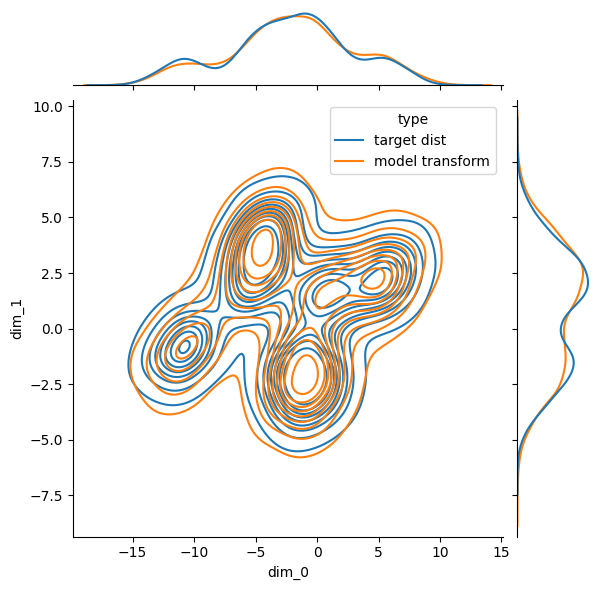

trail: 0 m step: 3 kl_test: 0.19063186645507812


  2%|▏         | 100/6000 [00:31<34:16,  2.87it/s]

trail: 0 m step: 4 Loss: 0.16660616033146775  L_n: 0.13990020751953125  kld: 0.0076274871826171875 KLD1: 0.1365516036748886 KLD2: 0.09877081960439682


  3%|▎         | 200/6000 [01:02<33:11,  2.91it/s]

trail: 0 m step: 4 Loss: 0.16860389899800152  L_n: 0.14508342742919922  kld: 0.006717681884765625 KLD1: 0.14061570167541504 KLD2: 0.10206783562898636


  5%|▌         | 300/6000 [01:33<32:41,  2.91it/s]

trail: 0 m step: 4 Loss: 0.16123671007608817  L_n: 0.13264083862304688  kld: 0.008167266845703125 KLD1: 0.13155798614025116 KLD2: 0.10195746272802353


  7%|▋         | 400/6000 [02:04<32:08,  2.90it/s]

trail: 0 m step: 4 Loss: 0.16987447657507843  L_n: 0.1377391815185547  kld: 0.00917816162109375 KLD1: 0.12919114530086517 KLD2: 0.1061125248670578


  8%|▊         | 500/6000 [02:36<31:32,  2.91it/s]

trail: 0 m step: 4 Loss: 0.17304794912156943  L_n: 0.14319324493408203  kld: 0.008526802062988281 KLD1: 0.12961648404598236 KLD2: 0.10617100447416306


 10%|█         | 600/6000 [03:07<30:58,  2.91it/s]

trail: 0 m step: 4 Loss: 0.16499118204565258  L_n: 0.13678932189941406  kld: 0.008054733276367188 KLD1: 0.14205314218997955 KLD2: 0.09933942556381226


 12%|█▏        | 700/6000 [03:38<30:26,  2.90it/s]

trail: 0 m step: 4 Loss: 0.15584358645271826  L_n: 0.12620258331298828  kld: 0.008465766906738281 KLD1: 0.1288967728614807 KLD2: 0.1069871187210083


 13%|█▎        | 800/6000 [04:09<29:56,  2.89it/s]

trail: 0 m step: 4 Loss: 0.15526437066540547  L_n: 0.1304616928100586  kld: 0.007083892822265625 KLD1: 0.14156194031238556 KLD2: 0.10058674961328506


 15%|█▌        | 900/6000 [04:40<29:20,  2.90it/s]

trail: 0 m step: 4 Loss: 0.15478965625981314  L_n: 0.1333160400390625  kld: 0.006133079528808594 KLD1: 0.1421046406030655 KLD2: 0.10668022185564041


 17%|█▋        | 1000/6000 [05:11<28:48,  2.89it/s]

trail: 0 m step: 4 Loss: 0.14396855113327758  L_n: 0.1257638931274414  kld: 0.005199432373046875 KLD1: 0.13919614255428314 KLD2: 0.10624003410339355


 18%|█▊        | 1100/6000 [05:43<28:08,  2.90it/s]

trail: 0 m step: 4 Loss: 0.1458261828851451  L_n: 0.12143421173095703  kld: 0.006966590881347656 KLD1: 0.13089850544929504 KLD2: 0.09710153192281723


 20%|██        | 1200/6000 [06:14<27:37,  2.90it/s]

trail: 0 m step: 4 Loss: 0.16387022688986436  L_n: 0.12497329711914062  kld: 0.011109352111816406 KLD1: 0.12220539152622223 KLD2: 0.10454846173524857


 22%|██▏       | 1300/6000 [06:45<27:05,  2.89it/s]

trail: 0 m step: 4 Loss: 0.15559179876945978  L_n: 0.12338638305664062  kld: 0.009198188781738281 KLD1: 0.13197414577007294 KLD2: 0.10186736285686493


 23%|██▎       | 1400/6000 [07:16<26:29,  2.89it/s]

trail: 0 m step: 4 Loss: 0.17967807154316373  L_n: 0.1414957046508789  kld: 0.010905265808105469 KLD1: 0.12410841882228851 KLD2: 0.09626956284046173


 25%|██▌       | 1500/6000 [07:48<25:55,  2.89it/s]

trail: 0 m step: 4 Loss: 0.16980339279487341  L_n: 0.1390705108642578  kld: 0.008777618408203125 KLD1: 0.13604576885700226 KLD2: 0.11256237328052521


 27%|██▋       | 1600/6000 [08:19<25:24,  2.89it/s]

trail: 0 m step: 4 Loss: 0.16091644065661664  L_n: 0.1292552947998047  kld: 0.009042739868164062 KLD1: 0.12354970723390579 KLD2: 0.10565290600061417


 28%|██▊       | 1700/6000 [08:50<24:42,  2.90it/s]

trail: 0 m step: 4 Loss: 0.1666219828238253  L_n: 0.13053321838378906  kld: 0.01030731201171875 KLD1: 0.11914636194705963 KLD2: 0.09491173923015594


 30%|███       | 1800/6000 [09:21<24:06,  2.90it/s]

trail: 0 m step: 4 Loss: 0.16390653169270736  L_n: 0.13266944885253906  kld: 0.008921623229980469 KLD1: 0.13122011721134186 KLD2: 0.10049799084663391


 32%|███▏      | 1900/6000 [09:52<23:32,  2.90it/s]

trail: 0 m step: 4 Loss: 0.16804909852200423  L_n: 0.13995742797851562  kld: 0.008023262023925781 KLD1: 0.132310688495636 KLD2: 0.09337341040372849


 33%|███▎      | 2000/6000 [10:23<22:57,  2.90it/s]

trail: 0 m step: 4 Loss: 0.16410423384457049  L_n: 0.13860034942626953  kld: 0.0072841644287109375 KLD1: 0.12919948995113373 KLD2: 0.09984166920185089


 35%|███▌      | 2100/6000 [10:55<22:23,  2.90it/s]

trail: 0 m step: 4 Loss: 0.15017903308141156  L_n: 0.12632465362548828  kld: 0.00681304931640625 KLD1: 0.12647809088230133 KLD2: 0.09681675583124161


 37%|███▋      | 2200/6000 [11:26<21:48,  2.90it/s]

trail: 0 m step: 4 Loss: 0.15240169053134295  L_n: 0.12299442291259766  kld: 0.008399009704589844 KLD1: 0.12239088863134384 KLD2: 0.1025257408618927


 38%|███▊      | 2300/6000 [11:57<21:15,  2.90it/s]

trail: 0 m step: 4 Loss: 0.1596098544196018  L_n: 0.1333179473876953  kld: 0.0075092315673828125 KLD1: 0.13326606154441833 KLD2: 0.10156051814556122


 40%|████      | 2400/6000 [12:28<20:43,  2.89it/s]

trail: 0 m step: 4 Loss: 0.16617678203551375  L_n: 0.13747406005859375  kld: 0.008197784423828125 KLD1: 0.1365654468536377 KLD2: 0.10065577924251556


 42%|████▏     | 2500/6000 [12:59<20:05,  2.90it/s]

trail: 0 m step: 4 Loss: 0.15759914152837842  L_n: 0.12447547912597656  kld: 0.00946044921875 KLD1: 0.12497636675834656 KLD2: 0.10124731808900833


 43%|████▎     | 2600/6000 [13:30<19:31,  2.90it/s]

trail: 0 m step: 4 Loss: 0.1569917603436607  L_n: 0.13271331787109375  kld: 0.006934165954589844 KLD1: 0.1305730789899826 KLD2: 0.10205978900194168


 45%|████▌     | 2700/6000 [14:02<18:57,  2.90it/s]

trail: 0 m step: 4 Loss: 0.15825252967707054  L_n: 0.13263511657714844  kld: 0.00731658935546875 KLD1: 0.1324830800294876 KLD2: 0.09518659114837646


 47%|████▋     | 2800/6000 [14:33<18:20,  2.91it/s]

trail: 0 m step: 4 Loss: 0.15824786247957828  L_n: 0.12712764739990234  kld: 0.00888824462890625 KLD1: 0.13019759953022003 KLD2: 0.10033617913722992


 48%|████▊     | 2900/6000 [15:04<17:50,  2.90it/s]

trail: 0 m step: 4 Loss: 0.16468769547101275  L_n: 0.13185787200927734  kld: 0.00937652587890625 KLD1: 0.12190426886081696 KLD2: 0.09053178131580353


 50%|█████     | 3000/6000 [15:35<17:15,  2.90it/s]

trail: 0 m step: 4 Loss: 0.15698494965787785  L_n: 0.12915706634521484  kld: 0.007947921752929688 KLD1: 0.1290488988161087 KLD2: 0.10262534022331238


 52%|█████▏    | 3100/6000 [16:06<16:41,  2.90it/s]

trail: 0 m step: 4 Loss: 0.14715250194300197  L_n: 0.12081050872802734  kld: 0.007523536682128906 KLD1: 0.12669163942337036 KLD2: 0.10415902733802795


 53%|█████▎    | 3200/6000 [16:37<16:06,  2.90it/s]

trail: 0 m step: 4 Loss: 0.16021675143788322  L_n: 0.1303253173828125  kld: 0.00853729248046875 KLD1: 0.12822040915489197 KLD2: 0.09996092319488525


 55%|█████▌    | 3300/6000 [17:09<15:28,  2.91it/s]

trail: 0 m step: 4 Loss: 0.1667411479373626  L_n: 0.12946701049804688  kld: 0.010645866394042969 KLD1: 0.1246890127658844 KLD2: 0.09366507083177567


 57%|█████▋    | 3400/6000 [17:40<14:58,  2.89it/s]

trail: 0 m step: 4 Loss: 0.16216858972384018  L_n: 0.13710880279541016  kld: 0.007157325744628906 KLD1: 0.1372939944267273 KLD2: 0.09622086584568024


 58%|█████▊    | 3500/6000 [18:11<14:20,  2.90it/s]

trail: 0 m step: 4 Loss: 0.14234718355343315  L_n: 0.11663627624511719  kld: 0.007343292236328125 KLD1: 0.1243947371840477 KLD2: 0.1011064425110817


 60%|██████    | 3600/6000 [18:42<13:49,  2.89it/s]

trail: 0 m step: 4 Loss: 0.14501732171472934  L_n: 0.12494277954101562  kld: 0.005733489990234375 KLD1: 0.13498297333717346 KLD2: 0.09839417785406113


 62%|██████▏   | 3700/6000 [19:13<13:11,  2.90it/s]

trail: 0 m step: 4 Loss: 0.16998764330054994  L_n: 0.13350486755371094  kld: 0.010419845581054688 KLD1: 0.11924514919519424 KLD2: 0.0966857373714447


 63%|██████▎   | 3800/6000 [19:44<12:37,  2.90it/s]

trail: 0 m step: 4 Loss: 0.15396695160230522  L_n: 0.1290140151977539  kld: 0.007126808166503906 KLD1: 0.12757627665996552 KLD2: 0.09640570729970932


 65%|██████▌   | 3900/6000 [20:16<12:05,  2.89it/s]

trail: 0 m step: 4 Loss: 0.15020476919876535  L_n: 0.122467041015625  kld: 0.007922172546386719 KLD1: 0.11719679832458496 KLD2: 0.09952542185783386


 67%|██████▋   | 4000/6000 [20:47<11:29,  2.90it/s]

trail: 0 m step: 4 Loss: 0.15038106608535223  L_n: 0.1282329559326172  kld: 0.006325721740722656 KLD1: 0.14003778994083405 KLD2: 0.1053767055273056


 68%|██████▊   | 4100/6000 [21:18<10:51,  2.92it/s]

trail: 0 m step: 4 Loss: 0.16562986048341177  L_n: 0.1355915069580078  kld: 0.008579254150390625 KLD1: 0.11742782592773438 KLD2: 0.09621596336364746


 70%|███████   | 4200/6000 [21:49<10:20,  2.90it/s]

trail: 0 m step: 4 Loss: 0.15304595725150097  L_n: 0.1234750747680664  kld: 0.00844573974609375 KLD1: 0.12626001238822937 KLD2: 0.09043930470943451


 72%|███████▏  | 4300/6000 [22:20<09:46,  2.90it/s]

trail: 0 m step: 4 Loss: 0.14199538771993725  L_n: 0.11728954315185547  kld: 0.007056236267089844 KLD1: 0.12953808903694153 KLD2: 0.09846442937850952


 73%|███████▎  | 4400/6000 [22:51<09:11,  2.90it/s]

trail: 0 m step: 4 Loss: 0.15554528413193386  L_n: 0.12666893005371094  kld: 0.00824737548828125 KLD1: 0.12692953646183014 KLD2: 0.09679076075553894


 75%|███████▌  | 4500/6000 [23:23<08:35,  2.91it/s]

trail: 0 m step: 4 Loss: 0.16370569457986442  L_n: 0.1340179443359375  kld: 0.008479118347167969 KLD1: 0.12168104946613312 KLD2: 0.0915936529636383


 77%|███████▋  | 4600/6000 [23:54<08:04,  2.89it/s]

trail: 0 m step: 4 Loss: 0.16957493295172366  L_n: 0.1389923095703125  kld: 0.008734703063964844 KLD1: 0.1275433897972107 KLD2: 0.09724322706460953


 78%|███████▊  | 4700/6000 [24:25<07:29,  2.89it/s]

trail: 0 m step: 4 Loss: 0.16246820497043676  L_n: 0.12912750244140625  kld: 0.009522438049316406 KLD1: 0.11026672273874283 KLD2: 0.09441991150379181


 80%|████████  | 4800/6000 [24:56<06:54,  2.89it/s]

trail: 0 m step: 4 Loss: 0.16977457387295178  L_n: 0.13308143615722656  kld: 0.010479927062988281 KLD1: 0.11516537517309189 KLD2: 0.10678566992282867


 82%|████████▏ | 4900/6000 [25:27<06:19,  2.90it/s]

trail: 0 m step: 4 Loss: 0.1462847485035926  L_n: 0.11969566345214844  kld: 0.007594108581542969 KLD1: 0.1156340092420578 KLD2: 0.0948902815580368


 83%|████████▎ | 5000/6000 [25:59<05:45,  2.89it/s]

trail: 0 m step: 4 Loss: 0.1518638895062237  L_n: 0.12487411499023438  kld: 0.007708549499511719 KLD1: 0.12881499528884888 KLD2: 0.0977221429347992


 85%|████████▌ | 5100/6000 [26:30<05:29,  2.73it/s]

trail: 0 m step: 4 Loss: 0.15132817073068858  L_n: 0.12366390228271484  kld: 0.007901191711425781 KLD1: 0.12641096115112305 KLD2: 0.09423712641000748


 87%|████████▋ | 5200/6000 [27:01<04:36,  2.89it/s]

trail: 0 m step: 4 Loss: 0.1526009618499308  L_n: 0.12201499938964844  kld: 0.00873565673828125 KLD1: 0.12185109406709671 KLD2: 0.09756097197532654


 88%|████████▊ | 5300/6000 [27:32<04:01,  2.90it/s]

trail: 0 m step: 4 Loss: 0.15240506951220667  L_n: 0.12680435180664062  kld: 0.007311820983886719 KLD1: 0.12738247215747833 KLD2: 0.08651243895292282


 90%|█████████ | 5400/6000 [28:03<03:27,  2.90it/s]

trail: 0 m step: 4 Loss: 0.16061300249862043  L_n: 0.13333606719970703  kld: 0.007790565490722656 KLD1: 0.12441736459732056 KLD2: 0.103493832051754


 92%|█████████▏| 5500/6000 [28:35<02:52,  2.90it/s]

trail: 0 m step: 4 Loss: 0.16159563898343188  L_n: 0.12682247161865234  kld: 0.009931564331054688 KLD1: 0.12247240543365479 KLD2: 0.09333028644323349


 93%|█████████▎| 5600/6000 [29:06<02:18,  2.90it/s]

trail: 0 m step: 4 Loss: 0.14441919882738857  L_n: 0.12088871002197266  kld: 0.006720542907714844 KLD1: 0.1307397484779358 KLD2: 0.09888099133968353


 95%|█████████▌| 5700/6000 [29:37<01:43,  2.91it/s]

trail: 0 m step: 4 Loss: 0.15053300318950522  L_n: 0.11971664428710938  kld: 0.008801460266113281 KLD1: 0.11921942979097366 KLD2: 0.09523617476224899


 97%|█████████▋| 5800/6000 [30:08<01:09,  2.89it/s]

trail: 0 m step: 4 Loss: 0.1601341160141509  L_n: 0.13063335418701172  kld: 0.008425712585449219 KLD1: 0.12235822528600693 KLD2: 0.09295759350061417


 98%|█████████▊| 5900/6000 [30:39<00:34,  2.90it/s]

trail: 0 m step: 4 Loss: 0.1633673303246911  L_n: 0.13315868377685547  kld: 0.008627891540527344 KLD1: 0.12833325564861298 KLD2: 0.09322775900363922


100%|██████████| 6000/6000 [31:11<00:00,  3.21it/s]

trail: 0 m step: 4 Loss: 0.17223206246242706  L_n: 0.1424274444580078  kld: 0.008512496948242188 KLD1: 0.11479377001523972 KLD2: 0.10528992861509323



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


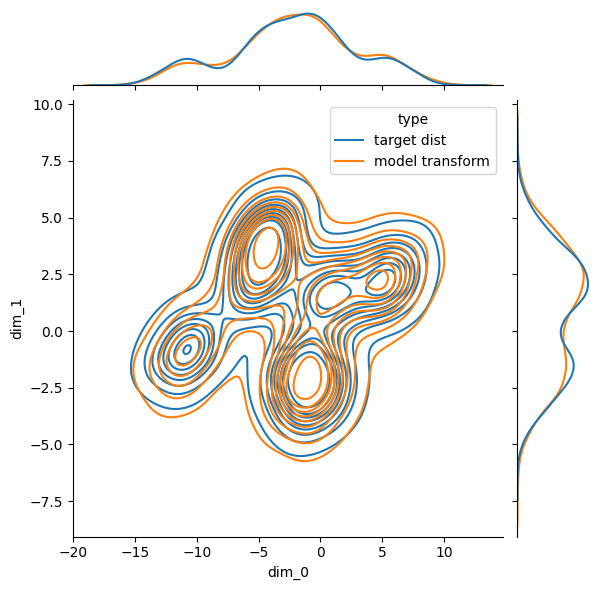

trail: 0 m step: 4 kl_test: 0.13276195526123047


  2%|▏         | 100/6000 [00:31<34:13,  2.87it/s]

trail: 0 m step: 5 Loss: 0.1137383616936087  L_n: 0.09663200378417969  kld: 0.006351470947265625 KLD1: 0.0914105474948883 KLD2: 0.06727564334869385


  3%|▎         | 200/6000 [01:02<33:11,  2.91it/s]

trail: 0 m step: 5 Loss: 0.11246224490574971  L_n: 0.09703826904296875  kld: 0.005726814270019531 KLD1: 0.09046507626771927 KLD2: 0.07039038091897964


  5%|▌         | 300/6000 [01:33<32:46,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10499125478126997  L_n: 0.08428382873535156  kld: 0.0076885223388671875 KLD1: 0.0874328464269638 KLD2: 0.07021450996398926


  7%|▋         | 400/6000 [02:04<32:03,  2.91it/s]

trail: 0 m step: 5 Loss: 0.11490245375949797  L_n: 0.0904989242553711  kld: 0.009060859680175781 KLD1: 0.0869990810751915 KLD2: 0.07182826846837997


  8%|▊         | 500/6000 [02:35<31:32,  2.91it/s]

trail: 0 m step: 5 Loss: 0.11417156141635651  L_n: 0.09080314636230469  kld: 0.008676528930664062 KLD1: 0.08930223435163498 KLD2: 0.07168860733509064


 10%|█         | 600/6000 [03:06<31:00,  2.90it/s]

trail: 0 m step: 5 Loss: 0.11297784756757918  L_n: 0.0932464599609375  kld: 0.0073261260986328125 KLD1: 0.09375160932540894 KLD2: 0.06559784710407257


 12%|█▏        | 700/6000 [03:38<30:20,  2.91it/s]

trail: 0 m step: 5 Loss: 0.1159446187105689  L_n: 0.08606243133544922  kld: 0.011095046997070312 KLD1: 0.07755151391029358 KLD2: 0.07146690785884857


 13%|█▎        | 800/6000 [04:09<29:53,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10866282776076415  L_n: 0.09217548370361328  kld: 0.006121635437011719 KLD1: 0.10139405727386475 KLD2: 0.07061880826950073


 15%|█▌        | 900/6000 [04:40<29:16,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10619341151408986  L_n: 0.09067440032958984  kld: 0.0057621002197265625 KLD1: 0.08641459792852402 KLD2: 0.07426318526268005


 17%|█▋        | 1000/6000 [05:11<28:40,  2.91it/s]

trail: 0 m step: 5 Loss: 0.10133074195344147  L_n: 0.086700439453125  kld: 0.00543212890625 KLD1: 0.0940043181180954 KLD2: 0.07404588162899017


 18%|█▊        | 1100/6000 [05:42<28:08,  2.90it/s]

trail: 0 m step: 5 Loss: 0.09937933540010843  L_n: 0.08325672149658203  kld: 0.005986213684082031 KLD1: 0.09135014563798904 KLD2: 0.06560313701629639


 20%|██        | 1200/6000 [06:13<27:33,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10807556855111974  L_n: 0.08278846740722656  kld: 0.009388923645019531 KLD1: 0.08364998549222946 KLD2: 0.07216156274080276


 22%|██▏       | 1300/6000 [06:44<26:52,  2.91it/s]

trail: 0 m step: 5 Loss: 0.10719869699400143  L_n: 0.08674812316894531  kld: 0.0075931549072265625 KLD1: 0.08836571127176285 KLD2: 0.06878381222486496


 23%|██▎       | 1400/6000 [07:16<26:27,  2.90it/s]

trail: 0 m step: 5 Loss: 0.12111360966474277  L_n: 0.09524345397949219  kld: 0.00960540771484375 KLD1: 0.08606915175914764 KLD2: 0.06419023871421814


 25%|██▌       | 1500/6000 [07:47<25:49,  2.90it/s]

trail: 0 m step: 5 Loss: 0.12064789972232018  L_n: 0.09484195709228516  kld: 0.009581565856933594 KLD1: 0.0848252922296524 KLD2: 0.07623216509819031


 27%|██▋       | 1600/6000 [08:18<25:15,  2.90it/s]

trail: 0 m step: 5 Loss: 0.11261802899862954  L_n: 0.09024620056152344  kld: 0.008306503295898438 KLD1: 0.08326995372772217 KLD2: 0.07013169676065445


 28%|██▊       | 1700/6000 [08:49<24:40,  2.91it/s]

trail: 0 m step: 5 Loss: 0.11010558773438717  L_n: 0.08417892456054688  kld: 0.009626388549804688 KLD1: 0.0784907341003418 KLD2: 0.06131838262081146


 30%|███       | 1800/6000 [09:20<24:05,  2.91it/s]

trail: 0 m step: 5 Loss: 0.10255583260753005  L_n: 0.08233642578125  kld: 0.00750732421875 KLD1: 0.08961624652147293 KLD2: 0.06751742959022522


 32%|███▏      | 1900/6000 [09:51<23:35,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10820702933201254  L_n: 0.09055614471435547  kld: 0.00655364990234375 KLD1: 0.0884266272187233 KLD2: 0.06313110142946243


 33%|███▎      | 2000/6000 [10:22<22:56,  2.91it/s]

trail: 0 m step: 5 Loss: 0.11584382778777727  L_n: 0.09840869903564453  kld: 0.006473541259765625 KLD1: 0.08938031643629074 KLD2: 0.06845927238464355


 35%|███▌      | 2100/6000 [10:53<22:24,  2.90it/s]

trail: 0 m step: 5 Loss: 0.1011463476618917  L_n: 0.0838165283203125  kld: 0.006434440612792969 KLD1: 0.08196675032377243 KLD2: 0.06283456832170486


 37%|███▋      | 2200/6000 [11:25<21:47,  2.91it/s]

trail: 0 m step: 5 Loss: 0.10834464180321919  L_n: 0.0877065658569336  kld: 0.007662773132324219 KLD1: 0.0800594612956047 KLD2: 0.0698527842760086


 38%|███▊      | 2300/6000 [11:56<21:09,  2.92it/s]

trail: 0 m step: 5 Loss: 0.09945354223876135  L_n: 0.08080863952636719  kld: 0.006922721862792969 KLD1: 0.0880022644996643 KLD2: 0.06781763583421707


 40%|████      | 2400/6000 [12:27<20:39,  2.90it/s]

trail: 0 m step: 5 Loss: 0.11140758776455206  L_n: 0.09227466583251953  kld: 0.007103919982910156 KLD1: 0.08674595504999161 KLD2: 0.06419528275728226


 42%|████▏     | 2500/6000 [12:58<20:00,  2.92it/s]

trail: 0 m step: 5 Loss: 0.09887721522214321  L_n: 0.07846260070800781  kld: 0.007579803466796875 KLD1: 0.07591275870800018 KLD2: 0.06522327661514282


 43%|████▎     | 2600/6000 [13:29<19:29,  2.91it/s]

trail: 0 m step: 5 Loss: 0.0990395317990284  L_n: 0.08191776275634766  kld: 0.0063571929931640625 KLD1: 0.08343546837568283 KLD2: 0.06782407313585281


 45%|████▌     | 2700/6000 [14:00<18:57,  2.90it/s]

trail: 0 m step: 5 Loss: 0.09858288328446106  L_n: 0.08202362060546875  kld: 0.006148338317871094 KLD1: 0.09132622182369232 KLD2: 0.06187693774700165


 47%|████▋     | 2800/6000 [14:31<18:23,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10952762452288874  L_n: 0.08772087097167969  kld: 0.008096694946289062 KLD1: 0.08365105092525482 KLD2: 0.06665688008069992


 48%|████▊     | 2900/6000 [15:03<17:45,  2.91it/s]

trail: 0 m step: 5 Loss: 0.10353166995720306  L_n: 0.08087730407714844  kld: 0.008411407470703125 KLD1: 0.08509945869445801 KLD2: 0.05862220376729965


 50%|█████     | 3000/6000 [15:34<17:12,  2.91it/s]

trail: 0 m step: 5 Loss: 0.10128414293482393  L_n: 0.08448600769042969  kld: 0.006237030029296875 KLD1: 0.08302964270114899 KLD2: 0.06802643835544586


 52%|█████▏    | 3100/6000 [16:05<16:40,  2.90it/s]

trail: 0 m step: 5 Loss: 0.09878586053624162  L_n: 0.07802963256835938  kld: 0.007706642150878906 KLD1: 0.08380832523107529 KLD2: 0.0684882253408432


 53%|█████▎    | 3200/6000 [16:36<16:04,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10986110585295801  L_n: 0.08567333221435547  kld: 0.008980751037597656 KLD1: 0.07754475623369217 KLD2: 0.0632137656211853


 55%|█████▌    | 3300/6000 [17:07<15:26,  2.91it/s]

trail: 0 m step: 5 Loss: 0.10934086279873408  L_n: 0.08629608154296875  kld: 0.008556365966796875 KLD1: 0.08263097703456879 KLD2: 0.06064727157354355


 57%|█████▋    | 3400/6000 [17:38<14:56,  2.90it/s]

trail: 0 m step: 5 Loss: 0.108148879571419  L_n: 0.09123516082763672  kld: 0.006279945373535156 KLD1: 0.09186223149299622 KLD2: 0.06526059657335281


 58%|█████▊    | 3500/6000 [18:09<14:19,  2.91it/s]

trail: 0 m step: 5 Loss: 0.09626903479431505  L_n: 0.07613182067871094  kld: 0.007476806640625 KLD1: 0.08408194035291672 KLD2: 0.06877464056015015


 60%|██████    | 3600/6000 [18:41<13:46,  2.90it/s]

trail: 0 m step: 5 Loss: 0.09815138373591324  L_n: 0.08359813690185547  kld: 0.0054035186767578125 KLD1: 0.09027336537837982 KLD2: 0.06611165404319763


 62%|██████▏   | 3700/6000 [19:12<13:13,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10873565132691866  L_n: 0.08587837219238281  kld: 0.008486747741699219 KLD1: 0.07247145473957062 KLD2: 0.06567652523517609


 63%|██████▎   | 3800/6000 [19:43<12:38,  2.90it/s]

trail: 0 m step: 5 Loss: 0.09590976769478916  L_n: 0.07825374603271484  kld: 0.0065555572509765625 KLD1: 0.08323285728693008 KLD2: 0.06464200466871262


 65%|██████▌   | 3900/6000 [20:14<12:05,  2.89it/s]

trail: 0 m step: 5 Loss: 0.09479353304617161  L_n: 0.0753164291381836  kld: 0.007231712341308594 KLD1: 0.08065733313560486 KLD2: 0.06577508896589279


 67%|██████▋   | 4000/6000 [20:45<11:30,  2.90it/s]

trail: 0 m step: 5 Loss: 0.0993286992476335  L_n: 0.08546638488769531  kld: 0.005146980285644531 KLD1: 0.09070973843336105 KLD2: 0.07152450829744339


 68%|██████▊   | 4100/6000 [21:16<10:55,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10232101849471986  L_n: 0.08086872100830078  kld: 0.007965087890625 KLD1: 0.07642611116170883 KLD2: 0.06383072584867477


 70%|███████   | 4200/6000 [21:47<10:20,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10547119062007672  L_n: 0.08451461791992188  kld: 0.007781028747558594 KLD1: 0.08073068410158157 KLD2: 0.05905478447675705


 72%|███████▏  | 4300/6000 [22:19<09:46,  2.90it/s]

trail: 0 m step: 5 Loss: 0.09177622023893345  L_n: 0.07379913330078125  kld: 0.006674766540527344 KLD1: 0.08894146233797073 KLD2: 0.0671568363904953


 73%|███████▎  | 4400/6000 [22:50<09:13,  2.89it/s]

trail: 0 m step: 5 Loss: 0.1079842473638848  L_n: 0.08769035339355469  kld: 0.007534980773925781 KLD1: 0.08429840207099915 KLD2: 0.064394012093544


 75%|███████▌  | 4500/6000 [23:21<08:36,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10267806744928865  L_n: 0.08321380615234375  kld: 0.0072269439697265625 KLD1: 0.08454655855894089 KLD2: 0.06070004031062126


 77%|███████▋  | 4600/6000 [23:52<08:03,  2.90it/s]

trail: 0 m step: 5 Loss: 0.1049105794148147  L_n: 0.08535385131835938  kld: 0.0072612762451171875 KLD1: 0.08807782083749771 KLD2: 0.06559379398822784


 78%|███████▊  | 4700/6000 [24:23<07:29,  2.89it/s]

trail: 0 m step: 5 Loss: 0.11090006850923943  L_n: 0.08779621124267578  kld: 0.008578300476074219 KLD1: 0.07521269470453262 KLD2: 0.06256214529275894


 80%|████████  | 4800/6000 [24:55<06:52,  2.91it/s]

trail: 0 m step: 5 Loss: 0.11174922866039019  L_n: 0.0859689712524414  kld: 0.009572029113769531 KLD1: 0.07686205953359604 KLD2: 0.07238353043794632


 82%|████████▏ | 4900/6000 [25:26<06:20,  2.89it/s]

trail: 0 m step: 5 Loss: 0.09697709684064779  L_n: 0.07705307006835938  kld: 0.007397651672363281 KLD1: 0.07390362024307251 KLD2: 0.06270628422498703


 83%|████████▎ | 5000/6000 [25:57<05:44,  2.90it/s]

trail: 0 m step: 5 Loss: 0.09692602194348326  L_n: 0.07724857330322266  kld: 0.007306098937988281 KLD1: 0.08535780012607574 KLD2: 0.0653245821595192


 85%|████████▌ | 5100/6000 [26:28<05:10,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10279672219746311  L_n: 0.08605766296386719  kld: 0.006215095520019531 KLD1: 0.08585021644830704 KLD2: 0.06392960250377655


 87%|████████▋ | 5200/6000 [26:59<04:35,  2.91it/s]

trail: 0 m step: 5 Loss: 0.10212242267178764  L_n: 0.08130455017089844  kld: 0.007729530334472656 KLD1: 0.08239984512329102 KLD2: 0.06536142528057098


 88%|████████▊ | 5300/6000 [27:31<04:02,  2.89it/s]

trail: 0 m step: 5 Loss: 0.10365855737642549  L_n: 0.0856943130493164  kld: 0.0066699981689453125 KLD1: 0.0853627547621727 KLD2: 0.05625545606017113


 90%|█████████ | 5400/6000 [28:02<03:26,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10424813224754116  L_n: 0.08552360534667969  kld: 0.0069522857666015625 KLD1: 0.08595152944326401 KLD2: 0.07062659412622452


 92%|█████████▏| 5500/6000 [28:33<02:52,  2.90it/s]

trail: 0 m step: 5 Loss: 0.11006069191055176  L_n: 0.08594226837158203  kld: 0.008955001831054688 KLD1: 0.08269764482975006 KLD2: 0.060897838324308395


 93%|█████████▎| 5600/6000 [29:04<02:17,  2.90it/s]

trail: 0 m step: 5 Loss: 0.0931132441961493  L_n: 0.07903003692626953  kld: 0.005228996276855469 KLD1: 0.0830720067024231 KLD2: 0.06714461743831635


 95%|█████████▌| 5700/6000 [29:35<01:43,  2.90it/s]

trail: 0 m step: 5 Loss: 0.0972759930011983  L_n: 0.07586479187011719  kld: 0.0079498291015625 KLD1: 0.08080130815505981 KLD2: 0.06290783733129501


 97%|█████████▋| 5800/6000 [30:07<01:08,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10697642080385587  L_n: 0.0853109359741211  kld: 0.008044242858886719 KLD1: 0.07634977996349335 KLD2: 0.06155092641711235


 98%|█████████▊| 5900/6000 [30:38<00:34,  2.90it/s]

trail: 0 m step: 5 Loss: 0.10431787540299053  L_n: 0.08304023742675781  kld: 0.007900238037109375 KLD1: 0.08440686762332916 KLD2: 0.06264440715312958


100%|██████████| 6000/6000 [31:09<00:00,  3.21it/s]

trail: 0 m step: 5 Loss: 0.10973364863790588  L_n: 0.08985328674316406  kld: 0.007381439208984375 KLD1: 0.07960277795791626 KLD2: 0.07156134396791458



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


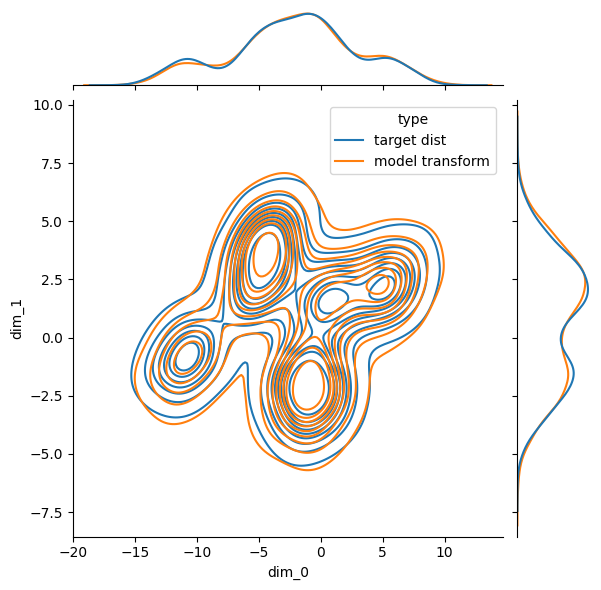

trail: 0 m step: 5 kl_test: 0.08197212219238281


  2%|▏         | 100/6000 [00:31<34:12,  2.87it/s]

trail: 0 m step: 6 Loss: 0.08194758404346847  L_n: 0.06977081298828125  kld: 0.005877494812011719 KLD1: 0.05887247622013092 KLD2: 0.046615179628133774


  3%|▎         | 200/6000 [01:02<33:04,  2.92it/s]

trail: 0 m step: 6 Loss: 0.07269675332497248  L_n: 0.062122344970703125  kld: 0.00510406494140625 KLD1: 0.06063804775476456 KLD2: 0.04768460988998413


  5%|▌         | 300/6000 [01:33<32:39,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06647966772955441  L_n: 0.05345726013183594  kld: 0.006285667419433594 KLD1: 0.05597878247499466 KLD2: 0.04887568578124046


  7%|▋         | 400/6000 [02:04<32:13,  2.90it/s]

trail: 0 m step: 6 Loss: 0.07781914808985484  L_n: 0.06382465362548828  kld: 0.006754875183105469 KLD1: 0.05936301127076149 KLD2: 0.049814172089099884


  8%|▊         | 500/6000 [02:35<31:37,  2.90it/s]

trail: 0 m step: 6 Loss: 0.07696713301856363  L_n: 0.06281852722167969  kld: 0.006829261779785156 KLD1: 0.05492214113473892 KLD2: 0.04829556867480278


 10%|█         | 600/6000 [03:06<30:57,  2.91it/s]

trail: 0 m step: 6 Loss: 0.07937544215006004  L_n: 0.06601715087890625  kld: 0.006447792053222656 KLD1: 0.05842176452279091 KLD2: 0.043227002024650574


 12%|█▏        | 700/6000 [03:38<30:26,  2.90it/s]

trail: 0 m step: 6 Loss: 0.07202640513700467  L_n: 0.057539939880371094  kld: 0.006992340087890625 KLD1: 0.05656011030077934 KLD2: 0.04927409440279007


 13%|█▎        | 800/6000 [04:09<29:50,  2.90it/s]

trail: 0 m step: 6 Loss: 0.06909269738149942  L_n: 0.0579986572265625  kld: 0.005354881286621094 KLD1: 0.05916455015540123 KLD2: 0.049112215638160706


 15%|█▌        | 900/6000 [04:40<29:15,  2.91it/s]

trail: 0 m step: 6 Loss: 0.07313837250644514  L_n: 0.061295509338378906  kld: 0.0057163238525390625 KLD1: 0.06117646396160126 KLD2: 0.05183013901114464


 17%|█▋        | 1000/6000 [05:11<28:40,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06433776723380322  L_n: 0.05522346496582031  kld: 0.004399299621582031 KLD1: 0.06886176019906998 KLD2: 0.05110334977507591


 18%|█▊        | 1100/6000 [05:42<28:05,  2.91it/s]

trail: 0 m step: 6 Loss: 0.07215034717233929  L_n: 0.057885169982910156  kld: 0.006885528564453125 KLD1: 0.056814853101968765 KLD2: 0.045087143778800964


 20%|██        | 1200/6000 [06:13<27:29,  2.91it/s]

trail: 0 m step: 6 Loss: 0.0705278769332211  L_n: 0.053709983825683594  kld: 0.00811767578125 KLD1: 0.06397274136543274 KLD2: 0.051173433661460876


 22%|██▏       | 1300/6000 [06:44<26:59,  2.90it/s]

trail: 0 m step: 6 Loss: 0.07190983655837434  L_n: 0.057099342346191406  kld: 0.00714874267578125 KLD1: 0.06115665286779404 KLD2: 0.043822456151247025


 23%|██▎       | 1400/6000 [07:15<26:23,  2.90it/s]

trail: 0 m step: 6 Loss: 0.07874863297730872  L_n: 0.06225872039794922  kld: 0.007959365844726562 KLD1: 0.05697959288954735 KLD2: 0.04320741072297096


 25%|██▌       | 1500/6000 [07:47<25:48,  2.91it/s]

trail: 0 m step: 6 Loss: 0.07886246568798844  L_n: 0.06318855285644531  kld: 0.007565498352050781 KLD1: 0.05845708027482033 KLD2: 0.052702609449625015


 27%|██▋       | 1600/6000 [08:18<25:13,  2.91it/s]

trail: 0 m step: 6 Loss: 0.07902449423533746  L_n: 0.060985565185546875  kld: 0.008707046508789062 KLD1: 0.05514216050505638 KLD2: 0.04908236488699913


 28%|██▊       | 1700/6000 [08:49<24:41,  2.90it/s]

trail: 0 m step: 6 Loss: 0.07802092510578357  L_n: 0.059329986572265625  kld: 0.009021759033203125 KLD1: 0.05579065904021263 KLD2: 0.04338879883289337


 30%|███       | 1800/6000 [09:20<24:05,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06965883680762729  L_n: 0.056041717529296875  kld: 0.006572723388671875 KLD1: 0.05901358649134636 KLD2: 0.04586896300315857


 32%|███▏      | 1900/6000 [09:51<23:32,  2.90it/s]

trail: 0 m step: 6 Loss: 0.07190734865121103  L_n: 0.06027984619140625  kld: 0.005612373352050781 KLD1: 0.05604768544435501 KLD2: 0.04271811619400978


 33%|███▎      | 2000/6000 [10:22<22:59,  2.90it/s]

trail: 0 m step: 6 Loss: 0.07311878807387298  L_n: 0.06360340118408203  kld: 0.0045928955078125 KLD1: 0.06021948158740997 KLD2: 0.04743492975831032


 35%|███▌      | 2100/6000 [10:54<22:19,  2.91it/s]

trail: 0 m step: 6 Loss: 0.07062963084497613  L_n: 0.06026268005371094  kld: 0.005003929138183594 KLD1: 0.051224082708358765 KLD2: 0.04139620438218117


 37%|███▋      | 2200/6000 [11:25<21:49,  2.90it/s]

trail: 0 m step: 6 Loss: 0.06777180127125473  L_n: 0.054917335510253906  kld: 0.0062046051025390625 KLD1: 0.05042620003223419 KLD2: 0.048189349472522736


 38%|███▊      | 2300/6000 [11:56<21:10,  2.91it/s]

trail: 0 m step: 6 Loss: 0.07038336092000465  L_n: 0.059279441833496094  kld: 0.005359649658203125 KLD1: 0.05722760036587715 KLD2: 0.04726916551589966


 40%|████      | 2400/6000 [12:27<20:36,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06981281782202126  L_n: 0.057697296142578125  kld: 0.005847930908203125 KLD1: 0.06281567364931107 KLD2: 0.044200118631124496


 42%|████▏     | 2500/6000 [12:58<20:04,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06818117622368032  L_n: 0.05589771270751953  kld: 0.005928993225097656 KLD1: 0.05088329315185547 KLD2: 0.04493531957268715


 43%|████▎     | 2600/6000 [13:29<19:33,  2.90it/s]

trail: 0 m step: 6 Loss: 0.06784028605373513  L_n: 0.0556793212890625  kld: 0.005869865417480469 KLD1: 0.054126523435115814 KLD2: 0.0442943349480629


 45%|████▌     | 2700/6000 [14:00<18:52,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06251839429832301  L_n: 0.05235099792480469  kld: 0.0049076080322265625 KLD1: 0.05851858854293823 KLD2: 0.04077892377972603


 47%|████▋     | 2800/6000 [14:31<18:15,  2.92it/s]

trail: 0 m step: 6 Loss: 0.07401778188304065  L_n: 0.05718803405761719  kld: 0.008123397827148438 KLD1: 0.057771556079387665 KLD2: 0.04653923958539963


 48%|████▊     | 2900/6000 [15:02<17:42,  2.92it/s]

trail: 0 m step: 6 Loss: 0.0742938393024693  L_n: 0.05935096740722656  kld: 0.007212638854980469 KLD1: 0.05184117332100868 KLD2: 0.039004165679216385


 50%|█████     | 3000/6000 [15:33<17:08,  2.92it/s]

trail: 0 m step: 6 Loss: 0.06827081434228287  L_n: 0.05645561218261719  kld: 0.005702972412109375 KLD1: 0.05808021128177643 KLD2: 0.046278513967990875


 52%|█████▏    | 3100/6000 [16:05<16:35,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06809098732500586  L_n: 0.05452919006347656  kld: 0.0065460205078125 KLD1: 0.056785911321640015 KLD2: 0.04694930464029312


 53%|█████▎    | 3200/6000 [16:36<16:01,  2.91it/s]

trail: 0 m step: 6 Loss: 0.07045039094346925  L_n: 0.05680561065673828  kld: 0.0065860748291015625 KLD1: 0.05722641572356224 KLD2: 0.04328945651650429


 55%|█████▌    | 3300/6000 [17:07<15:28,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06785512438084912  L_n: 0.05322837829589844  kld: 0.007060050964355469 KLD1: 0.0558234378695488 KLD2: 0.04063619300723076


 57%|█████▋    | 3400/6000 [17:38<14:52,  2.91it/s]

trail: 0 m step: 6 Loss: 0.0636691370098178  L_n: 0.053511619567871094  kld: 0.004902839660644531 KLD1: 0.0597667470574379 KLD2: 0.04182775318622589


 58%|█████▊    | 3500/6000 [18:09<14:21,  2.90it/s]

trail: 0 m step: 6 Loss: 0.06860580996516842  L_n: 0.056893348693847656  kld: 0.00565338134765625 KLD1: 0.05583089962601662 KLD2: 0.047328025102615356


 60%|██████    | 3600/6000 [18:40<13:45,  2.91it/s]

trail: 0 m step: 6 Loss: 0.060622967646473014  L_n: 0.05129528045654297  kld: 0.004502296447753906 KLD1: 0.05969536677002907 KLD2: 0.04296475276350975


 62%|██████▏   | 3700/6000 [19:11<13:10,  2.91it/s]

trail: 0 m step: 6 Loss: 0.07173071782334624  L_n: 0.055428504943847656  kld: 0.007868766784667969 KLD1: 0.050288546830415726 KLD2: 0.04247306287288666


 63%|██████▎   | 3800/6000 [19:42<12:36,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06763613084763773  L_n: 0.054210662841796875  kld: 0.006480216979980469 KLD1: 0.04992837831377983 KLD2: 0.04412280023097992


 65%|██████▌   | 3900/6000 [20:14<12:02,  2.91it/s]

trail: 0 m step: 6 Loss: 0.061289419830209524  L_n: 0.049185752868652344  kld: 0.0058422088623046875 KLD1: 0.0559784397482872 KLD2: 0.047002363950014114


 67%|██████▋   | 4000/6000 [20:45<11:27,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06214044371688116  L_n: 0.05338573455810547  kld: 0.004225730895996094 KLD1: 0.06396429240703583 KLD2: 0.04870900139212608


 68%|██████▊   | 4100/6000 [21:16<10:54,  2.90it/s]

trail: 0 m step: 6 Loss: 0.06967230285729613  L_n: 0.056189537048339844  kld: 0.00650787353515625 KLD1: 0.046970099210739136 KLD2: 0.041161492466926575


 70%|███████   | 4200/6000 [21:47<10:20,  2.90it/s]

trail: 0 m step: 6 Loss: 0.06062680414515757  L_n: 0.04989433288574219  kld: 0.00518035888671875 KLD1: 0.058890197426080704 KLD2: 0.03896701708436012


 72%|███████▏  | 4300/6000 [22:18<09:44,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06204355636716305  L_n: 0.05088233947753906  kld: 0.005387306213378906 KLD1: 0.05496200546622276 KLD2: 0.04653410613536835


 73%|███████▎  | 4400/6000 [22:49<09:11,  2.90it/s]

trail: 0 m step: 6 Loss: 0.07278935396128416  L_n: 0.05951404571533203  kld: 0.006407737731933594 KLD1: 0.05804935097694397 KLD2: 0.04259711503982544


 75%|███████▌  | 4500/6000 [23:21<08:35,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06660291320300456  L_n: 0.053050994873046875  kld: 0.006541252136230469 KLD1: 0.058198556303977966 KLD2: 0.04036535322666168


 77%|███████▋  | 4600/6000 [23:52<08:02,  2.90it/s]

trail: 0 m step: 6 Loss: 0.06750229652105716  L_n: 0.053948402404785156  kld: 0.006542205810546875 KLD1: 0.05442136153578758 KLD2: 0.043599244207143784


 78%|███████▊  | 4700/6000 [24:23<07:27,  2.91it/s]

trail: 0 m step: 6 Loss: 0.07031207770491694  L_n: 0.05474090576171875  kld: 0.007515907287597656 KLD1: 0.05152684077620506 KLD2: 0.041610024869441986


 80%|████████  | 4800/6000 [24:54<06:52,  2.91it/s]

trail: 0 m step: 6 Loss: 0.07387052978236372  L_n: 0.05859375  kld: 0.007373809814453125 KLD1: 0.04886970669031143 KLD2: 0.04929002746939659


 82%|████████▏ | 4900/6000 [25:25<06:17,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06602804891473629  L_n: 0.05376434326171875  kld: 0.005919456481933594 KLD1: 0.050909727811813354 KLD2: 0.042270611971616745


 83%|████████▎ | 5000/6000 [25:56<05:44,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06568993633107456  L_n: 0.05322074890136719  kld: 0.006018638610839844 KLD1: 0.05500173941254616 KLD2: 0.04351607710123062


 85%|████████▌ | 5100/6000 [26:27<05:09,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06516409497899336  L_n: 0.0545501708984375  kld: 0.005123138427734375 KLD1: 0.05876684561371803 KLD2: 0.04309876635670662


 87%|████████▋ | 5200/6000 [26:58<04:34,  2.92it/s]

trail: 0 m step: 6 Loss: 0.06940061583313473  L_n: 0.056079864501953125  kld: 0.0064296722412109375 KLD1: 0.056289657950401306 KLD2: 0.04397443309426308


 88%|████████▊ | 5300/6000 [27:29<03:59,  2.92it/s]

trail: 0 m step: 6 Loss: 0.07079554017806236  L_n: 0.0597686767578125  kld: 0.005322456359863281 KLD1: 0.05390295758843422 KLD2: 0.03790333494544029


 90%|█████████ | 5400/6000 [28:00<03:26,  2.91it/s]

trail: 0 m step: 6 Loss: 0.06654027209760632  L_n: 0.055347442626953125  kld: 0.005402565002441406 KLD1: 0.058330174535512924 KLD2: 0.04832516238093376


 92%|█████████▏| 5500/6000 [28:32<02:52,  2.91it/s]

trail: 0 m step: 6 Loss: 0.07093164444898742  L_n: 0.05481910705566406  kld: 0.007777214050292969 KLD1: 0.051642417907714844 KLD2: 0.03986118733882904


 93%|█████████▎| 5600/6000 [29:03<02:17,  2.91it/s]

trail: 0 m step: 6 Loss: 0.061110437015449354  L_n: 0.053017616271972656  kld: 0.00390625 KLD1: 0.05635347589850426 KLD2: 0.045391589403152466


 95%|█████████▌| 5700/6000 [29:34<01:42,  2.91it/s]

trail: 0 m step: 6 Loss: 0.0632882377607313  L_n: 0.050856590270996094  kld: 0.006000518798828125 KLD1: 0.055803097784519196 KLD2: 0.04302089661359787


 97%|█████████▋| 5800/6000 [30:05<01:08,  2.90it/s]

trail: 0 m step: 6 Loss: 0.0671363687054377  L_n: 0.054785728454589844  kld: 0.005961418151855469 KLD1: 0.05129963159561157 KLD2: 0.04266975447535515


 98%|█████████▊| 5900/6000 [30:36<00:34,  2.90it/s]

trail: 0 m step: 6 Loss: 0.06876644022562367  L_n: 0.055335044860839844  kld: 0.0064830780029296875 KLD1: 0.05629827827215195 KLD2: 0.043198954313993454


100%|██████████| 6000/6000 [31:07<00:00,  3.21it/s]

trail: 0 m step: 6 Loss: 0.07426109210421786  L_n: 0.060896873474121094  kld: 0.006450653076171875 KLD1: 0.05274766683578491 KLD2: 0.04879448562860489



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


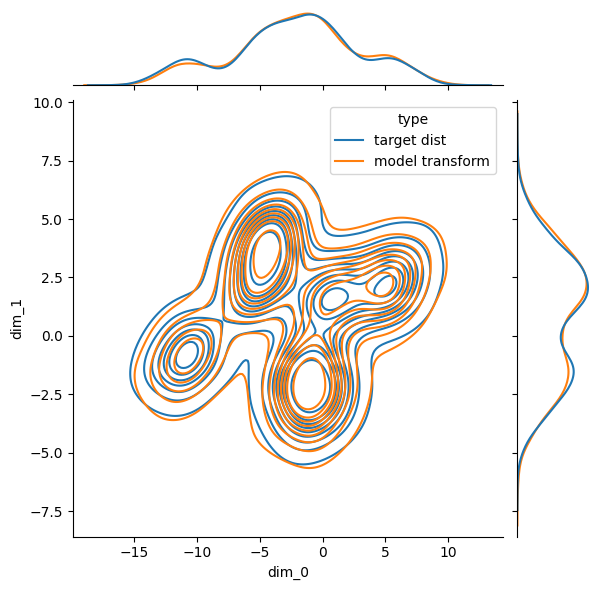

trail: 0 m step: 6 kl_test: 0.05637168884277344


  2%|▏         | 100/6000 [00:31<34:13,  2.87it/s]

trail: 0 m step: 7 Loss: 0.057102123400603  L_n: 0.049071311950683594  kld: 0.005039215087890625 KLD1: 0.04729652404785156 KLD2: 0.034066807478666306


  3%|▎         | 200/6000 [01:02<33:07,  2.92it/s]

trail: 0 m step: 7 Loss: 0.04816053076592036  L_n: 0.042830467224121094  kld: 0.0033445358276367188 KLD1: 0.04538923129439354 KLD2: 0.03558769449591637


  5%|▌         | 300/6000 [01:33<32:42,  2.90it/s]

trail: 0 m step: 7 Loss: 0.044467413492286216  L_n: 0.03560829162597656  kld: 0.005558967590332031 KLD1: 0.038884665817022324 KLD2: 0.03399103879928589


  7%|▋         | 400/6000 [02:04<32:11,  2.90it/s]

trail: 0 m step: 7 Loss: 0.05653334389100362  L_n: 0.04682159423828125  kld: 0.0060939788818359375 KLD1: 0.042003922164440155 KLD2: 0.034666333347558975


  8%|▊         | 500/6000 [02:35<31:29,  2.91it/s]

trail: 0 m step: 7 Loss: 0.058039244403650825  L_n: 0.048675537109375  kld: 0.005875587463378906 KLD1: 0.037650275975465775 KLD2: 0.03474156931042671


 10%|█         | 600/6000 [03:06<31:01,  2.90it/s]

trail: 0 m step: 7 Loss: 0.052082897306682314  L_n: 0.043898582458496094  kld: 0.005135536193847656 KLD1: 0.04465494677424431 KLD2: 0.030914006754755974


 12%|█▏        | 700/6000 [03:38<30:26,  2.90it/s]

trail: 0 m step: 7 Loss: 0.05196612814127069  L_n: 0.04262065887451172  kld: 0.005864143371582031 KLD1: 0.041756726801395416 KLD2: 0.035717230290174484


 13%|█▎        | 800/6000 [04:09<29:48,  2.91it/s]

trail: 0 m step: 7 Loss: 0.051686123193419996  L_n: 0.04430580139160156  kld: 0.00463104248046875 KLD1: 0.042914725840091705 KLD2: 0.03804319351911545


 15%|█▌        | 900/6000 [04:40<29:16,  2.90it/s]

trail: 0 m step: 7 Loss: 0.047644839472809355  L_n: 0.04136943817138672  kld: 0.003937721252441406 KLD1: 0.044975318014621735 KLD2: 0.03937339410185814


 17%|█▋        | 1000/6000 [05:11<28:42,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04576620177297694  L_n: 0.04133892059326172  kld: 0.0027780532836914062 KLD1: 0.04298262670636177 KLD2: 0.03700311854481697


 18%|█▊        | 1100/6000 [05:42<28:08,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04573678578176007  L_n: 0.040195465087890625  kld: 0.0034770965576171875 KLD1: 0.03953312709927559 KLD2: 0.03353804349899292


 20%|██        | 1200/6000 [06:13<27:38,  2.89it/s]

trail: 0 m step: 7 Loss: 0.05573925868094295  L_n: 0.04543781280517578  kld: 0.0064640045166015625 KLD1: 0.046990811824798584 KLD2: 0.03883139044046402


 22%|██▏       | 1300/6000 [06:44<26:59,  2.90it/s]

trail: 0 m step: 7 Loss: 0.05242626672361545  L_n: 0.04291057586669922  kld: 0.005970954895019531 KLD1: 0.046295978128910065 KLD2: 0.03520694002509117


 23%|██▎       | 1400/6000 [07:16<26:24,  2.90it/s]

trail: 0 m step: 7 Loss: 0.0567747952564722  L_n: 0.04638671875  kld: 0.006518363952636719 KLD1: 0.0400688573718071 KLD2: 0.03071320429444313


 25%|██▌       | 1500/6000 [07:47<25:56,  2.89it/s]

trail: 0 m step: 7 Loss: 0.05866338529809517  L_n: 0.04749107360839844  kld: 0.007010459899902344 KLD1: 0.04377175122499466 KLD2: 0.03691771253943443


 27%|██▋       | 1600/6000 [08:18<25:11,  2.91it/s]

trail: 0 m step: 7 Loss: 0.057324518245683756  L_n: 0.048381805419921875  kld: 0.005611419677734375 KLD1: 0.0361495278775692 KLD2: 0.03644975647330284


 28%|██▊       | 1700/6000 [08:49<24:40,  2.90it/s]

trail: 0 m step: 7 Loss: 0.050507276280747346  L_n: 0.03955078125  kld: 0.006875038146972656 KLD1: 0.03959763050079346 KLD2: 0.030649401247501373


 30%|███       | 1800/6000 [09:20<24:04,  2.91it/s]

trail: 0 m step: 7 Loss: 0.05402491483007096  L_n: 0.04654884338378906  kld: 0.004691123962402344 KLD1: 0.04401664808392525 KLD2: 0.03466009721159935


 32%|███▏      | 1900/6000 [09:51<23:28,  2.91it/s]

trail: 0 m step: 7 Loss: 0.0506766549543663  L_n: 0.04322338104248047  kld: 0.00467681884765625 KLD1: 0.04342299699783325 KLD2: 0.030376702547073364


 33%|███▎      | 2000/6000 [10:23<22:56,  2.91it/s]

trail: 0 m step: 7 Loss: 0.05785887857294049  L_n: 0.04736137390136719  kld: 0.006587028503417969 KLD1: 0.041342612355947495 KLD2: 0.034791070967912674


 35%|███▌      | 2100/6000 [10:54<22:21,  2.91it/s]

trail: 0 m step: 7 Loss: 0.050202061759981514  L_n: 0.04345703125  kld: 0.0042324066162109375 KLD1: 0.03337513282895088 KLD2: 0.028788426890969276


 37%|███▋      | 2200/6000 [11:25<21:50,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04050362707277367  L_n: 0.03295612335205078  kld: 0.0047359466552734375 KLD1: 0.04034910351037979 KLD2: 0.03502681851387024


 38%|███▊      | 2300/6000 [11:56<21:08,  2.92it/s]

trail: 0 m step: 7 Loss: 0.04446574839415987  L_n: 0.03677082061767578  kld: 0.004828453063964844 KLD1: 0.0366680808365345 KLD2: 0.03423532098531723


 40%|████      | 2400/6000 [12:27<20:37,  2.91it/s]

trail: 0 m step: 7 Loss: 0.0464112678504547  L_n: 0.039154052734375  kld: 0.004553794860839844 KLD1: 0.043193407356739044 KLD2: 0.031709957867860794


 42%|████▏     | 2500/6000 [12:58<20:06,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04327670577027201  L_n: 0.035773277282714844  kld: 0.004708290100097656 KLD1: 0.03689597547054291 KLD2: 0.03122030571103096


 43%|████▎     | 2600/6000 [13:29<19:30,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04325021068872588  L_n: 0.036278724670410156  kld: 0.004374504089355469 KLD1: 0.04142244905233383 KLD2: 0.03150525316596031


 45%|████▌     | 2700/6000 [14:01<18:54,  2.91it/s]

trail: 0 m step: 7 Loss: 0.045613114026865215  L_n: 0.036934852600097656  kld: 0.0054454803466796875 KLD1: 0.03664155304431915 KLD2: 0.029154106974601746


 47%|████▋     | 2800/6000 [14:32<19:54,  2.68it/s]

trail: 0 m step: 7 Loss: 0.045108562011467  L_n: 0.03536033630371094  kld: 0.0061168670654296875 KLD1: 0.04454515129327774 KLD2: 0.034261833876371384


 48%|████▊     | 2900/6000 [15:03<17:46,  2.91it/s]

trail: 0 m step: 7 Loss: 0.04801414100614736  L_n: 0.03829479217529297  kld: 0.006098747253417969 KLD1: 0.03737085312604904 KLD2: 0.02789345383644104


 50%|█████     | 3000/6000 [15:34<17:14,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04751902549620934  L_n: 0.04145336151123047  kld: 0.0038061141967773438 KLD1: 0.03868427500128746 KLD2: 0.031539395451545715


 52%|█████▏    | 3100/6000 [16:05<16:40,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04531905790729593  L_n: 0.03670310974121094  kld: 0.005406379699707031 KLD1: 0.03846848011016846 KLD2: 0.034602221101522446


 53%|█████▎    | 3200/6000 [16:36<16:03,  2.91it/s]

trail: 0 m step: 7 Loss: 0.05185574575577625  L_n: 0.04425048828125  kld: 0.004772186279296875 KLD1: 0.03872419893741608 KLD2: 0.03138712793588638


 55%|█████▌    | 3300/6000 [17:08<15:28,  2.91it/s]

trail: 0 m step: 7 Loss: 0.040459051411279985  L_n: 0.033069610595703125  kld: 0.0046367645263671875 KLD1: 0.04531199857592583 KLD2: 0.02850555069744587


 57%|█████▋    | 3400/6000 [17:39<14:55,  2.90it/s]

trail: 0 m step: 7 Loss: 0.042857796752617534  L_n: 0.037403106689453125  kld: 0.0034227371215820312 KLD1: 0.04600413143634796 KLD2: 0.028850212693214417


 58%|█████▊    | 3500/6000 [18:10<14:19,  2.91it/s]

trail: 0 m step: 7 Loss: 0.04595777794132998  L_n: 0.040015220642089844  kld: 0.0037288665771484375 KLD1: 0.03995068371295929 KLD2: 0.03554743155837059


 60%|██████    | 3600/6000 [18:41<13:46,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04017590024242808  L_n: 0.034440040588378906  kld: 0.0035991668701171875 KLD1: 0.039621200412511826 KLD2: 0.030195744708180428


 62%|██████▏   | 3700/6000 [19:12<13:10,  2.91it/s]

trail: 0 m step: 7 Loss: 0.04801699724822564  L_n: 0.03930377960205078  kld: 0.005467414855957031 KLD1: 0.037576232105493546 KLD2: 0.030766716226935387


 63%|██████▎   | 3800/6000 [19:43<12:36,  2.91it/s]

trail: 0 m step: 7 Loss: 0.04621537923336416  L_n: 0.037901878356933594  kld: 0.0052165985107421875 KLD1: 0.03616867586970329 KLD2: 0.03167494386434555


 65%|██████▌   | 3900/6000 [20:14<12:02,  2.91it/s]

trail: 0 m step: 7 Loss: 0.04266963932570002  L_n: 0.034745216369628906  kld: 0.0049724578857421875 KLD1: 0.03199142590165138 KLD2: 0.03293292596936226


 67%|██████▋   | 4000/6000 [20:45<11:27,  2.91it/s]

trail: 0 m step: 7 Loss: 0.03897732986427679  L_n: 0.035785675048828125  kld: 0.002002716064453125 KLD1: 0.04403296485543251 KLD2: 0.035633739084005356


 68%|██████▊   | 4100/6000 [21:16<10:52,  2.91it/s]

trail: 0 m step: 7 Loss: 0.04388961829574379  L_n: 0.03798961639404297  kld: 0.0037021636962890625 KLD1: 0.03482786938548088 KLD2: 0.028573641553521156


 70%|███████   | 4200/6000 [21:47<10:17,  2.91it/s]

trail: 0 m step: 7 Loss: 0.04496689284133095  L_n: 0.03815650939941406  kld: 0.004273414611816406 KLD1: 0.03702424094080925 KLD2: 0.027171531692147255


 72%|███████▏  | 4300/6000 [22:19<09:44,  2.91it/s]

trail: 0 m step: 7 Loss: 0.04078450561934592  L_n: 0.03417778015136719  kld: 0.004145622253417969 KLD1: 0.037187010049819946 KLD2: 0.03452061861753464


 73%|███████▎  | 4400/6000 [22:50<09:10,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04703943228010319  L_n: 0.04071235656738281  kld: 0.003970146179199219 KLD1: 0.03981702774763107 KLD2: 0.03034832701086998


 75%|███████▌  | 4500/6000 [23:21<08:35,  2.91it/s]

trail: 0 m step: 7 Loss: 0.04613145693214568  L_n: 0.040024757385253906  kld: 0.0038318634033203125 KLD1: 0.03768360987305641 KLD2: 0.02869727648794651


 77%|███████▋  | 4600/6000 [23:52<08:01,  2.90it/s]

trail: 0 m step: 7 Loss: 0.048510677152633186  L_n: 0.04206657409667969  kld: 0.0040435791015625 KLD1: 0.0408172607421875 KLD2: 0.03230873867869377


 78%|███████▊  | 4700/6000 [24:23<07:27,  2.90it/s]

trail: 0 m step: 7 Loss: 0.046339580075048306  L_n: 0.037746429443359375  kld: 0.0053920745849609375 KLD1: 0.03081335686147213 KLD2: 0.03140593320131302


 80%|████████  | 4800/6000 [24:54<06:54,  2.90it/s]

trail: 0 m step: 7 Loss: 0.05157476330954737  L_n: 0.04276275634765625  kld: 0.0055294036865234375 KLD1: 0.033363256603479385 KLD2: 0.03545929118990898


 82%|████████▏ | 4900/6000 [25:26<06:18,  2.91it/s]

trail: 0 m step: 7 Loss: 0.0380530784775018  L_n: 0.031180381774902344  kld: 0.0043125152587890625 KLD1: 0.03781755268573761 KLD2: 0.030385253950953484


 83%|████████▎ | 5000/6000 [25:57<05:44,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04521452108338862  L_n: 0.038417816162109375  kld: 0.00426483154296875 KLD1: 0.035589925944805145 KLD2: 0.03170960396528244


 85%|████████▌ | 5100/6000 [26:28<05:09,  2.91it/s]

trail: 0 m step: 7 Loss: 0.04318568417317254  L_n: 0.0394134521484375  kld: 0.0023670196533203125 KLD1: 0.0413450188934803 KLD2: 0.031526897102594376


 87%|████████▋ | 5200/6000 [26:59<04:35,  2.90it/s]

trail: 0 m step: 7 Loss: 0.05039645600373824  L_n: 0.04298877716064453  kld: 0.0046482086181640625 KLD1: 0.03864188864827156 KLD2: 0.03131474182009697


 88%|████████▊ | 5300/6000 [27:30<04:01,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04659216219511308  L_n: 0.04141712188720703  kld: 0.0032472610473632812 KLD1: 0.03942691162228584 KLD2: 0.027457818388938904


 90%|█████████ | 5400/6000 [28:01<03:26,  2.90it/s]

trail: 0 m step: 7 Loss: 0.043842150875589014  L_n: 0.03698921203613281  kld: 0.004300117492675781 KLD1: 0.03664600849151611 KLD2: 0.0349445603787899


 92%|█████████▏| 5500/6000 [28:33<02:52,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04252092126495553  L_n: 0.034514427185058594  kld: 0.005023956298828125 KLD1: 0.03610430657863617 KLD2: 0.027773577719926834


 93%|█████████▎| 5600/6000 [29:04<02:17,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04241937744927415  L_n: 0.037560462951660156  kld: 0.0030488967895507812 KLD1: 0.03525606170296669 KLD2: 0.032156091183423996


 95%|█████████▌| 5700/6000 [29:35<01:43,  2.90it/s]

trail: 0 m step: 7 Loss: 0.04171407143043253  L_n: 0.03513622283935547  kld: 0.00412750244140625 KLD1: 0.04089468717575073 KLD2: 0.03067442774772644


 97%|█████████▋| 5800/6000 [30:06<01:08,  2.92it/s]

trail: 0 m step: 7 Loss: 0.04784083996659618  L_n: 0.040299415588378906  kld: 0.0047321319580078125 KLD1: 0.03674580529332161 KLD2: 0.030023958534002304


 98%|█████████▊| 5900/6000 [30:37<00:34,  2.90it/s]

trail: 0 m step: 7 Loss: 0.043298202934111636  L_n: 0.03597259521484375  kld: 0.004596710205078125 KLD1: 0.03922338783740997 KLD2: 0.03093956597149372


100%|██████████| 6000/6000 [31:08<00:00,  3.21it/s]

trail: 0 m step: 7 Loss: 0.04541393761499058  L_n: 0.03878593444824219  kld: 0.004158973693847656 KLD1: 0.03662562742829323 KLD2: 0.03523911535739899



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


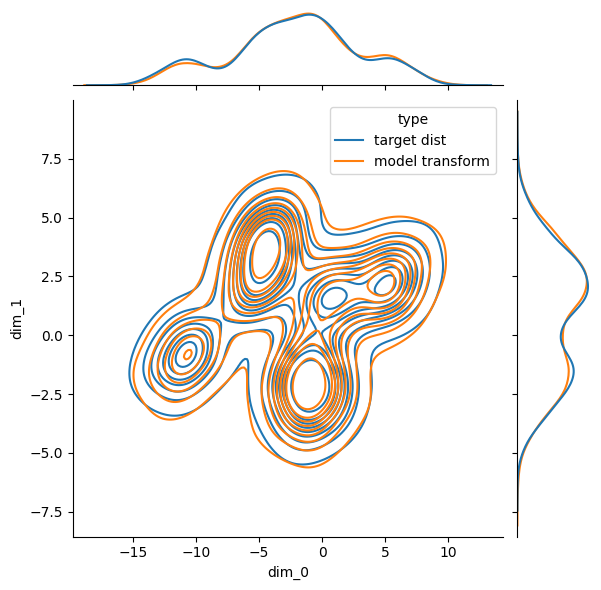

trail: 0 m step: 7 kl_test: 0.043335914611816406


  2%|▏         | 100/6000 [00:31<34:22,  2.86it/s]

trail: 0 m step: 8 Loss: 0.03935756945450594  L_n: 0.03487873077392578  kld: 0.0036535263061523438 KLD1: 0.03252715617418289 KLD2: 0.026323650032281876


  3%|▎         | 200/6000 [01:02<33:20,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03991010445994222  L_n: 0.036019325256347656  kld: 0.003173828125 KLD1: 0.03344770893454552 KLD2: 0.030480651184916496


  5%|▌         | 300/6000 [01:33<32:51,  2.89it/s]

trail: 0 m step: 8 Loss: 0.03780420044313157  L_n: 0.029732704162597656  kld: 0.00658416748046875 KLD1: 0.029534051194787025 KLD2: 0.02793511003255844


  7%|▋         | 400/6000 [02:05<32:18,  2.89it/s]

trail: 0 m step: 8 Loss: 0.04068311331189625  L_n: 0.035376548767089844  kld: 0.004328727722167969 KLD1: 0.0329190194606781 KLD2: 0.03014945611357689


  8%|▊         | 500/6000 [02:36<31:30,  2.91it/s]

trail: 0 m step: 8 Loss: 0.035893611517451504  L_n: 0.03137969970703125  kld: 0.0036821365356445312 KLD1: 0.025921709835529327 KLD2: 0.02581094577908516


 10%|█         | 600/6000 [03:07<31:04,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03846763853075917  L_n: 0.033120155334472656  kld: 0.0043621063232421875 KLD1: 0.02785602957010269 KLD2: 0.02223670296370983


 12%|█▏        | 700/6000 [03:38<30:26,  2.90it/s]

trail: 0 m step: 8 Loss: 0.0379395964940859  L_n: 0.03107929229736328  kld: 0.005596160888671875 KLD1: 0.026378294453024864 KLD2: 0.02718568593263626


 13%|█▎        | 800/6000 [04:09<29:57,  2.89it/s]

trail: 0 m step: 8 Loss: 0.0356634941251557  L_n: 0.029510498046875  kld: 0.005019187927246094 KLD1: 0.03270014747977257 KLD2: 0.03040553443133831


 15%|█▌        | 900/6000 [04:41<29:18,  2.90it/s]

trail: 0 m step: 8 Loss: 0.04407596228610633  L_n: 0.036437034606933594  kld: 0.0062313079833984375 KLD1: 0.037001267075538635 KLD2: 0.03748065233230591


 17%|█▋        | 1000/6000 [05:12<28:46,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03818806177965707  L_n: 0.031935691833496094  kld: 0.005100250244140625 KLD1: 0.035536907613277435 KLD2: 0.031901899725198746


 18%|█▊        | 1100/6000 [05:43<28:13,  2.89it/s]

trail: 0 m step: 8 Loss: 0.03922894107803647  L_n: 0.03354358673095703  kld: 0.004637718200683594 KLD1: 0.02492174319922924 KLD2: 0.02901448868215084


 20%|██        | 1200/6000 [06:14<27:34,  2.90it/s]

trail: 0 m step: 8 Loss: 0.036080066691827714  L_n: 0.031615257263183594  kld: 0.0036420822143554688 KLD1: 0.03161260113120079 KLD2: 0.02978934533894062


 22%|██▏       | 1300/6000 [06:45<26:59,  2.90it/s]

trail: 0 m step: 8 Loss: 0.035255201850550685  L_n: 0.03161811828613281  kld: 0.0029668807983398438 KLD1: 0.030865319073200226 KLD2: 0.026814276352524757


 23%|██▎       | 1400/6000 [07:16<26:30,  2.89it/s]

trail: 0 m step: 8 Loss: 0.04632042294424965  L_n: 0.03863239288330078  kld: 0.0062713623046875 KLD1: 0.036038994789123535 KLD2: 0.02581005170941353


 25%|██▌       | 1500/6000 [07:48<25:55,  2.89it/s]

trail: 0 m step: 8 Loss: 0.04473934677269131  L_n: 0.037578582763671875  kld: 0.005841255187988281 KLD1: 0.03375036641955376 KLD2: 0.03161054849624634


 27%|██▋       | 1600/6000 [08:19<25:21,  2.89it/s]

trail: 0 m step: 8 Loss: 0.04009299571067588  L_n: 0.033196449279785156  kld: 0.005625724792480469 KLD1: 0.02906857803463936 KLD2: 0.029066240414977074


 28%|██▊       | 1700/6000 [08:50<24:46,  2.89it/s]

trail: 0 m step: 8 Loss: 0.04049744035481283  L_n: 0.03367805480957031  kld: 0.005562782287597656 KLD1: 0.03244021534919739 KLD2: 0.026367729529738426


 30%|███       | 1800/6000 [09:21<24:10,  2.89it/s]

trail: 0 m step: 8 Loss: 0.039892627329142484  L_n: 0.03391265869140625  kld: 0.004878044128417969 KLD1: 0.029831044375896454 KLD2: 0.026840126141905785


 32%|███▏      | 1900/6000 [09:53<23:38,  2.89it/s]

trail: 0 m step: 8 Loss: 0.03578806647263698  L_n: 0.03162956237792969  kld: 0.0033922195434570312 KLD1: 0.028951799497008324 KLD2: 0.027248961851000786


 33%|███▎      | 2000/6000 [10:24<23:07,  2.88it/s]

trail: 0 m step: 8 Loss: 0.036808377125594746  L_n: 0.032619476318359375  kld: 0.0034170150756835938 KLD1: 0.030463268980383873 KLD2: 0.029163530096411705


 35%|███▌      | 2100/6000 [10:55<22:29,  2.89it/s]

trail: 0 m step: 8 Loss: 0.03565065645658999  L_n: 0.03261566162109375  kld: 0.002475738525390625 KLD1: 0.026425255462527275 KLD2: 0.022661125287413597


 37%|███▋      | 2200/6000 [11:27<21:53,  2.89it/s]

trail: 0 m step: 8 Loss: 0.03346165005634555  L_n: 0.02894306182861328  kld: 0.0036859512329101562 KLD1: 0.02604500576853752 KLD2: 0.02820708230137825


 38%|███▊      | 2300/6000 [11:58<21:16,  2.90it/s]

trail: 0 m step: 8 Loss: 0.0362352833161086  L_n: 0.029442787170410156  kld: 0.0055408477783203125 KLD1: 0.03142569959163666 KLD2: 0.027962004765868187


 40%|████      | 2400/6000 [12:29<20:42,  2.90it/s]

trail: 0 m step: 8 Loss: 0.035477349943883914  L_n: 0.03136444091796875  kld: 0.0033550262451171875 KLD1: 0.038886602967977524 KLD2: 0.02520117163658142


 42%|████▏     | 2500/6000 [13:00<20:08,  2.90it/s]

trail: 0 m step: 8 Loss: 0.033649302647169775  L_n: 0.02793121337890625  kld: 0.004664421081542969 KLD1: 0.028394082561135292 KLD2: 0.025789648294448853


 43%|████▎     | 2600/6000 [13:32<19:31,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03946406576322784  L_n: 0.03509044647216797  kld: 0.0035676956176757812 KLD1: 0.027630982920527458 KLD2: 0.023251879960298538


 45%|████▌     | 2700/6000 [14:03<18:59,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03319529102908854  L_n: 0.028347015380859375  kld: 0.003954887390136719 KLD1: 0.03277245908975601 KLD2: 0.022404596209526062


 47%|████▋     | 2800/6000 [14:34<18:26,  2.89it/s]

trail: 0 m step: 8 Loss: 0.04098195167947769  L_n: 0.03439521789550781  kld: 0.0053730010986328125 KLD1: 0.030291033908724785 KLD2: 0.02801760844886303


 48%|████▊     | 2900/6000 [15:05<17:50,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03994874674729567  L_n: 0.03345203399658203  kld: 0.005299568176269531 KLD1: 0.030047399923205376 KLD2: 0.022942984476685524


 50%|█████     | 3000/6000 [15:37<17:16,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03638486963544395  L_n: 0.032398223876953125  kld: 0.0032520294189453125 KLD1: 0.03059864416718483 KLD2: 0.0248634722083807


 52%|█████▏    | 3100/6000 [16:08<16:42,  2.89it/s]

trail: 0 m step: 8 Loss: 0.03831069505729834  L_n: 0.033638954162597656  kld: 0.003810882568359375 KLD1: 0.03454688936471939 KLD2: 0.02679690532386303


 53%|█████▎    | 3200/6000 [16:39<16:06,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03258101474377589  L_n: 0.028406143188476562  kld: 0.0034055709838867188 KLD1: 0.027547234669327736 KLD2: 0.025800907984375954


 55%|█████▌    | 3300/6000 [17:10<15:30,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03798294088714524  L_n: 0.03285408020019531  kld: 0.004183769226074219 KLD1: 0.028592174872756004 KLD2: 0.022730793803930283


 57%|█████▋    | 3400/6000 [17:41<14:58,  2.89it/s]

trail: 0 m step: 8 Loss: 0.03863756923639243  L_n: 0.03468132019042969  kld: 0.00322723388671875 KLD1: 0.03483153134584427 KLD2: 0.021537359803915024


 58%|█████▊    | 3500/6000 [18:13<14:22,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03297102537740022  L_n: 0.028527259826660156  kld: 0.0036249160766601562 KLD1: 0.027165912091732025 KLD2: 0.028060512617230415


 60%|██████    | 3600/6000 [18:44<13:46,  2.90it/s]

trail: 0 m step: 8 Loss: 0.033751719235865896  L_n: 0.02882862091064453  kld: 0.004015922546386719 KLD1: 0.033561766147613525 KLD2: 0.024341804906725883


 62%|██████▏   | 3700/6000 [19:15<13:16,  2.89it/s]

trail: 0 m step: 8 Loss: 0.0361475581299869  L_n: 0.028749465942382812  kld: 0.00603485107421875 KLD1: 0.030907921493053436 KLD2: 0.025826726108789444


 63%|██████▎   | 3800/6000 [19:46<12:39,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03433099125377777  L_n: 0.029949188232421875  kld: 0.003574371337890625 KLD1: 0.02750430256128311 KLD2: 0.026980681344866753


 65%|██████▌   | 3900/6000 [20:17<12:06,  2.89it/s]

trail: 0 m step: 8 Loss: 0.028056684002040644  L_n: 0.023985862731933594  kld: 0.0033206939697265625 KLD1: 0.02718796394765377 KLD2: 0.027892541140317917


 67%|██████▋   | 4000/6000 [20:49<11:31,  2.89it/s]

trail: 0 m step: 8 Loss: 0.03348830876448132  L_n: 0.030010223388671875  kld: 0.0028371810913085938 KLD1: 0.036716800183057785 KLD2: 0.02873421274125576


 68%|██████▊   | 4100/6000 [21:20<10:57,  2.89it/s]

trail: 0 m step: 8 Loss: 0.032158757671908844  L_n: 0.027910232543945312  kld: 0.0034656524658203125 KLD1: 0.02771814540028572 KLD2: 0.02300008200109005


 70%|███████   | 4200/6000 [21:51<10:24,  2.88it/s]

trail: 0 m step: 8 Loss: 0.03169286267236667  L_n: 0.027152061462402344  kld: 0.003704071044921875 KLD1: 0.02943609468638897 KLD2: 0.022462209686636925


 72%|███████▏  | 4300/6000 [22:22<09:47,  2.89it/s]

trail: 0 m step: 8 Loss: 0.03381388916509205  L_n: 0.028512001037597656  kld: 0.004324913024902344 KLD1: 0.026366597041487694 KLD2: 0.02742893248796463


 73%|███████▎  | 4400/6000 [22:54<09:13,  2.89it/s]

trail: 0 m step: 8 Loss: 0.034453710066985964  L_n: 0.029183387756347656  kld: 0.004299163818359375 KLD1: 0.028658470138907433 KLD2: 0.023196162655949593


 75%|███████▌  | 4500/6000 [23:25<08:38,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03196334860198899  L_n: 0.026834487915039062  kld: 0.004183769226074219 KLD1: 0.026463888585567474 KLD2: 0.02273666486144066


 77%|███████▋  | 4600/6000 [23:56<08:02,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03731859750595452  L_n: 0.0317840576171875  kld: 0.0045146942138671875 KLD1: 0.03368353098630905 KLD2: 0.024591900408267975


 78%|███████▊  | 4700/6000 [24:27<07:28,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03344517398193737  L_n: 0.02703380584716797  kld: 0.005229949951171875 KLD1: 0.030619122087955475 KLD2: 0.02317316271364689


 80%|████████  | 4800/6000 [24:58<06:53,  2.90it/s]

trail: 0 m step: 8 Loss: 0.03587580371080384  L_n: 0.030019760131835938  kld: 0.004776954650878906 KLD1: 0.0327565036714077 KLD2: 0.02604907751083374


 82%|████████▏ | 4900/6000 [25:30<06:20,  2.89it/s]

trail: 0 m step: 8 Loss: 0.026902766191573467  L_n: 0.021160125732421875  kld: 0.0046844482421875 KLD1: 0.026778386905789375 KLD2: 0.023250307887792587


 83%|████████▎ | 5000/6000 [26:01<05:46,  2.89it/s]

trail: 0 m step: 8 Loss: 0.035123877089981256  L_n: 0.028421401977539062  kld: 0.005467414855957031 KLD1: 0.023828890174627304 KLD2: 0.022468645125627518


 85%|████████▌ | 5100/6000 [26:32<05:11,  2.89it/s]

trail: 0 m step: 8 Loss: 0.03488850424131147  L_n: 0.029892921447753906  kld: 0.004075050354003906 KLD1: 0.02689807303249836 KLD2: 0.02435813471674919


 87%|████████▋ | 5200/6000 [27:03<04:34,  2.91it/s]

trail: 0 m step: 8 Loss: 0.03331187259724307  L_n: 0.027359962463378906  kld: 0.004855155944824219 KLD1: 0.030251195654273033 KLD2: 0.02278813347220421


 88%|████████▊ | 5300/6000 [27:35<04:01,  2.89it/s]

trail: 0 m step: 8 Loss: 0.029975589961548584  L_n: 0.026468276977539062  kld: 0.00286102294921875 KLD1: 0.026306310668587685 KLD2: 0.02016204223036766


 90%|█████████ | 5400/6000 [28:06<03:28,  2.87it/s]

trail: 0 m step: 8 Loss: 0.037243296387128345  L_n: 0.031165122985839844  kld: 0.004958152770996094 KLD1: 0.0312962681055069 KLD2: 0.025786397978663445


 92%|█████████▏| 5500/6000 [28:37<02:52,  2.89it/s]

trail: 0 m step: 8 Loss: 0.0349856647880082  L_n: 0.027304649353027344  kld: 0.0062656402587890625 KLD1: 0.026917094364762306 KLD2: 0.019873201847076416


 93%|█████████▎| 5600/6000 [29:08<02:18,  2.90it/s]

trail: 0 m step: 8 Loss: 0.032410026157775426  L_n: 0.028717994689941406  kld: 0.0030117034912109375 KLD1: 0.027900921180844307 KLD2: 0.024632683023810387


 95%|█████████▌| 5700/6000 [29:39<01:43,  2.90it/s]

trail: 0 m step: 8 Loss: 0.031390726003109715  L_n: 0.025658607482910156  kld: 0.004675865173339844 KLD1: 0.0313134640455246 KLD2: 0.022322099655866623


 97%|█████████▋| 5800/6000 [30:11<01:09,  2.89it/s]

trail: 0 m step: 8 Loss: 0.03339260202761626  L_n: 0.02907276153564453  kld: 0.0035238265991210938 KLD1: 0.025959350168704987 KLD2: 0.022280465811491013


 98%|█████████▊| 5900/6000 [30:42<00:34,  2.89it/s]

trail: 0 m step: 8 Loss: 0.03417102111984031  L_n: 0.03020191192626953  kld: 0.0032377243041992188 KLD1: 0.029981112107634544 KLD2: 0.02352507784962654


100%|██████████| 6000/6000 [31:13<00:00,  3.20it/s]

trail: 0 m step: 8 Loss: 0.03233922597736209  L_n: 0.02925395965576172  kld: 0.0025167465209960938 KLD1: 0.029418569058179855 KLD2: 0.026550188660621643



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


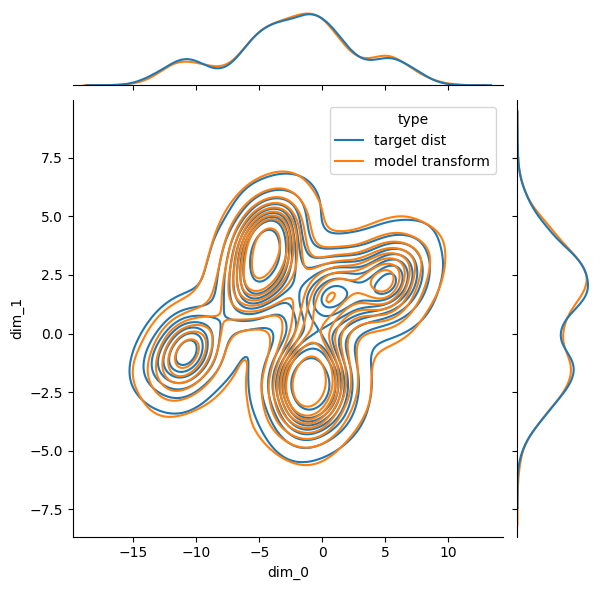

trail: 0 m step: 8 kl_test: 0.02667713165283203


  2%|▏         | 100/6000 [00:31<34:24,  2.86it/s]

trail: 0 m step: 9 Loss: 0.03094896726976795  L_n: 0.026126861572265625  kld: 0.0051136016845703125 KLD1: 0.023938221856951714 KLD2: 0.023910192772746086


  3%|▎         | 200/6000 [01:02<33:16,  2.91it/s]

trail: 0 m step: 9 Loss: 0.028010518624106553  L_n: 0.025693893432617188  kld: 0.0024566650390625 KLD1: 0.0239269882440567 KLD2: 0.025851985439658165


  5%|▌         | 300/6000 [01:33<32:46,  2.90it/s]

trail: 0 m step: 9 Loss: 0.0302044821511027  L_n: 0.02422046661376953  kld: 0.0063457489013671875 KLD1: 0.03073829598724842 KLD2: 0.023661604151129723


  7%|▋         | 400/6000 [02:04<32:17,  2.89it/s]

trail: 0 m step: 9 Loss: 0.031151098193292277  L_n: 0.026470184326171875  kld: 0.004963874816894531 KLD1: 0.02730104885995388 KLD2: 0.023176996037364006


  8%|▊         | 500/6000 [02:36<31:38,  2.90it/s]

trail: 0 m step: 9 Loss: 0.03633108858899213  L_n: 0.029340744018554688  kld: 0.007412910461425781 KLD1: 0.02715967409312725 KLD2: 0.024768361821770668


 10%|█         | 600/6000 [03:07<31:01,  2.90it/s]

trail: 0 m step: 9 Loss: 0.036580790017898386  L_n: 0.03179645538330078  kld: 0.00507354736328125 KLD1: 0.02799418941140175 KLD2: 0.02126256749033928


 12%|█▏        | 700/6000 [03:38<30:28,  2.90it/s]

trail: 0 m step: 9 Loss: 0.0383754327248653  L_n: 0.03365135192871094  kld: 0.005009651184082031 KLD1: 0.030763469636440277 KLD2: 0.02563081681728363


 13%|█▎        | 800/6000 [04:09<29:56,  2.90it/s]

trail: 0 m step: 9 Loss: 0.032082228264641736  L_n: 0.028211593627929688  kld: 0.0041046142578125 KLD1: 0.023705918341875076 KLD2: 0.026945678517222404


 15%|█▌        | 900/6000 [04:40<29:16,  2.90it/s]

trail: 0 m step: 9 Loss: 0.032960731419168325  L_n: 0.030717849731445312  kld: 0.0023784637451171875 KLD1: 0.026412267237901688 KLD2: 0.026530535891652107


 17%|█▋        | 1000/6000 [05:12<28:51,  2.89it/s]

trail: 0 m step: 9 Loss: 0.027278678223037745  L_n: 0.0237884521484375  kld: 0.0037012100219726562 KLD1: 0.0282016359269619 KLD2: 0.024130327627062798


 18%|█▊        | 1100/6000 [05:43<28:17,  2.89it/s]

trail: 0 m step: 9 Loss: 0.029295409052512537  L_n: 0.025926589965820312  kld: 0.0035724639892578125 KLD1: 0.022148234769701958 KLD2: 0.023219585418701172


 20%|██        | 1200/6000 [06:14<27:40,  2.89it/s]

trail: 0 m step: 9 Loss: 0.03012662479569435  L_n: 0.02495288848876953  kld: 0.005486488342285156 KLD1: 0.023836592212319374 KLD2: 0.025408517569303513


 22%|██▏       | 1300/6000 [06:46<27:05,  2.89it/s]

trail: 0 m step: 9 Loss: 0.023609204625730525  L_n: 0.02146434783935547  kld: 0.0022745132446289062 KLD1: 0.022998515516519547 KLD2: 0.01922447979450226


 23%|██▎       | 1400/6000 [07:17<26:26,  2.90it/s]

trail: 0 m step: 9 Loss: 0.03220789783216567  L_n: 0.027024269104003906  kld: 0.005496978759765625 KLD1: 0.025415902957320213 KLD2: 0.02093339152634144


 25%|██▌       | 1500/6000 [07:48<25:51,  2.90it/s]

trail: 0 m step: 9 Loss: 0.03188266384300278  L_n: 0.028575897216796875  kld: 0.0035066604614257812 KLD1: 0.024392377585172653 KLD2: 0.024386242032051086


 27%|██▋       | 1600/6000 [08:19<25:21,  2.89it/s]

trail: 0 m step: 9 Loss: 0.026886951130540356  L_n: 0.023479461669921875  kld: 0.0036134719848632812 KLD1: 0.024733535945415497 KLD2: 0.026783257722854614


 28%|██▊       | 1700/6000 [08:50<24:44,  2.90it/s]

trail: 0 m step: 9 Loss: 0.02702733971300833  L_n: 0.023197174072265625  kld: 0.004061698913574219 KLD1: 0.025671031326055527 KLD2: 0.023130245506763458


 30%|███       | 1800/6000 [09:22<24:07,  2.90it/s]

trail: 0 m step: 9 Loss: 0.025509404179549743  L_n: 0.02195262908935547  kld: 0.0037717819213867188 KLD1: 0.023688262328505516 KLD2: 0.02476375177502632


 32%|███▏      | 1900/6000 [09:53<23:39,  2.89it/s]

trail: 0 m step: 9 Loss: 0.03186680072595569  L_n: 0.028408050537109375  kld: 0.0036678314208984375 KLD1: 0.030916932970285416 KLD2: 0.023777179419994354


 33%|███▎      | 2000/6000 [10:24<23:03,  2.89it/s]

trail: 0 m step: 9 Loss: 0.03454180868994832  L_n: 0.030672073364257812  kld: 0.004103660583496094 KLD1: 0.028109407052397728 KLD2: 0.025317074730992317


 35%|███▌      | 2100/6000 [10:55<22:21,  2.91it/s]

trail: 0 m step: 9 Loss: 0.027561753157732592  L_n: 0.0257568359375  kld: 0.0019140243530273438 KLD1: 0.020983899012207985 KLD2: 0.018983792513608932


 37%|███▋      | 2200/6000 [11:26<21:54,  2.89it/s]

trail: 0 m step: 9 Loss: 0.030379721926382657  L_n: 0.0260009765625  kld: 0.004643440246582031 KLD1: 0.02327452041208744 KLD2: 0.024353988468647003


 38%|███▊      | 2300/6000 [11:58<21:17,  2.90it/s]

trail: 0 m step: 9 Loss: 0.028813301902100685  L_n: 0.02366924285888672  kld: 0.00545501708984375 KLD1: 0.023920705541968346 KLD2: 0.025779303163290024


 40%|████      | 2400/6000 [12:29<20:42,  2.90it/s]

trail: 0 m step: 9 Loss: 0.02666256584971056  L_n: 0.023250579833984375  kld: 0.0036182403564453125 KLD1: 0.027749935165047646 KLD2: 0.02205229178071022


 42%|████▏     | 2500/6000 [13:00<20:11,  2.89it/s]

trail: 0 m step: 9 Loss: 0.029428970713880873  L_n: 0.026849746704101562  kld: 0.002735137939453125 KLD1: 0.02382957935333252 KLD2: 0.022046923637390137


 43%|████▎     | 2600/6000 [13:31<19:33,  2.90it/s]

trail: 0 m step: 9 Loss: 0.02535539326412396  L_n: 0.023321151733398438  kld: 0.0021572113037109375 KLD1: 0.027474205940961838 KLD2: 0.021362248808145523


 45%|████▌     | 2700/6000 [14:02<18:56,  2.90it/s]

trail: 0 m step: 9 Loss: 0.030398407912887195  L_n: 0.028837203979492188  kld: 0.00165557861328125 KLD1: 0.022979717701673508 KLD2: 0.019350450485944748


 47%|████▋     | 2800/6000 [14:34<18:28,  2.89it/s]

trail: 0 m step: 9 Loss: 0.027684833056808536  L_n: 0.024019241333007812  kld: 0.003887176513671875 KLD1: 0.02137032151222229 KLD2: 0.023872507736086845


 48%|████▊     | 2900/6000 [15:05<17:47,  2.91it/s]

trail: 0 m step: 9 Loss: 0.03193014863889373  L_n: 0.028493881225585938  kld: 0.0036439895629882812 KLD1: 0.025346040725708008 KLD2: 0.019060809165239334


 50%|█████     | 3000/6000 [15:36<17:19,  2.89it/s]

trail: 0 m step: 9 Loss: 0.02243598552213914  L_n: 0.02109241485595703  kld: 0.0014247894287109375 KLD1: 0.019959965720772743 KLD2: 0.020687833428382874


 52%|█████▏    | 3100/6000 [16:07<16:42,  2.89it/s]

trail: 0 m step: 9 Loss: 0.02646197995249586  L_n: 0.024259567260742188  kld: 0.0023355484008789062 KLD1: 0.02804376743733883 KLD2: 0.02226955257356167


 53%|█████▎    | 3200/6000 [16:39<16:07,  2.89it/s]

trail: 0 m step: 9 Loss: 0.028231719175128817  L_n: 0.02515697479248047  kld: 0.0032606124877929688 KLD1: 0.025435607880353928 KLD2: 0.02235487289726734


 55%|█████▌    | 3300/6000 [17:10<15:33,  2.89it/s]

trail: 0 m step: 9 Loss: 0.024413960730169798  L_n: 0.02158832550048828  kld: 0.0029964447021484375 KLD1: 0.02716854400932789 KLD2: 0.017140517011284828


 57%|█████▋    | 3400/6000 [17:41<15:01,  2.89it/s]

trail: 0 m step: 9 Loss: 0.033672965054576974  L_n: 0.03011798858642578  kld: 0.0037698745727539062 KLD1: 0.024983497336506844 KLD2: 0.01956181973218918


 58%|█████▊    | 3500/6000 [18:13<14:21,  2.90it/s]

trail: 0 m step: 9 Loss: 0.02653408452724664  L_n: 0.02391529083251953  kld: 0.002777099609375 KLD1: 0.023412484675645828 KLD2: 0.023490577936172485


 60%|██████    | 3600/6000 [18:44<13:46,  2.90it/s]

trail: 0 m step: 9 Loss: 0.026217184033073493  L_n: 0.024209022521972656  kld: 0.0021295547485351562 KLD1: 0.02247679978609085 KLD2: 0.017732156440615654


 62%|██████▏   | 3700/6000 [19:15<13:12,  2.90it/s]

trail: 0 m step: 9 Loss: 0.028146619150530468  L_n: 0.023995399475097656  kld: 0.00440216064453125 KLD1: 0.025685423985123634 KLD2: 0.019324546679854393


 63%|██████▎   | 3800/6000 [19:46<12:37,  2.91it/s]

trail: 0 m step: 9 Loss: 0.02873096281546841  L_n: 0.025411605834960938  kld: 0.0035200119018554688 KLD1: 0.024312231689691544 KLD2: 0.021670905873179436


 65%|██████▌   | 3900/6000 [20:17<12:04,  2.90it/s]

trail: 0 m step: 9 Loss: 0.020477109290446237  L_n: 0.017665863037109375  kld: 0.0029811859130859375 KLD1: 0.02091936022043228 KLD2: 0.023021206259727478


 67%|██████▋   | 4000/6000 [20:49<11:32,  2.89it/s]

trail: 0 m step: 9 Loss: 0.026588162418209316  L_n: 0.02347564697265625  kld: 0.0033006668090820312 KLD1: 0.025653859600424767 KLD2: 0.02296140417456627


 68%|██████▊   | 4100/6000 [21:20<10:58,  2.88it/s]

trail: 0 m step: 9 Loss: 0.026140562209563258  L_n: 0.02395343780517578  kld: 0.0023193359375 KLD1: 0.018692228943109512 KLD2: 0.018409011885523796


 70%|███████   | 4200/6000 [21:51<10:21,  2.90it/s]

trail: 0 m step: 9 Loss: 0.024723903184573286  L_n: 0.021724700927734375  kld: 0.0031805038452148438 KLD1: 0.024499185383319855 KLD2: 0.018635576590895653


 72%|███████▏  | 4300/6000 [22:23<09:46,  2.90it/s]

trail: 0 m step: 9 Loss: 0.024403654096225677  L_n: 0.022180557250976562  kld: 0.00235748291015625 KLD1: 0.018734324723482132 KLD2: 0.023629523813724518


 73%|███████▎  | 4400/6000 [22:54<09:14,  2.88it/s]

trail: 0 m step: 9 Loss: 0.022436152321390054  L_n: 0.019959449768066406  kld: 0.0026264190673828125 KLD1: 0.0203845277428627 KLD2: 0.018137125298380852


 75%|███████▌  | 4500/6000 [23:25<08:38,  2.89it/s]

trail: 0 m step: 9 Loss: 0.023443427460614223  L_n: 0.020196914672851562  kld: 0.0034427642822265625 KLD1: 0.018226150423288345 KLD2: 0.01956496201455593


 77%|███████▋  | 4600/6000 [23:56<08:03,  2.89it/s]

trail: 0 m step: 9 Loss: 0.03093369519220485  L_n: 0.0287933349609375  kld: 0.002269744873046875 KLD1: 0.024682695046067238 KLD2: 0.02023579739034176


 78%|███████▊  | 4700/6000 [24:28<07:30,  2.88it/s]

trail: 0 m step: 9 Loss: 0.02468166212998058  L_n: 0.02191448211669922  kld: 0.0029344558715820312 KLD1: 0.01960420049726963 KLD2: 0.020355280488729477


 80%|████████  | 4800/6000 [24:59<06:54,  2.89it/s]

trail: 0 m step: 9 Loss: 0.025565522236243796  L_n: 0.02246379852294922  kld: 0.0032892227172851562 KLD1: 0.021117014810442924 KLD2: 0.0209831390529871


 82%|████████▏ | 4900/6000 [25:30<06:21,  2.89it/s]

trail: 0 m step: 9 Loss: 0.02332252286781523  L_n: 0.0210418701171875  kld: 0.00241851806640625 KLD1: 0.02378370240330696 KLD2: 0.018581781536340714


 83%|████████▎ | 5000/6000 [26:01<05:45,  2.90it/s]

trail: 0 m step: 9 Loss: 0.027728300526138186  L_n: 0.024939537048339844  kld: 0.0029573440551757812 KLD1: 0.019664475694298744 KLD2: 0.01818918064236641


 85%|████████▌ | 5100/6000 [26:33<05:10,  2.90it/s]

trail: 0 m step: 9 Loss: 0.02693092392986302  L_n: 0.0250396728515625  kld: 0.0020055770874023438 KLD1: 0.02603505738079548 KLD2: 0.021401187404990196


 87%|████████▋ | 5200/6000 [27:04<04:36,  2.89it/s]

trail: 0 m step: 9 Loss: 0.027413170704669095  L_n: 0.02338695526123047  kld: 0.004269599914550781 KLD1: 0.02167435921728611 KLD2: 0.018733570352196693


 88%|████████▊ | 5300/6000 [27:35<04:01,  2.90it/s]

trail: 0 m step: 9 Loss: 0.021001089466405005  L_n: 0.017975807189941406  kld: 0.003208160400390625 KLD1: 0.020213961601257324 KLD2: 0.018165726214647293


 90%|█████████ | 5400/6000 [28:06<03:27,  2.89it/s]

trail: 0 m step: 9 Loss: 0.03006722578303981  L_n: 0.02747631072998047  kld: 0.0027475357055664062 KLD1: 0.027921410277485847 KLD2: 0.021289434283971786


 92%|█████████▏| 5500/6000 [28:38<02:53,  2.89it/s]

trail: 0 m step: 9 Loss: 0.02666738858458746  L_n: 0.023256301879882812  kld: 0.0036172866821289062 KLD1: 0.024988213554024696 KLD2: 0.0166004691272974


 93%|█████████▎| 5600/6000 [29:09<02:18,  2.89it/s]

trail: 0 m step: 9 Loss: 0.023178882678226594  L_n: 0.022308349609375  kld: 0.00092315673828125 KLD1: 0.017135191708803177 KLD2: 0.02004302479326725


 95%|█████████▌| 5700/6000 [29:40<01:44,  2.88it/s]

trail: 0 m step: 9 Loss: 0.02323354204312046  L_n: 0.02069568634033203  kld: 0.0026912689208984375 KLD1: 0.019847873598337173 KLD2: 0.018887082114815712


 97%|█████████▋| 5800/6000 [30:11<01:08,  2.90it/s]

trail: 0 m step: 9 Loss: 0.031647727449656576  L_n: 0.02819347381591797  kld: 0.0036630630493164062 KLD1: 0.02561456896364689 KLD2: 0.01789582334458828


 98%|█████████▊| 5900/6000 [30:43<00:34,  2.90it/s]

trail: 0 m step: 9 Loss: 0.02409029339849597  L_n: 0.020643234252929688  kld: 0.0036554336547851562 KLD1: 0.02476363442838192 KLD2: 0.01939747855067253


100%|██████████| 6000/6000 [31:14<00:00,  3.20it/s]

trail: 0 m step: 9 Loss: 0.02585740727210004  L_n: 0.02289867401123047  kld: 0.0031375885009765625 KLD1: 0.018802663311362267 KLD2: 0.022741377353668213



<ipython-input-8-c2ac7a190cf3>:31: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df_all = df_all.set_axis(['dim_0', 'dim_1', 'type'], axis=1, inplace=False)


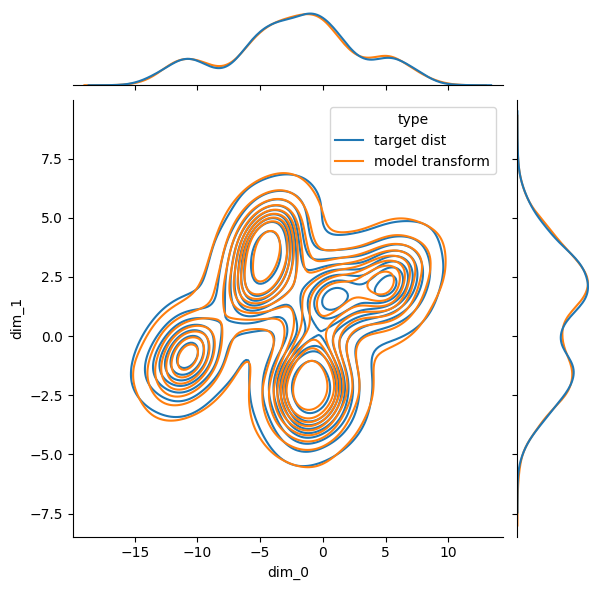

trail: 0 m step: 9 kl_test: 0.0203704833984375


In [ ]:
for mirror_itr in range(n_max_mirror_iterations):
  flows = []
  for i in range(num_layers):
      param_map = nf.nets.MLP([int(dim/2), width, width, width, dim], init_zeros=True )
      flows.append(nf.flows.AffineCouplingBlock(param_map))
      flows.append(nf.flows.Permute(dim, mode='swap'))

  # for i in range(num_layers):
  #     flows += [nf.flows.AutoregressiveRationalQuadraticSpline(dim, 2, width)]
  #     flows += [nf.flows.LULinearPermute(dim)]

  model2 = nf.NormalizingFlow(base, flows, stationary_dist).to(device)
  model2.load_state_dict(model.state_dict())
  optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

  input_eta = (eta*(1.3**mirror_itr))
  for it in tqdm(range(n_max_iterations), disable = not verbose):
    model2 = model2.train()
    optimizer.zero_grad()
    # torch.manual_seed(set_seed + trail_num)
    z = base.sample(num_samples)
    log_prob_rho_0 = base.log_prob(z)
    sampled_theta, log_det_model = model2.forward_and_log_det(z)
    log_prob_model = log_prob_rho_0 - log_det_model
    log_prob_prev = model.log_prob(sampled_theta)

    L_n_loss =  model2.reverse_kld(num_samples=num_samples)
    kld_loss = torch.mean(log_prob_model).to(torch.double) - torch.mean(log_prob_prev).to(torch.double)
    kld_loss = kld_loss if kld_loss.item() >= 0 else torch.tensor([0.0]).to(device)
    kld_loss = kld_loss if kld_loss.item() <= 500 else torch.tensor([500.0]).to(device)
    loss = L_n_loss   + (1/input_eta)*kld_loss

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      scheduler.step()


    if verbose:
      if it % 100 == 99:
        with torch.no_grad():
          model2.eval()
          target_samples = stationary_dist.sample((num_samples,))
          temp1 = model2.log_prob(sampled_theta) - stationary_dist.log_prob(sampled_theta)
          temp2 = stationary_dist.log_prob(target_samples) - model2.log_prob(target_samples)
        kld_1 = torch.mean(temp1)
        kld_2 = torch.mean(temp2)
        print('trail:',trail_num,'m step:',mirror_itr,'Loss:', loss.item(), ' L_n:', L_n_loss.item() , ' kld:',kld_loss.item(), 'KLD1:', kld_1.item(), 'KLD2:', kld_2.item()  )

  model.load_state_dict(model2.state_dict())
  kld1_hist = np.append(kld1_hist, kld_1.to('cpu').data.numpy())
  kld2_hist = np.append(kld2_hist, kld_2.to('cpu').data.numpy())
  with torch.no_grad():
    model.eval()
    target_samples = stationary_dist.sample((5000,))
    model_samples, _ = model.sample(5000)
    kl_test = model2.reverse_kld(num_samples=num_samples_test)
    kl_test = kl_test.cpu().detach()
  plot_two_data(target_samples.cpu().detach(), model_samples.cpu().detach())
  plt.show()
  print('trail:',trail_num,'m step:',mirror_itr,'kl_test:', kl_test.item()   )
